In [1]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
2025-09-02 03:20:26.192283: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-02 03:20:27.855038: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-02 03:20:28.132274: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been register

In [2]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


2025-09-02 03:21:02.027852: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-09-02 03:21:08.641458: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-09-02 03:21:08.644955: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
logdir = "tensorboard_logs/fit"
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

In [4]:
#setting random seed
seed = 42 
random.seed(seed)

#setting seed for NumPy
np.random.seed(seed)

#setting seed for TensorFlow
tf.random.set_seed(seed)

#setting seed for full reproducibility (slower but stricter)
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [5]:
data_labels = pd.read_csv('dev_data_2025.csv')
data_labels.head()
print(len(data_labels['imageID']))

5000


In [6]:
image_path = "Hematoxylin/"
images = os.listdir(image_path)
print(f"Total Number of Images:{len(images)}")

Total Number of Images:10298


In [7]:
images_set = set(images)
csv_images_set = set(data_labels['imageID'].astype(str))
print("Images in labels_main but missing from patch_images folder:", len(csv_images_set - images_set))

#use only images that are listed in the CSV file
images_filtered = [img for img in images if img in csv_images_set]

Images in labels_main but missing from patch_images folder: 5000


In [8]:
"""
I have two way of loading dataset, one is on the fly using tensorflow and another is this, this one is not memeory efficient enough but makes the training faster
I will do this for now, and later i will think about usinng tensorflow one the fly process. but lets create a pipline for now.
"""



# import os
# from PIL import Image

# # 1) Build a filename column that exactly matches what’s on disk
data_labels['filename'] = data_labels['imageID'].astype(str) + ".jpg"
data_labels['full_path'] = data_labels['filename'].apply(lambda x: os.path.join(image_path, x))

# # 2) Loader returns a dict keyed by *filename* (with extension)
# def load_images(image_folder, filenames):
#     images = {}
#     for fname in filenames:
#         img_path = os.path.join(image_folder, fname)
#         try:
#             with Image.open(img_path) as img:
#                 images[fname] = img.copy()
#         except Exception as e:
#             print(f"Error loading {fname}: {e}")
#     return images

# # 3) Load using the filename column, then map with the same key
# image_objects = load_images(image_path, data_labels['filename'])
# data_labels['Image'] = data_labels['filename'].map(image_objects)


In [9]:
print(data_labels.head())

     imageID       label cell_shape         nucleus_shape cytoplasm_vacuole  \
0  Img_00001  Lymphocyte      round     unsegmented-round                no   
1  Img_00002    Monocyte  irregular  unsegmented-indented                no   
2  Img_00003    Monocyte  irregular             irregular               yes   
3  Img_00004    Basophil      round  segmented-multilobed                no   
4  Img_00005  Neutrophil      round      unsegmented-band                no   

        filename                  full_path  
0  Img_00001.jpg  Hematoxylin/Img_00001.jpg  
1  Img_00002.jpg  Hematoxylin/Img_00002.jpg  
2  Img_00003.jpg  Hematoxylin/Img_00003.jpg  
3  Img_00004.jpg  Hematoxylin/Img_00004.jpg  
4  Img_00005.jpg  Hematoxylin/Img_00005.jpg  


In [10]:
data_labels.iloc[900:]

imageID       label cell_shape      nucleus_shape cytoplasm_vacuole  \
900   Img_00901  Lymphocyte      round  unsegmented-round                no   
901   Img_00902  Neutrophil      round   unsegmented-band                no   
902   Img_00903  Neutrophil      round   unsegmented-band                no   
903   Img_00904  Eosinophil      round  segmented-bilobed                no   
904   Img_00905    Monocyte  irregular  unsegmented-round               yes   
...         ...         ...        ...                ...               ...   
4995  Img_04996  Lymphocyte  irregular  unsegmented-round                no   
4996  Img_04997  Neutrophil      round   unsegmented-band                no   
4997  Img_04998    Basophil      round          irregular                no   
4998  Img_04999  Neutrophil      round   unsegmented-band                no   
4999  Img_05000  Neutrophil      round   unsegmented-band                no   

           filename                  full_path  
900   Img_00901.jpg  Hematoxylin/Img_00901.jpg  
901   Img_00902.jpg  Hematoxylin/Img_00902.jpg  
902   Img_00903.jpg  Hematoxylin/Img_00903.jpg  
903   Img_00904.jpg  Hematoxylin/Img_00904.jpg  
904   Img_00905.jpg  Hematoxylin/Img_00905.jpg  
...             ...                        ...  
4995  Img_04996.jpg  Hematoxylin/Img_04996.jpg  
4996  Img_04997.jpg  Hematoxylin/Img_04997.jpg  
4997  Img_04998.jpg  Hematoxylin/Img_04998.jpg  
4998  Img_04999.jpg  Hematoxylin/Img_04999.jpg  
4999  Img_05000.jpg  Hematoxylin/Img_05000.jpg  

[4100 rows x 7 columns]

In [11]:
data_labels.shape

(5000, 7)

In [12]:
data_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   imageID            5000 non-null   object
 1   label              5000 non-null   object
 2   cell_shape         5000 non-null   object
 3   nucleus_shape      5000 non-null   object
 4   cytoplasm_vacuole  5000 non-null   object
 5   filename           5000 non-null   object
 6   full_path          5000 non-null   object
dtypes: object(7)
memory usage: 273.6+ KB


In [78]:
data_labels.describe()

label_idx  cell_shape_idx  nucleus_shape_idx  cytoplasm_vacuole_idx
count  5000.000000     5000.000000        5000.000000            5000.000000
mean      2.227800        0.780800           2.357600               0.072200
std       1.474972        0.413746           1.489888               0.258845
min       0.000000        0.000000           0.000000               0.000000
25%       1.000000        1.000000           1.000000               0.000000
50%       2.000000        1.000000           2.000000               0.000000
75%       4.000000        1.000000           3.000000               0.000000
max       4.000000        1.000000           5.000000               1.000000

## EDA

In [13]:
## About the dataset, tell about image size, image colour, and the classes 

In [14]:
print("Total samples:", len(data_labels))
print("\nMissing values:\n", data_labels.isnull().sum())
print("\nUnique labels per column:")
for col in ['label', 'cell_shape', 'nucleus_shape', 'cytoplasm_vacuole']:
    print(f"{col}: {data_labels[col].unique()}")


Total samples: 5000

Missing values:
 imageID              0
label                0
cell_shape           0
nucleus_shape        0
cytoplasm_vacuole    0
filename             0
full_path            0
dtype: int64

Unique labels per column:
label: ['Lymphocyte' 'Monocyte' 'Basophil' 'Neutrophil' 'Eosinophil']
cell_shape: ['round' 'irregular']
nucleus_shape: ['unsegmented-round' 'unsegmented-indented' 'irregular'
 'segmented-multilobed' 'unsegmented-band' 'segmented-bilobed']
cytoplasm_vacuole: ['no' 'yes']


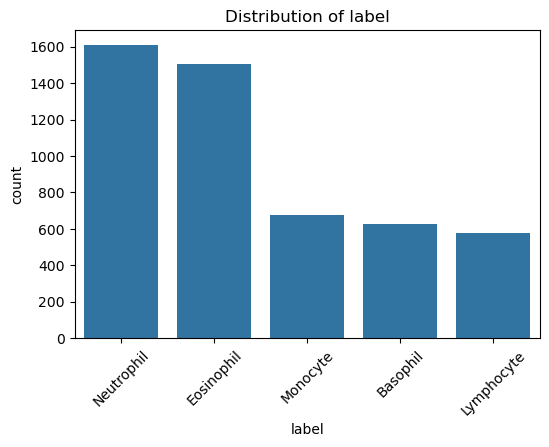

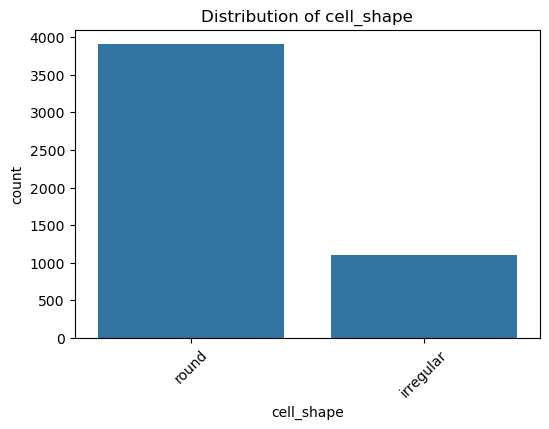

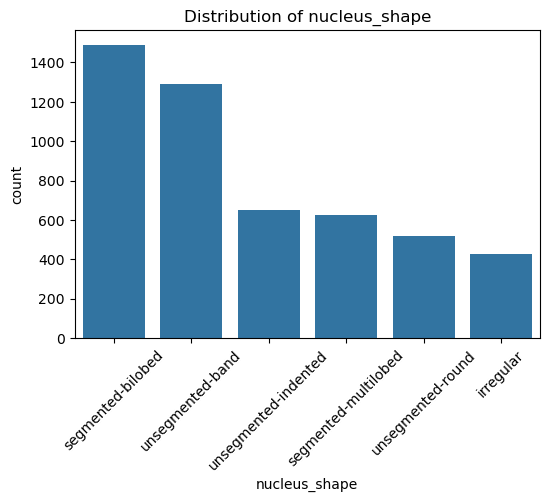

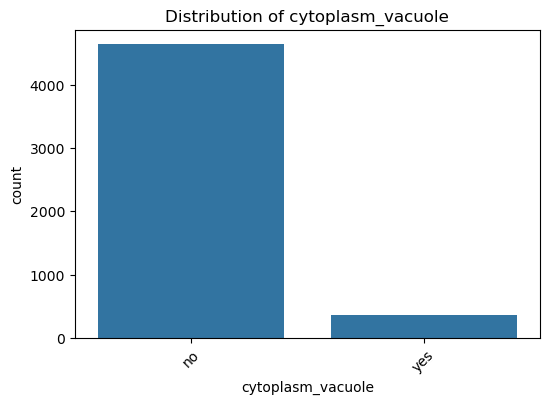

In [15]:
"""
class balance check, neutrophil and eosinophil has more distribution than other, have to take care of this.
round type shape is more
segmented and unsegmented is more
in cytoplasm vacuole, no has more data
"""

import seaborn as sns
import matplotlib.pyplot as plt

categorical_cols = ['label', 'cell_shape', 'nucleus_shape', 'cytoplasm_vacuole']

for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(data=data_labels, x=col, order=data_labels[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()


In [16]:
# sizes = data_labels['Image'].apply(lambda img: img.size)
# print("Unique image shape and size:", sizes.value_counts())


from PIL import Image
from collections import Counter

size_counts = Counter()
for path in data_labels['full_path']:
    with Image.open(path) as img:
        size_counts[img.size] += 1

print("Unique image sizes and counts:", size_counts)


Unique image sizes and counts: Counter({(360, 363): 4875, (366, 369): 125})


In [17]:
import numpy as np
sample_path = data_labels['full_path'].iloc[0]
with Image.open(sample_path) as img:
    arr = np.array(img)
print("Pixel range:", arr.min(), "-", arr.max())
print("Shape:", arr.shape)


Pixel range: 24 - 255
Shape: (363, 360, 3)


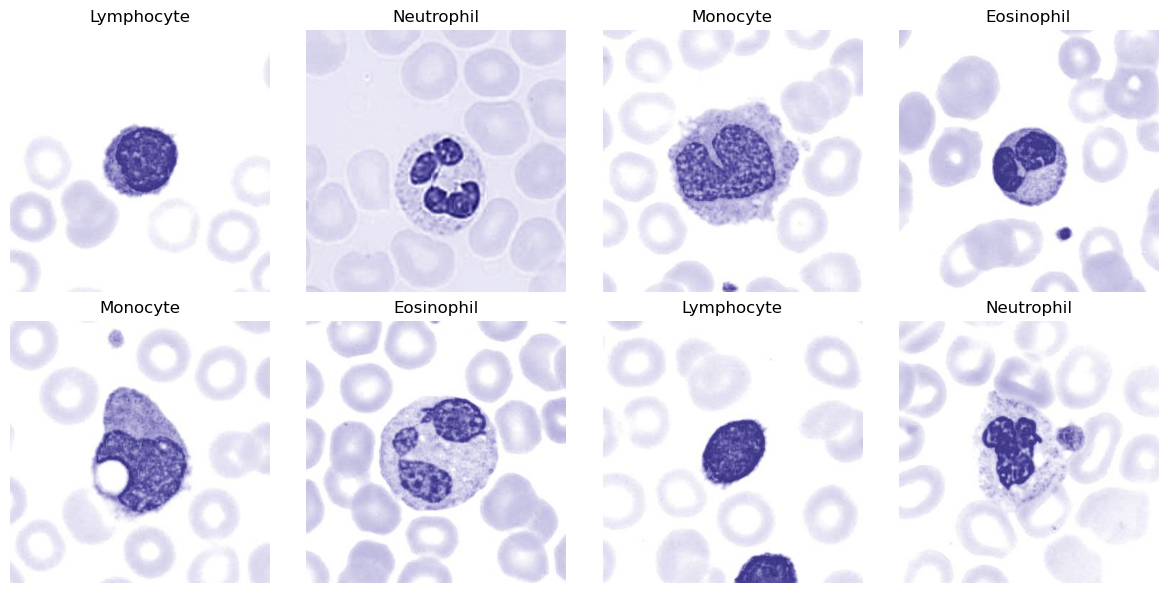

In [18]:
from random import sample

sample_paths = sample(list(data_labels['full_path']), 8)
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for ax, path in zip(axes.flat, sample_paths):
    with Image.open(path) as img:
        ax.imshow(img)
    label = data_labels.loc[data_labels['full_path'] == path, 'label'].values[0]
    ax.set_title(label)
    ax.axis('off')
plt.tight_layout()
plt.show()


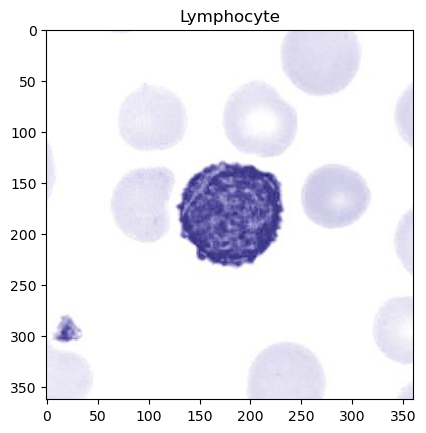

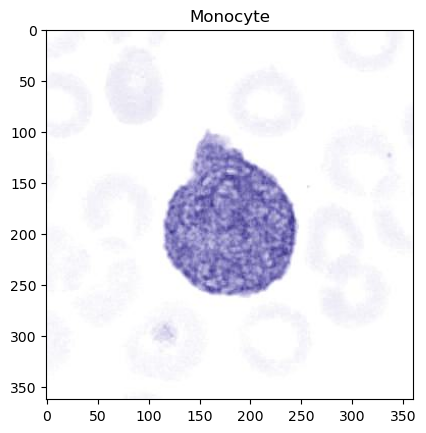

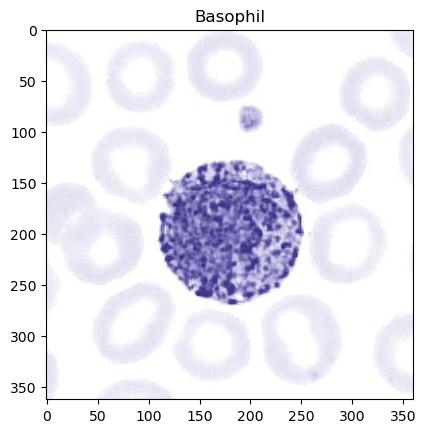

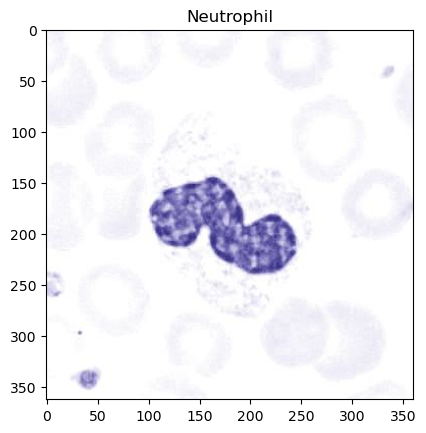

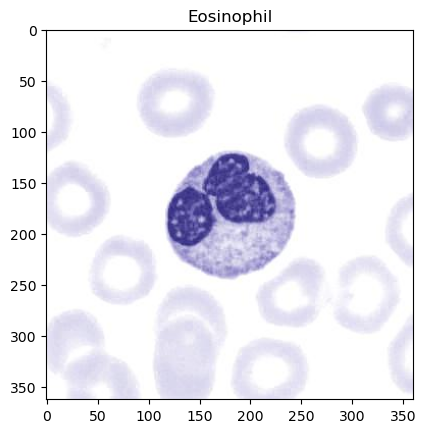

In [19]:
for cls in data_labels['label'].unique():
    sample_path = data_labels[data_labels['label'] == cls]['full_path'].sample(1).iloc[0]
    with Image.open(sample_path) as img:
        plt.imshow(img)
        plt.title(cls)
        plt.show()


In [20]:
# import numpy as np
# sample_img = np.array(data_labels['Image'].iloc[0])
# print("Pixel range:", sample_img.min(), "-", sample_img.max())
# print("Shape:", sample_img.shape)


In [21]:
# from random import sample

# fig, axes = plt.subplots(2, 4, figsize=(12, 6))
# for ax, idx in zip(axes.flat, sample(range(len(data_labels)), 8)):
#     img = data_labels['Image'].iloc[idx]
#     label = data_labels['label'].iloc[idx]
#     ax.imshow(img)
#     ax.set_title(label)
#     ax.axis('off')
# plt.tight_layout()
# plt.show()


In [83]:
import os

image_folder = 'Hematoxylin/'

images = os.listdir(image_folder)

len(images)

image

10298

Checking Image Quality: 100%|██████████| 5000/5000 [00:10<00:00, 465.81it/s]



Summary of Image Quality Issues:
Total images checked: 5000
Missing files:         0
Corrupted files:       0
Total blurry:          5000
Total low-edge/occ.:   321

Results saved to 'image_quality_issues.csv'


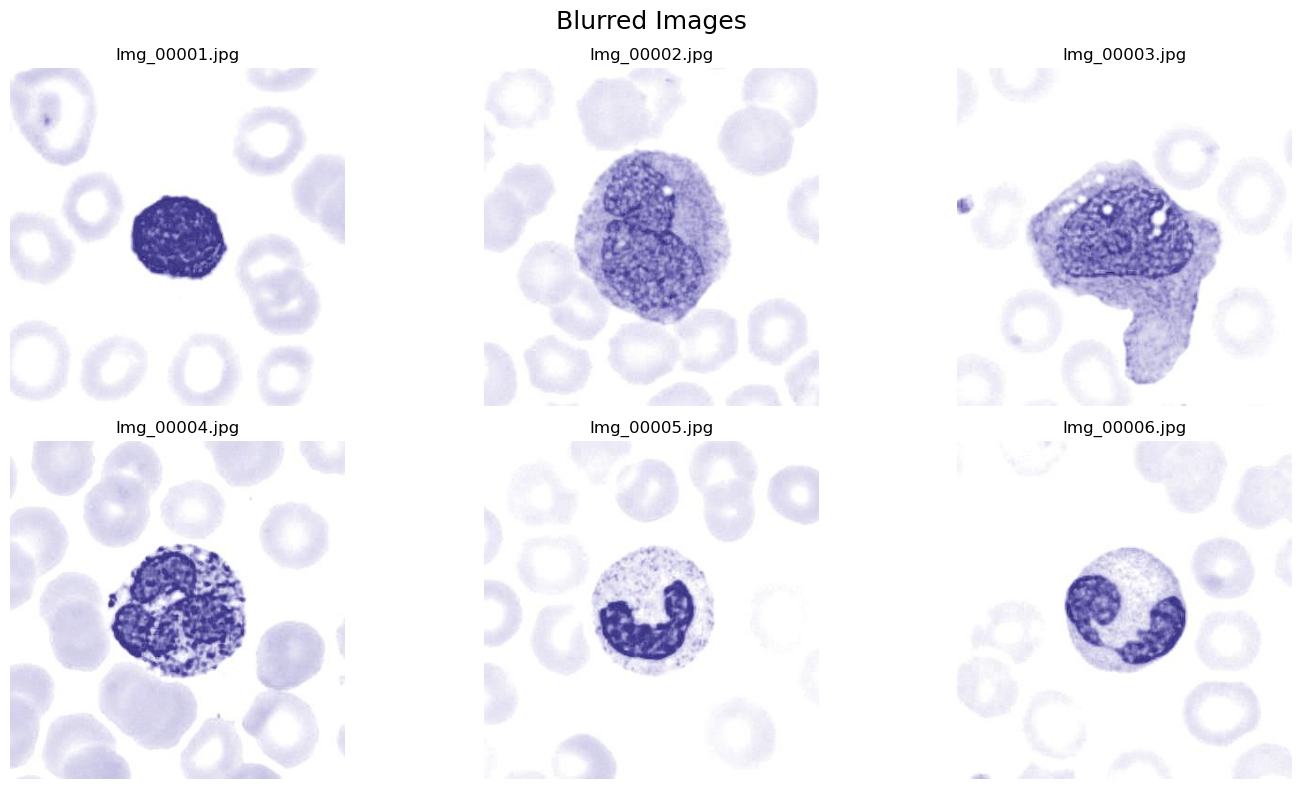

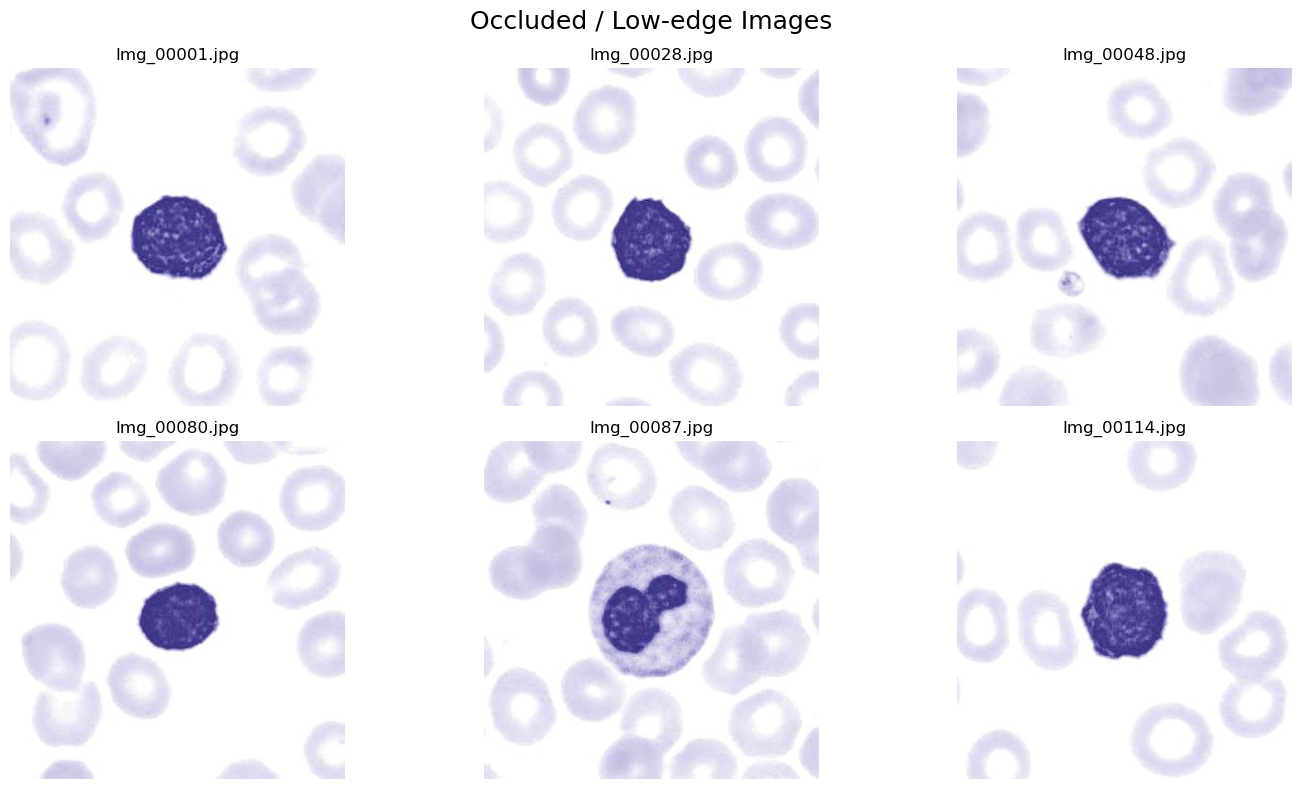

In [86]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# thresholds
BLUR_THRESHOLD = 500.0
EDGE_RATIO_THRESHOLD = 0.01

blurred_images = []
occluded_images = []
missing_images = []
corrupted_images = []

def edge_ratio(img_gray):
    edges = cv2.Canny(img_gray, 100, 200)
    return np.count_nonzero(edges) / edges.size

# --- Main loop: iterate full paths directly ---
for img_path in tqdm(list(data_labels['full_path'].astype(str)), desc="Checking Image Quality"):
    if not os.path.exists(img_path):
        missing_images.append(img_path)
        continue

    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if image is None:
        corrupted_images.append(img_path)
        continue

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 1) Blur
    lap_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    if lap_var < BLUR_THRESHOLD:
        blurred_images.append(img_path)

    # 2) Low-edge / occlusion-ish
    if edge_ratio(gray) < EDGE_RATIO_THRESHOLD:
        occluded_images.append(img_path)

# --- Summary ---
print("\nSummary of Image Quality Issues:")
print(f"Total images checked: {len(data_labels['full_path'])}")
print(f"Missing files:         {len(missing_images)}")
print(f"Corrupted files:       {len(corrupted_images)}")
print(f"Total blurry:          {len(blurred_images)}")
print(f"Total low-edge/occ.:   {len(occluded_images)}")

# --- Save tidy CSV: one row per image with boolean flags ---
blur_set = set(blurred_images)
occ_set  = set(occluded_images)
miss_set = set(missing_images)
corr_set = set(corrupted_images)

rows = []
for p in data_labels['full_path'].astype(str):
    rows.append({
        "full_path": p,
        "missing": p in miss_set,
        "corrupted": p in corr_set,
        "blurred": p in blur_set,
        "occluded_or_low_edge": p in occ_set,
        "filename": os.path.basename(p)
    })
pd.DataFrame(rows).to_csv("image_quality_issues.csv", index=False)
print("\nResults saved to 'image_quality_issues.csv'")

# --- Visualisation helpers (work with full paths directly) ---
def visualize_samples(paths, title, n=6):
    if not paths:
        print(f"No samples to show for: {title}")
        return
    cols = 3
    rows = int(np.ceil(min(n, len(paths))/cols))
    plt.figure(figsize=(5*cols, 4*rows))
    for i, p in enumerate(paths[:n]):
        img = cv2.imread(p)
        if img is None: 
            continue
        plt.subplot(rows, cols, i+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(os.path.basename(p))
        plt.axis('off')
    plt.suptitle(title, fontsize=18)
    plt.tight_layout()
    plt.show()

visualize_samples(blurred_images,  "Blurred Images")
visualize_samples(occluded_images, "Occluded / Low-edge Images")


In [22]:
# Statistical Analysis

# Look for:

# Distribution of resolutions

# Blurry or overcompressed images (e.g., using variance or edge detection)

# Corrupt or empty images
# check with blur detection in one batch

## Data loading, Merging with images preparing for training

In [23]:
from sklearn.preprocessing import LabelEncoder



TARGET_SIZE = (224, 224)  # good for transfer learning
# TARGET_SIZE = (360, 360) 
BATCH_SIZE  = 32
AUTOTUNE    = tf.data.AUTOTUNE

label_encoder = LabelEncoder()
cell_encoder  = LabelEncoder()
nuc_encoder   = LabelEncoder()
vac_encoder   = LabelEncoder()

data_labels['label_idx'] = label_encoder.fit_transform(data_labels['label'])
data_labels['cell_shape_idx'] = cell_encoder.fit_transform(data_labels['cell_shape'])
data_labels['nucleus_shape_idx'] = nuc_encoder.fit_transform(data_labels['nucleus_shape'])
data_labels['cytoplasm_vacuole_idx'] = vac_encoder.fit_transform(data_labels['cytoplasm_vacuole'])

# Store category names
n_label = len(label_encoder.classes_)
n_cell  = len(cell_encoder.classes_)
n_nuc   = len(nuc_encoder.classes_)
n_vac   = len(vac_encoder.classes_)

print(n_label, n_cell, n_nuc, n_vac)

5 2 6 2


In [24]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    data_labels,
    test_size=0.2,
    random_state=42,
    stratify=data_labels['label_idx']  # stratify on main class
)

len(train_df), len(val_df)


(4000, 1000)

In [25]:
def oversample_minority_classes(df, label_col='label_idx'):
    class_counts = df[label_col].value_counts()
    target_count = class_counts.max()

    oversampled_parts = []

    for cls, count in class_counts.items():
        df_cls = df[df[label_col] == cls]
        reps = target_count // count
        rem = target_count % count

        df_oversampled = pd.concat(
            [df_cls] * reps + [df_cls.sample(rem, replace=True)],
            ignore_index=True
        )
        oversampled_parts.append(df_oversampled)

    # Combine and shuffle
    df_balanced = pd.concat(oversampled_parts, ignore_index=True)
    df_balanced = df_balanced.sample(frac=1.0, random_state=42)
    return df_balanced


In [26]:
train_df_balanced = oversample_minority_classes(train_df)
print("Before:", train_df['label_idx'].value_counts().to_dict())
print("After:", train_df_balanced['label_idx'].value_counts().to_dict())


Before: {4: 1288, 1: 1203, 3: 543, 0: 503, 2: 463}
After: {0: 1288, 1: 1288, 3: 1288, 4: 1288, 2: 1288}


In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

rng = 42
val_df = val_df.copy()  # just in case

# ---- 1) build a small EYEBALL set: per-class k samples ----
per_class = 10  # tweak: 8–12 is typical
eyeball_idx = []

for cls, group in val_df.groupby('label_idx'):
    take = group.sample(n=min(per_class, len(group)), random_state=rng).index
    eyeball_idx.append(take)

eyeball_idx = np.concatenate(eyeball_idx) if len(eyeball_idx) else np.array([], dtype=int)
eyeball_df  = val_df.loc[eyeball_idx].copy()

# remaining = blackbox candidate pool
blackbox_pool = val_df.drop(index=eyeball_idx)

# ---- 2) optionally keep blackbox to a fixed fraction of the whole val ----
# e.g., use all remaining (recommended) or take a fraction stratified
# here we keep ALL remaining:
blackbox_df = blackbox_pool.copy()

print({
    "eyeball_dev": len(eyeball_df),
    "blackbox_dev": len(blackbox_df)
})

# quick sanity
print("Eyeball per class:\n", eyeball_df['label'].value_counts())
print("Blackbox per class:\n", blackbox_df['label'].value_counts())


{'eyeball_dev': 50, 'blackbox_dev': 950}
Eyeball per class:
 label
Basophil      10
Eosinophil    10
Lymphocyte    10
Monocyte      10
Neutrophil    10
Name: count, dtype: int64
Blackbox per class:
 label
Neutrophil    312
Eosinophil    291
Monocyte      126
Basophil      115
Lymphocyte    106
Name: count, dtype: int64


In [28]:
# You're using LabelEncoder because:

# Your labels are categorical text.

# You need to convert them into numeric format to be compatible with TensorFlow/Keras or any ML model.

# You store the number of classes with n_label, n_cell, etc., which is useful for building final dense layers or loss functions.

In [29]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

def cls_weights(y_int, n_classes):
    classes = np.arange(n_classes)
    w = compute_class_weight(class_weight="balanced", classes=classes, y=y_int)
    return w.astype(np.float32)  # numpy array

W_LABEL = cls_weights(train_df['label_idx'].values,             n_label)
W_CELL  = cls_weights(train_df['cell_shape_idx'].values,        n_cell)
W_NUC   = cls_weights(train_df['nucleus_shape_idx'].values,     n_nuc)
W_VAC   = cls_weights(train_df['cytoplasm_vacuole_idx'].values, n_vac)


In [30]:
# balance on this head
MAIN_KEY    = "out_label"
NUM_CLASSES = n_label

def _class_from_onehot(x, labels):
    return tf.argmax(labels[MAIN_KEY], axis=-1, output_type=tf.int32)

# convert one-hot to ids (works on batched tensors too)
def _onehot_id(t): 
    return tf.argmax(t, axis=-1, output_type=tf.int32)

# Attach per-head sample weights
W_LABEL_T = tf.constant(W_LABEL)
W_CELL_T  = tf.constant(W_CELL)
W_NUC_T   = tf.constant(W_NUC)
W_VAC_T   = tf.constant(W_VAC)

def attach_weights(x, y):
    cid_label = _onehot_id(y['out_label'])
    cid_cell  = _onehot_id(y['out_cell'])
    cid_nuc   = _onehot_id(y['out_nuc'])
    cid_vac   = _onehot_id(y['out_vac'])

    sw = {
        # 'out_label': tf.gather(W_LABEL_T, cid_label),
        'out_cell':  tf.gather(W_CELL_T,  cid_cell),
        'out_nuc':   tf.gather(W_NUC_T,   cid_nuc),
        'out_vac':   tf.gather(W_VAC_T,   cid_vac),
    }
    return x, y, sw


2025-09-02 03:21:14.163427: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-09-02 03:21:14.166931: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-09-02 03:21:14.169640: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [31]:
def load_and_preprocess(path, y_label, y_cell, y_nuc, y_vac):
    # path: tf.string, labels: tf.int32
    img = tf.io.read_file(path)
    # use decode_jpeg or decode_image (handles png/jpg). You have .jpg, so:
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, TARGET_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    # img = tf.cast(img, tf.float32)

    # Optionally do light augmentation for training via a separate map
    labels = {
        'out_label': tf.one_hot(y_label, depth=n_label),
        'out_cell':  tf.one_hot(y_cell,  depth=n_cell),
        'out_nuc':   tf.one_hot(y_nuc,   depth=n_nuc),
        'out_vac':   tf.one_hot(y_vac,   depth=n_vac),
    }
    return img, labels

def make_dataset(df, shuffle=False, augment=False, add_weights=False, repeat=False):
    paths = df['full_path'].astype(str).values
    y_label = df['label_idx'].values.astype(np.int32)
    y_cell  = df['cell_shape_idx'].values.astype(np.int32)
    y_nuc   = df['nucleus_shape_idx'].values.astype(np.int32)
    y_vac   = df['cytoplasm_vacuole_idx'].values.astype(np.int32)

    ds = tf.data.Dataset.from_tensor_slices((paths, y_label, y_cell, y_nuc, y_vac))

    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(df), 2000), seed=42)

    ds = ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)

    if augment:
        aug = tf.keras.Sequential([
            tf.keras.layers.RandomFlip('horizontal'),
            tf.keras.layers.RandomRotation(0.05),
            tf.keras.layers.RandomZoom(0.05),
            # tf.keras.layers.RandomBrightness(factor=0.1),
            tf.keras.layers.RandomBrightness(factor=0.1, value_range=(0.0, 1.0)),
            # tf.keras.layers.Rescaling(1./255),
        ])
        ds = ds.map(lambda x, y: (aug(x, training=True), y), num_parallel_calls=AUTOTUNE)

    ds = ds.batch(BATCH_SIZE)
    if repeat:
        ds = ds.repeat()

        # === Step 5: Optional weighting ===
    if add_weights:
        ds = ds.map(attach_weights, num_parallel_calls=AUTOTUNE)

    ds = ds.prefetch(AUTOTUNE)
    return ds

In [32]:
train_ds    = make_dataset(train_df_balanced, shuffle=True, augment=True, repeat=False, add_weights=False )     # repeated
eyeball_ds  = make_dataset(eyeball_df, shuffle=False, augment=False, repeat=False) # NOT repeated
blackbox_ds = make_dataset(blackbox_df, shuffle=False, augment=False, repeat=False) # NOT repeated

In [33]:
for imgs, labels in train_ds.take(1):
    print("imgs:", imgs.shape, imgs.dtype, tf.reduce_min(imgs).numpy(), tf.reduce_max(imgs).numpy())
    for k, v in labels.items():
        v = tf.cast(v, tf.float32)
        print(k, v.shape, "one-hot sums per row ~1:",
              tf.reduce_mean(tf.reduce_sum(v, axis=1)).numpy())


imgs: (32, 224, 224, 3) <dtype: 'float32'> 0.08193858 1.0
out_label (32, 5) one-hot sums per row ~1: 1.0
out_cell (32, 2) one-hot sums per row ~1: 1.0
out_nuc (32, 6) one-hot sums per row ~1: 1.0
out_vac (32, 2) one-hot sums per row ~1: 1.0


2025-09-02 03:21:29.117149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


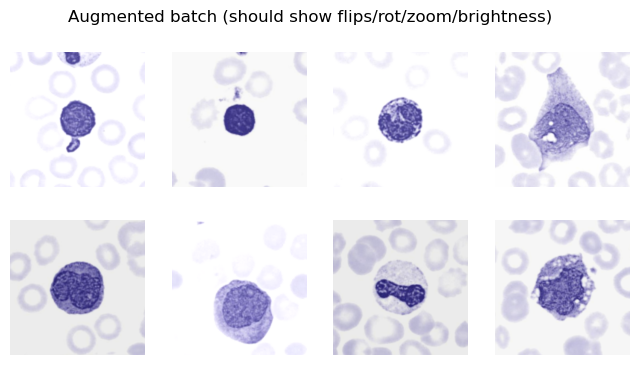

2025-09-02 03:21:29.729337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [34]:
import matplotlib.pyplot as plt

def show_batch(imgs, rows=2, cols=4, title=""):
    imgs = imgs.numpy()
    plt.figure(figsize=(cols*2, rows*2))
    for i in range(min(len(imgs), rows*cols)):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(imgs[i])
        ax.axis('off')
    if title: plt.suptitle(title)
    plt.show()

for imgs, labels in train_ds.take(1):
    show_batch(imgs, title="Augmented batch (should show flips/rot/zoom/brightness)")


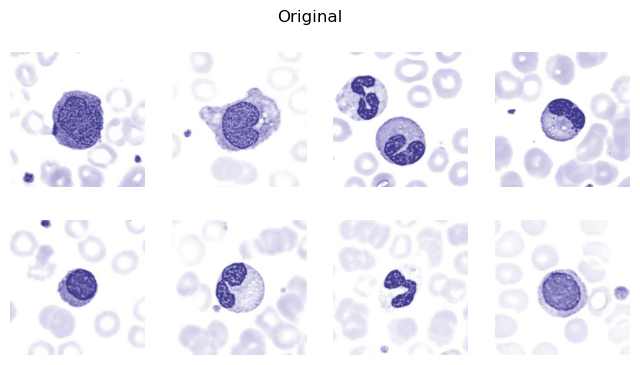

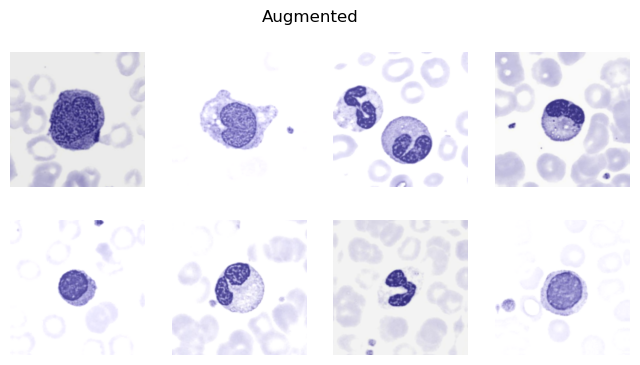

Per-image mean abs diffs: [0.10051125 0.04381777 0.08996662 0.07286356 0.03985592 0.04534821
 0.0601581  0.03778525]


In [35]:
subset = train_df.sample(8, random_state=123)

noaug = make_dataset(subset, shuffle=False, augment=False, repeat=False)
aug   = make_dataset(subset, shuffle=False, augment=True,  repeat=False)

paired = tf.data.Dataset.zip((noaug, aug)).take(1)
(orig_imgs, _), (aug_imgs, _) = next(iter(paired))

show_batch(orig_imgs, title="Original")
show_batch(aug_imgs,  title="Augmented")

# Quantify difference per image (should be >0 for most)
diff = tf.reduce_mean(tf.abs(tf.cast(orig_imgs, tf.float32) - tf.cast(aug_imgs, tf.float32)), axis=[1,2,3])
print("Per-image mean abs diffs:", diff.numpy())


In [36]:
xb, yb = next(iter(train_ds))
print("Batch images:", xb.shape)  # (B, 224, 224, 3)
for k, v in yb.items():
    print(k, v.shape)             # one-hot shapes per head


Batch images: (32, 224, 224, 3)
out_label (32, 5)
out_cell (32, 2)
out_nuc (32, 6)
out_vac (32, 2)


## Model Evaluation Helper function

In [37]:
import re, matplotlib.pyplot as plt

def plot_history(history, save_dir=None):
    h = history.history

    # discover heads from keys like "out_label_accuracy", "out_label_loss"
    heads = sorted({m.group(1) for k in h.keys()
                    if (m := re.match(r'^(out_[^_]+)_(accuracy|loss)$', k))})

    # --- Accuracy ---
    plt.figure()
    for head in heads:
        acc_key = f"{head}_accuracy"
        val_key = f"val_{head}_accuracy"
        if acc_key in h: plt.plot(h[acc_key], label=f"{head} acc")
        if val_key in h: plt.plot(h[val_key], linestyle='--', label=f"val {head} acc")
    plt.title("Per-head Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    if save_dir: plt.savefig(f"{save_dir}/acc.png", dpi=150, bbox_inches='tight')
    plt.show()

    # --- Loss (per head + total) ---
    plt.figure()
    for head in heads:
        loss_key = f"{head}_loss"
        val_loss_key = f"val_{head}_loss"
        if loss_key in h: plt.plot(h[loss_key], label=f"{head} loss")
        if val_loss_key in h: plt.plot(h[val_loss_key], linestyle='--', label=f"val {head} loss")
    if "loss" in h: plt.plot(h["loss"], label="total loss")
    if "val_loss" in h: plt.plot(h["val_loss"], linestyle='--', label="val total loss")
    plt.title("Per-head Loss (and Total)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    if save_dir: plt.savefig(f"{save_dir}/loss.png", dpi=150, bbox_inches='tight')
    plt.show()

    # --- (Optional) Learning rate if ReduceLROnPlateau/SGD schedules add 'lr' ---
    if "lr" in h:
        plt.figure()
        plt.plot(h["lr"])
        plt.title("Learning Rate")
        plt.xlabel("Epoch")
        plt.ylabel("lr")
        plt.grid(True)
        if save_dir: plt.savefig(f"{save_dir}/lr.png", dpi=150, bbox_inches='tight')
        plt.show()


In [38]:
from pathlib import Path
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def _onehot_to_idx(y):
    if y.ndim == 2:
        return np.argmax(y, axis=1)
    return y

def evaluate_heads_with_reports(model, dataset, head_names=None, class_names_map=None, save_dir=None, normalize_cm=False):
    """
    model: tf.keras.Model with dict outputs like {'out_label': ..., ...}
    dataset: tf.data.Dataset yielding (x, {'out_label': onehot, ...})
    """
    # --- ensure output folder exists if requested ---
    if save_dir:
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)

    y_true_dict, y_pred_dict = {}, {}

    # Discover heads if not provided
    if head_names is None:
        for _, y in dataset.take(1):
            head_names = sorted(list(y.keys()))

    for h in head_names:
        y_true_dict[h], y_pred_dict[h] = [], []

    for xb, yb in dataset:
        preds = model(xb, training=False)
        if not isinstance(preds, dict):
            preds = {h: p for h, p in zip(head_names, preds)}

        for h in head_names:
            y_true_dict[h].append(_onehot_to_idx(yb[h].numpy()))
            y_pred_dict[h].append(np.argmax(preds[h].numpy(), axis=1))

    # Concatenate and report
    for h in head_names:
        y_true = np.concatenate(y_true_dict[h], axis=0)
        y_pred = np.concatenate(y_pred_dict[h], axis=0)
        target_names = class_names_map.get(h) if class_names_map else None

        print(f"\n===== Classification report for {h} =====")
        print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

        cm = confusion_matrix(y_true, y_pred, normalize=normalize_cm if normalize_cm else None)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names if target_names else None)
        plt.figure()
        disp.plot(values_format=".2f" if normalize_cm else "d", xticks_rotation=45, colorbar=True)
        plt.title(f"{h} — Confusion Matrix" + (f" (normalized: {normalize_cm})" if normalize_cm else ""))
        plt.tight_layout()
        if save_dir:
            norm_tag = f"_norm-{normalize_cm}" if normalize_cm else ""
            out_path = save_dir / f"cm_{h}{norm_tag}.png"
            plt.savefig(out_path, dpi=150, bbox_inches="tight")
        plt.show()


In [39]:
class_names_map = {
    'out_label': label_encoder.classes_.tolist(),
    'out_cell':  cell_encoder.classes_.tolist(),
    'out_nuc':   nuc_encoder.classes_.tolist(),
    'out_vac':   vac_encoder.classes_.tolist(),
}

for name, enc in [('out_label', label_encoder),
                  ('out_cell',  cell_encoder),
                  ('out_nuc',   nuc_encoder),
                  ('out_vac',   vac_encoder)]:
    print(f"{name} mapping:")
    for i, cls in enumerate(enc.classes_):
        print(f"  {i} → {cls}")


out_label mapping:
  0 → Basophil
  1 → Eosinophil
  2 → Lymphocyte
  3 → Monocyte
  4 → Neutrophil
out_cell mapping:
  0 → irregular
  1 → round
out_nuc mapping:
  0 → irregular
  1 → segmented-bilobed
  2 → segmented-multilobed
  3 → unsegmented-band
  4 → unsegmented-indented
  5 → unsegmented-round
out_vac mapping:
  0 → no
  1 → yes


## Baseline Model

In [ ]:
"""

Baseline. We adopt a VGG16 (ImageNet-pretrained) baseline with a frozen convolutional backbone and a lightweight classifier head. Tsutsui et al.
established reproducible WBC baselines and showed that VGG-style CNNs are robust under domain shift, often outperforming ResNets when imaging conditions change. 
We therefore use VGG16 as a simple, standard, and comparable baseline for PBC.

Minimal baseline spec (to mirror your multi-head model)

Model: tf.keras.applications.VGG16(include_top=False, weights="imagenet"), trainable=False; GAP → Dense(256, ReLU, Dropout 0.5) → your four softmax heads (out_label, out_cell, out_nuc, out_vac).

Input/Norm: 224×224; use tf.keras.applications.vgg16.preprocess_input.

Train: Adam(1e-3), ReduceLROnPlateau, EarlyStopping; 10–20 epochs. (Optional) unfreeze last conv block and fine-tune 5–10 epochs with lr=1e-5.


Minimal baseline spec (to mirror your multi-head model)

Model: tf.keras.applications.VGG16(include_top=False, weights="imagenet"), trainable=False; GAP → Dense(256, ReLU, Dropout 0.5) → your four softmax heads (out_label, out_cell, out_nuc, out_vac).

Input/Norm: 224×224; use tf.keras.applications.vgg16.preprocess_input.

Train: Adam(1e-3), ReduceLROnPlateau, EarlyStopping; 10–20 epochs. (Optional) unfreeze last conv block and fine-tune 5–10 epochs with lr=1e-5.


"""

In [48]:
import tensorflow as tf
import math

# sizes from your setup
n_label, n_cell, n_nuc, n_vac = n_label, n_cell, n_nuc, n_vac  # already defined in your code

def vgg16_baseline_multihead():
    base = tf.keras.applications.VGG16(include_top=False, weights="imagenet",
                                       input_shape=(360,360,3))
    base.trainable = False  # Phase 1: frozen

    inputs = tf.keras.Input(shape=(360,360,3))
    # choose ONE normalization style; if you pick this, don't also /255.0 in the pipeline
    x = tf.keras.applications.vgg16.preprocess_input(inputs)
    x = base(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    out_label = tf.keras.layers.Dense(n_label, activation="softmax", name="out_label")(x)
    out_cell  = tf.keras.layers.Dense(n_cell,  activation="softmax", name="out_cell")(x)
    out_nuc   = tf.keras.layers.Dense(n_nuc,   activation="softmax", name="out_nuc")(x)
    out_vac   = tf.keras.layers.Dense(n_vac,   activation="softmax", name="out_vac")(x)

    return tf.keras.Model(inputs, {"out_label": out_label,
                                   "out_cell":  out_cell,
                                   "out_nuc":   out_nuc,
                                   "out_vac":   out_vac})

model_base = vgg16_baseline_multihead()
model_base.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss={
        "out_label": "categorical_crossentropy",
        "out_cell":  "categorical_crossentropy",
        "out_nuc":   "categorical_crossentropy",
        "out_vac":   "categorical_crossentropy",
    },
    metrics=["accuracy"]
)

BATCH_SIZE = 32
steps_per_epoch   = math.ceil(len(train_df) / BATCH_SIZE)
validation_steps  = math.ceil(len(val_df)   / BATCH_SIZE)




# Phase 1: train heads only
history_base = model_base.fit(train_ds,
                         steps_per_epoch = steps_per_epoch,
                         validation_data=blackbox_ds, 
                         epochs=15,
                    callbacks=[
                        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3),
                        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
                    ])

# # # (Optional) Phase 2: fine-tune last conv block for a few epochs
# # for layer in model_base.layers[1].layers:  # model.layers[1] is base VGG
# #     layer.trainable = False
# # for layer in model_base.layers[1].layers[-4*3:]:  # roughly the last conv block
# #     layer.trainable = True

# model_base.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
#               loss=model.loss, metrics=model.metrics)

# history_base = model_base.fit(train_ds, validation_data=blackbox_ds, epochs=5)

Epoch 1/15
125/125 [==============================] - 152s 1s/step - loss: 4.7167 - out_cell_loss: 0.6092 - out_label_loss: 1.7517 - out_nuc_loss: 1.9557 - out_vac_loss: 0.4002 - out_cell_accuracy: 0.7140 - out_label_accuracy: 0.2062 - out_nuc_accuracy: 0.1943 - out_vac_accuracy: 0.8665 - val_loss: 4.1239 - val_out_cell_loss: 0.5222 - val_out_label_loss: 1.5959 - val_out_nuc_loss: 1.7506 - val_out_vac_loss: 0.2552 - val_out_cell_accuracy: 0.7842 - val_out_label_accuracy: 0.3284 - val_out_nuc_accuracy: 0.3084 - val_out_vac_accuracy: 0.9337 - lr: 0.0010
Epoch 2/15
125/125 [==============================] - 147s 1s/step - loss: 4.3551 - out_cell_loss: 0.5842 - out_label_loss: 1.6279 - out_nuc_loss: 1.7929 - out_vac_loss: 0.3501 - out_cell_accuracy: 0.7379 - out_label_accuracy: 0.1967 - out_nuc_accuracy: 0.2015 - out_vac_accuracy: 0.8991 - val_loss: 4.1738 - val_out_cell_loss: 0.5396 - val_out_label_loss: 1.6135 - val_out_nuc_loss: 1.7594 - val_out_vac_loss: 0.2613 - val_out_cell_accuracy:

## Baseline Evaluation

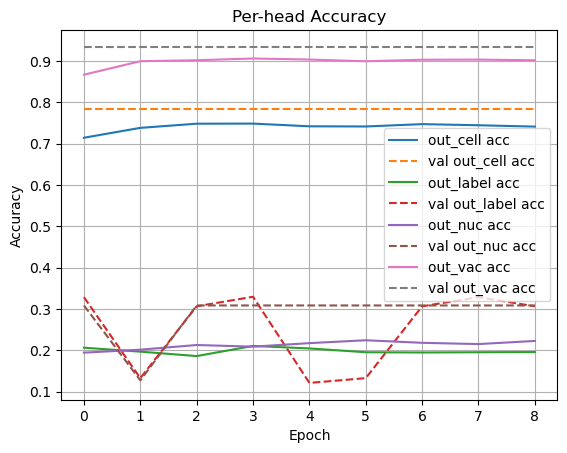

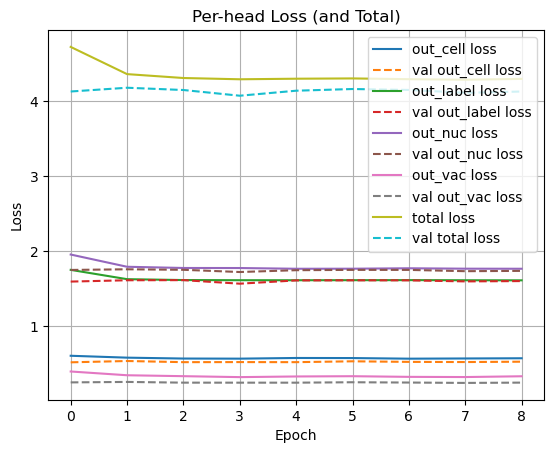

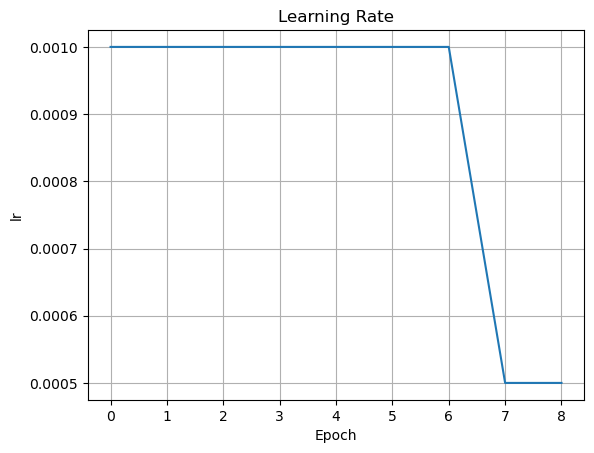

In [49]:
plot_history(history_base)

2025-08-26 09:22:25.732001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 09:22:40.080986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is


===== Classification report for out_cell =====
              precision    recall  f1-score   support

   irregular     0.0000    0.0000    0.0000       205
       round     0.7842    1.0000    0.8791       745

    accuracy                         0.7842       950
   macro avg     0.3921    0.5000    0.4395       950
weighted avg     0.6150    0.7842    0.6894       950



<Figure size 640x480 with 0 Axes>

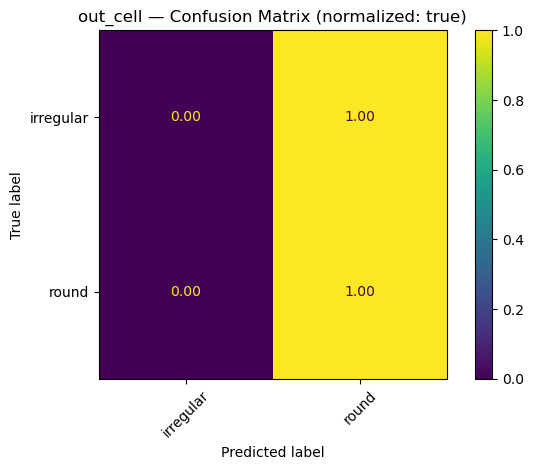


===== Classification report for out_label =====
              precision    recall  f1-score   support

    Basophil     0.0000    0.0000    0.0000       115
  Eosinophil     0.3333    0.0103    0.0200       291
  Lymphocyte     0.0000    0.0000    0.0000       106
    Monocyte     0.0000    0.0000    0.0000       126
  Neutrophil     0.3294    0.9936    0.4948       312

    accuracy                         0.3295       950
   macro avg     0.1326    0.2008    0.1030       950
weighted avg     0.2103    0.3295    0.1686       950



/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _war

<Figure size 640x480 with 0 Axes>

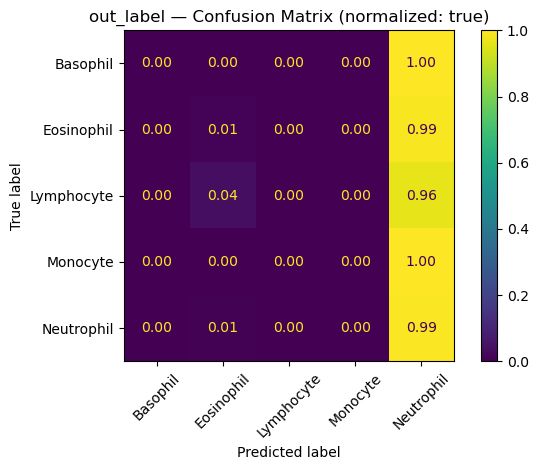


===== Classification report for out_nuc =====
                      precision    recall  f1-score   support

           irregular     0.0000    0.0000    0.0000        76
   segmented-bilobed     0.3084    1.0000    0.4714       293
segmented-multilobed     0.0000    0.0000    0.0000       117
    unsegmented-band     0.0000    0.0000    0.0000       248
unsegmented-indented     0.0000    0.0000    0.0000       121
   unsegmented-round     0.0000    0.0000    0.0000        95

            accuracy                         0.3084       950
           macro avg     0.0514    0.1667    0.0786       950
        weighted avg     0.0951    0.3084    0.1454       950



/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _war

<Figure size 640x480 with 0 Axes>

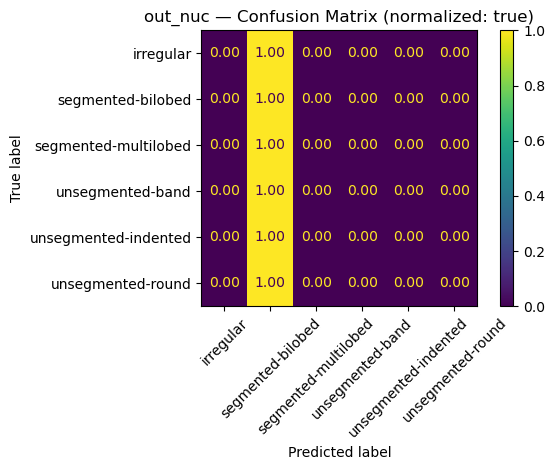


===== Classification report for out_vac =====
              precision    recall  f1-score   support

          no     0.9337    1.0000    0.9657       887
         yes     0.0000    0.0000    0.0000        63

    accuracy                         0.9337       950
   macro avg     0.4668    0.5000    0.4829       950
weighted avg     0.8718    0.9337    0.9017       950



/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _war

<Figure size 640x480 with 0 Axes>

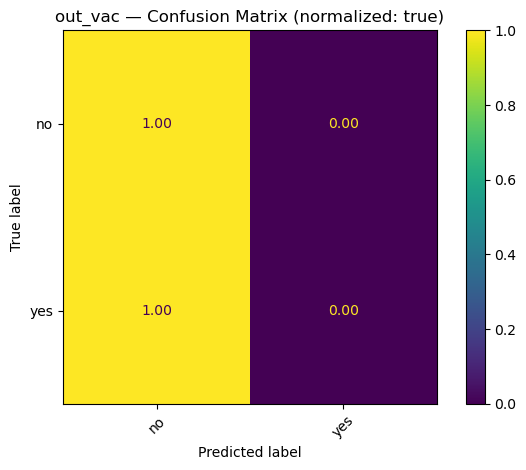

In [50]:
evaluate_heads_with_reports(
    model_base,
    blackbox_ds,                 # or test_dataset
    class_names_map=class_names_map,
    save_dir="./metrics_plots",  # optional: saves PNGs
    normalize_cm='true'          # 'true'|'pred'|'all' or False
)

## Final Model

In [52]:

# # Main model to pivot

# import tensorflow as tf

# class WbcModel(tf.keras.Model):
#     def __init__(self, num_classes = 4):
#         super().__init__()

#         #layer1
#         self.conv1 = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')
#         self.pool1 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

#         #layer2
#         self.conv2 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')
#         self.pool2 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

#         #Layer3
#         self.conv3 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')
#         self.pool3 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

#          #Layer4
#         self.conv4 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')
#         self.pool4 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)


#         #Regularization
#         self.drop = tf.keras.layers.Dropout(0.25)

#         #Head, 4 for this problem
#         # self.flat = tf.keras.layers.Flatten()

#         self.gap = tf.keras.layers.GlobalAveragePooling2D()

        
#         self.out_label = tf.keras.layers.Dense(n_label, activation='softmax',name='out_label')
#         self.out_cell = tf.keras.layers.Dense(n_cell, activation='softmax',name='out_cell')
#         self.out_nuc = tf.keras.layers.Dense(n_nuc,activation='softmax',name='out_nuc')
#         self.out_vac = tf.keras.layers.Dense(n_vac,activation='softmax',name='out_vac')

#     def call(self,x, training=False):
#         x = self.conv1(x); x = self.pool1(x)
#         x = self.conv2(x); x = self.pool2(x)
#         x = self.conv3(x); x = self.pool3(x)
#         x = self.conv4(x); x = self.pool4(x)
        

#         if training:
#             x = self.drop(x)

#         # x = self.flat(x)
#         x = self.gap(x)

#         if training:
#             x = self.drop(x)

#         return {
#             "out_label": self.out_label(x),
#             "out_cell":  self.out_cell(x),
#             "out_nuc":   self.out_nuc(x),
#             "out_vac":   self.out_vac(x)
#         }

# model = WbcModel(num_classes=4)

# model.build(input_shape=(None,224,224,3))
# model.summary()
        

        

In [51]:

# # Test -1 

# import tensorflow as tf

# from tensorflow.keras import layers, initializers



# class WbcModel(tf.keras.Model):
#     def __init__(self, num_classes = 4):
#         super().__init__()

#         #layer1
#         self.conv1 = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu',kernel_initializer=initializers.HeNormal())
#         self.pool1 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

#         #layer2
#         self.conv2 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu',kernel_initializer=initializers.HeNormal())
#         self.pool2 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

#         #Layer3
#         self.conv3 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu',kernel_initializer=initializers.HeNormal())
#         self.pool3 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

#          #Layer4
#         self.conv4 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu',kernel_initializer=initializers.HeNormal())
#         self.pool4 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)


#         #Regularization
#         self.drop = tf.keras.layers.Dropout(0.25)

#         #Head, 4 for this problem
#         # self.flat = tf.keras.layers.Flatten()

#         self.gap = tf.keras.layers.GlobalAveragePooling2D()

        
#         self.out_label = tf.keras.layers.Dense(n_label, activation='softmax',name='out_label')
#         self.out_cell = tf.keras.layers.Dense(n_cell, activation='softmax',name='out_cell')
#         self.out_nuc = tf.keras.layers.Dense(n_nuc,activation='softmax',name='out_nuc')
#         self.out_vac = tf.keras.layers.Dense(n_vac,activation='softmax',name='out_vac')

#     def call(self,x, training=False):
#         x = self.conv1(x); x = self.pool1(x)
#         x = self.conv2(x); x = self.pool2(x)
#         x = self.conv3(x); x = self.pool3(x)
#         x = self.conv4(x); x = self.pool4(x)
        

#         if training:
#             x = self.drop(x)

#         # x = self.flat(x)
#         x = self.gap(x)

#         if training:
#             x = self.drop(x)

#         return {
#             "out_label": self.out_label(x),
#             "out_cell":  self.out_cell(x),
#             "out_nuc":   self.out_nuc(x),
#             "out_vac":   self.out_vac(x)
#         }

# model = WbcModel(num_classes=4)

# model.build(input_shape=(None,224,224,3))
# model.summary()
        

        

In [49]:
# #test- 3

# import tensorflow as tf
# from tensorflow.keras import layers, initializers

# class VggWbcModel(tf.keras.Model):
#     def __init__(self, n_label, n_cell, n_nuc, n_vac):
#         super().__init__()

#         he = initializers.HeNormal()

#         # --- Block 1 (64) ---
#         self.conv11 = layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer=he)
#         self.conv12 = layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer=he)
#         self.pool1  = layers.MaxPool2D(pool_size=2, strides=2)

#         # --- Block 2 (128) ---
#         self.conv21 = layers.Conv2D(128, 3, padding='same', activation='relu', kernel_initializer=he)
#         self.conv22 = layers.Conv2D(128, 3, padding='same', activation='relu', kernel_initializer=he)
#         self.pool2  = layers.MaxPool2D(pool_size=2, strides=2)

#         # --- Block 3 (256) ---
#         self.conv31 = layers.Conv2D(256, 3, padding='same', activation='relu', kernel_initializer=he)
#         self.conv32 = layers.Conv2D(256, 3, padding='same', activation='relu', kernel_initializer=he)
#         self.pool3  = layers.MaxPool2D(pool_size=2, strides=2)

#         # --- Block 4 (256) (kept lighter than classic VGG) ---
#         self.conv41 = layers.Conv2D(256, 3, padding='same', activation='relu', kernel_initializer=he)
#         self.conv42 = layers.Conv2D(256, 3, padding='same', activation='relu', kernel_initializer=he)
#         self.pool4  = layers.MaxPool2D(pool_size=2, strides=2)

#         # --- Classifier head (VGG-style) ---
#         self.flatten = layers.Flatten()
#         self.fc1     = layers.Dense(512, activation='relu', kernel_initializer=he)
#         self.drop    = layers.Dropout(0.5)

#         # --- Outputs (4 heads) ---
#         self.out_label = layers.Dense(n_label, activation='softmax', name='out_label')
#         self.out_cell  = layers.Dense(n_cell,  activation='softmax', name='out_cell')
#         self.out_nuc   = layers.Dense(n_nuc,   activation='softmax', name='out_nuc')
#         self.out_vac   = layers.Dense(n_vac,   activation='softmax', name='out_vac')

#     def call(self, x, training=False):
#         # Block 1
#         x = self.conv11(x); x = self.conv12(x); x = self.pool1(x)
#         # Block 2
#         x = self.conv21(x); x = self.conv22(x); x = self.pool2(x)
#         # # Block 3
#         # x = self.conv31(x); x = self.conv32(x); x = self.pool3(x)
#         # # Block 4
#         # x = self.conv41(x); x = self.conv42(x); x = self.pool4(x)

#         # Classifier
#         x = self.flatten(x)
#         x = self.fc1(x)
#         x = self.drop(x, training=training)   # active only during training

#         return {
#             "out_label": self.out_label(x),
#             "out_cell":  self.out_cell(x),
#             "out_nuc":   self.out_nuc(x),
#             "out_vac":   self.out_vac(x)
#         }

# # --- build & summary (keeps your style) ---
# model = VggWbcModel(n_label, n_cell, n_nuc, n_vac)
# model.build(input_shape=(None, 224, 224, 3))
# model.summary()


In [35]:
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(1e-3),
#     loss={
#         'out_label': 'categorical_crossentropy',
#         'out_cell':  'categorical_crossentropy',
#         'out_nuc':   'categorical_crossentropy',
#         'out_vac':   'categorical_crossentropy',
#     },
#     loss_weights={'out_label': 1.0, 'out_cell': 0.7, 'out_nuc': 0.7, 'out_vac': 0.7},
#     metrics={k: ['accuracy'] for k in ['out_label','out_cell','out_nuc','out_vac']}
# )

## Model with hyper parameter tunning capability 

In [40]:
# =========================
# 1) Model with knobs
# =========================
import tensorflow as tf
from tensorflow.keras import regularizers

class WbcModel(tf.keras.Model):
    def __init__(self,
                 n_label, n_cell, n_nuc, n_vac,
                 filters_scale=1.0,
                 kernel_size=3,
                 dropout=0.25,
                 l2=0.0):
        super().__init__()
        reg = regularizers.l2(l2) if l2 and l2 > 0 else None
        k   = int(kernel_size)
        fs  = float(filters_scale)

        # Conv blocks (scaled filters, tunable kernel size + L2)
        self.conv1 = tf.keras.layers.Conv2D(int(32*fs), k, padding='same', activation='relu', kernel_regularizer=reg)
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

        self.conv2 = tf.keras.layers.Conv2D(int(64*fs), k, padding='same', activation='relu', kernel_regularizer=reg)
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

        self.conv3 = tf.keras.layers.Conv2D(int(128*fs), k, padding='same', activation='relu', kernel_regularizer=reg)
        self.pool3 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

        self.conv4 = tf.keras.layers.Conv2D(int(256*fs), k, padding='same', activation='relu', kernel_regularizer=reg)
        self.pool4 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

        self.drop = tf.keras.layers.Dropout(dropout)
        self.gap  = tf.keras.layers.GlobalAveragePooling2D()

        # Multi-head outputs (unchanged)
        self.out_label = tf.keras.layers.Dense(n_label, activation='softmax', name='out_label')
        self.out_cell  = tf.keras.layers.Dense(n_cell,  activation='softmax', name='out_cell')
        self.out_nuc   = tf.keras.layers.Dense(n_nuc,   activation='softmax', name='out_nuc')
        self.out_vac   = tf.keras.layers.Dense(n_vac,   activation='softmax', name='out_vac')

    def call(self, x, training=False):
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = self.pool3(self.conv3(x))
        x = self.pool4(self.conv4(x))
        if training: x = self.drop(x)
        x = self.gap(x)
        if training: x = self.drop(x)
        return {
            "out_label": self.out_label(x),
            "out_cell":  self.out_cell(x),
            "out_nuc":   self.out_nuc(x),
            "out_vac":   self.out_vac(x)
        }

# (optional) quick build check
m = WbcModel(n_label, n_cell, n_nuc, n_vac); m.build((None,224,224,3)); m.summary()


Model: "wbc_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  896       
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           multiple                  18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           multiple                  73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  multiple                  0 

## Hyper parameter tunning

In [58]:
# =========================
# 2) F1 evaluator for val set
# =========================
from sklearn.metrics import f1_score
import numpy as np

def evaluate_f1_on_val(model, val_ds, head="out_label"):
    """Computes F1-macro and F1-weighted over the validation dataset for a single head."""
    y_true, y_pred = [], []
    for x, y in val_ds:
        preds = model.predict(x, verbose=0)          # dict of heads
        pred_ids = np.argmax(preds[head], axis=1)     # predicted classes
        true_ids = np.argmax(y[head], axis=1)         # true classes (one-hot -> ids)
        y_pred.extend(pred_ids)
        y_true.extend(true_ids)
    f1_macro    = f1_score(y_true, y_pred, average="macro")
    f1_weighted = f1_score(y_true, y_pred, average="weighted")
    return f1_macro, f1_weighted


In [49]:
# =========================
# 3) Tuning harness (A1 LR → B1 Dropout → B2 L2 → C1 Kernel)
# =========================
import csv, tensorflow as tf
tf.random.set_seed(42)

RESULTS_CSV = "tuning_results.csv"
FIXED_BATCH = 32  # just for naming clarity (datasets unchanged)

def make_model(hp):
    """Factory for a model using hyperparameters dict hp."""
    m = WbcModel(
        n_label=n_label, n_cell=n_cell, n_nuc=n_nuc, n_vac=n_vac,
        filters_scale=hp.get("filters_scale", 1.0),
        kernel_size=hp.get("kernel_size", 3),
        dropout=hp.get("dropout", 0.25),
        l2=hp.get("l2", 0.0)
    )
    m.build(input_shape=(None,224,224,3))
    return m

In [59]:
def run_trial(hp, tag):
    """Train one trial and return (val_acc_best, f1_macro, f1_weighted, run_name)."""
    lr  = float(hp["lr"])
    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    run_name = (
        f"{tag}_lr{lr}_bs{FIXED_BATCH}_do{hp.get('dropout',0.25)}_l2{hp.get('l2',0.0)}"
        + (f"_ks{hp['kernel_size']}" if 'kernel_size' in hp else "")
    ).replace(".","p")

    # Build model once, then fit so we can evaluate the trained instance
    model = make_model(hp)
    hist = compile_and_fit(
        model=model,
        name=run_name,
        optimizer=opt,
        max_epochs=MAX_EPOCH
    )

    # Best validation accuracy (from training logs)
    val_acc_best = float(max(hist.history.get("val_out_label_accuracy", [0.0])))

    # Validation F1 scores on the same trained model
    f1_macro, f1_weighted = evaluate_f1_on_val(model, blackbox_ds, head="out_label")

    return val_acc_best, f1_macro, f1_weighted, run_name

# ---- collect results here
results = []

# -------- Phase A1 — LR sweep --------
A1_space  = [{"lr": v} for v in [1e-4, 3e-4, 1e-3, 3e-3, 1e-2]]
A1_scores = []
for hp in A1_space:
    acc, f1m, f1w, run = run_trial(hp, "A1")
    A1_scores.append((f1m, hp))
    results.append({
        "phase":"A1", "lr":hp["lr"], "dropout":None, "l2":None, "kernel_size":None,
        "val_acc_best":acc, "val_f1_macro":f1m, "val_f1_weighted":f1w, "run":run
    })
best_lr = max(A1_scores, key=lambda t: t[0])[1]["lr"]

# -------- Phase B1 — Dropout sweep (hold best LR) --------
B1_space  = [{"lr":best_lr, "dropout":d} for d in [0.2, 0.3, 0.5]]
B1_scores = []
for hp in B1_space:
    acc, f1m, f1w, run = run_trial(hp, "B1")
    B1_scores.append((f1m, hp))
    results.append({
        "phase":"B1", "lr":hp["lr"], "dropout":hp["dropout"], "l2":None, "kernel_size":None,
        "val_acc_best":acc, "val_f1_macro":f1m, "val_f1_weighted":f1w, "run":run
    })
best_do = max(B1_scores, key=lambda t: t[0])[1]["dropout"]

# -------- Phase B2 — L2 sweep (hold best LR & Dropout) --------
B2_space  = [{"lr":best_lr, "dropout":best_do, "l2":l2} for l2 in [0.0, 1e-4, 1e-3]]
B2_scores = []
for hp in B2_space:
    acc, f1m, f1w, run = run_trial(hp, "B2")
    B2_scores.append((f1m, hp))
    results.append({
        "phase":"B2", "lr":hp["lr"], "dropout":hp["dropout"], "l2":hp["l2"], "kernel_size":None,
        "val_acc_best":acc, "val_f1_macro":f1m, "val_f1_weighted":f1w, "run":run
    })
best_l2 = max(B2_scores, key=lambda t: t[0])[1]["l2"]

# -------- Phase C1 — Kernel size sweep --------
C1_space  = [{"lr":best_lr, "dropout":best_do, "l2":best_l2, "kernel_size":k} for k in [3, 5]]
C1_scores = []
for hp in C1_space:
    acc, f1m, f1w, run = run_trial(hp, "C1")
    C1_scores.append((f1m, hp))
    results.append({
        "phase":"C1", "lr":hp["lr"], "dropout":hp["dropout"], "l2":hp["l2"], "kernel_size":hp["kernel_size"],
        "val_acc_best":acc, "val_f1_macro":f1m, "val_f1_weighted":f1w, "run":run
    })
best_kernel = max(C1_scores, key=lambda t: t[0])[1]["kernel_size"]

# Final chosen HPs
best_hp = {"lr": best_lr, "dropout": best_do, "l2": best_l2, "kernel_size": best_kernel}
print("BEST HP (by F1-macro):", best_hp)

# -------- Save all trials to CSV --------
if results:
    fieldnames = ["phase","lr","dropout","l2","kernel_size","val_acc_best","val_f1_macro","val_f1_weighted","run"]
    with open(RESULTS_CSV, "w", newline="") as f:
        w = csv.DictWriter(f, fieldnames=fieldnames)
        w.writeheader()
        w.writerows(results)
    print(f"✅ Saved all trials to {RESULTS_CSV}")

Epoch 1/40


2025-08-30 10:59:02.959521: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inwbc_model_2/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - 58s 436ms/step - loss: 4.0201 - out_cell_loss: 0.5721 - out_label_loss: 1.6146 - out_nuc_loss: 1.7685 - out_vac_loss: 0.3380 - out_cell_accuracy: 0.7490 - out_label_accuracy: 0.2010 - out_nuc_accuracy: 0.2240 - out_vac_accuracy: 0.9018 - val_loss: 3.8878 - val_out_cell_loss: 0.5241 - val_out_label_loss: 1.6109 - val_out_nuc_loss: 1.7342 - val_out_vac_loss: 0.2512 - val_out_cell_accuracy: 0.7842 - val_out_label_accuracy: 0.1326 - val_out_nuc_accuracy: 0.3084 - val_out_vac_accuracy: 0.9337
Epoch 2/40
125/125 [==============================] - 53s 424ms/step - loss: 4.0277 - out_cell_loss: 0.5816 - out_label_loss: 1.6151 - out_nuc_loss: 1.7722 - out_vac_loss: 0.3332 - out_cell_accuracy: 0.7374 - out_label_accuracy: 0.1964 - out_nuc_accuracy: 0.2088 - out_vac_accuracy: 0.8984 - val_loss: 3.9035 - val_out_cell_loss: 0.5228 - val_out_label_loss: 1.6162 - val_out_nuc_loss: 1.7483 - val_out_vac_loss: 0.2472 - val_out_cell_accuracy: 0.7842 - val_out_la

2025-08-30 11:34:40.841713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-30 11:34:43.310018: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inwbc_model_3/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - 57s 434ms/step - loss: 4.0353 - out_cell_loss: 0.5734 - out_label_loss: 1.6202 - out_nuc_loss: 1.7771 - out_vac_loss: 0.3380 - out_cell_accuracy: 0.7465 - out_label_accuracy: 0.1893 - out_nuc_accuracy: 0.2095 - out_vac_accuracy: 0.8953 - val_loss: 3.8856 - val_out_cell_loss: 0.5259 - val_out_label_loss: 1.5955 - val_out_nuc_loss: 1.7476 - val_out_vac_loss: 0.2492 - val_out_cell_accuracy: 0.7842 - val_out_label_accuracy: 0.3063 - val_out_nuc_accuracy: 0.3084 - val_out_vac_accuracy: 0.9337
Epoch 2/40
125/125 [==============================] - 53s 425ms/step - loss: 3.9705 - out_cell_loss: 0.5636 - out_label_loss: 1.5940 - out_nuc_loss: 1.7652 - out_vac_loss: 0.3097 - out_cell_accuracy: 0.7435 - out_label_accuracy: 0.2417 - out_nuc_accuracy: 0.2138 - out_vac_accuracy: 0.9024 - val_loss: 3.7909 - val_out_cell_loss: 0.5061 - val_out_label_loss: 1.5595 - val_out_nuc_loss: 1.7215 - val_out_vac_loss: 0.2224 - val_out_cell_accuracy: 0.7842 - val_out_la

2025-08-30 12:10:19.009579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-30 12:10:21.517435: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inwbc_model_4/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - 57s 432ms/step - loss: 4.0152 - out_cell_loss: 0.5717 - out_label_loss: 1.6124 - out_nuc_loss: 1.7741 - out_vac_loss: 0.3264 - out_cell_accuracy: 0.7430 - out_label_accuracy: 0.2013 - out_nuc_accuracy: 0.2145 - out_vac_accuracy: 0.9003 - val_loss: 3.8964 - val_out_cell_loss: 0.5114 - val_out_label_loss: 1.6163 - val_out_nuc_loss: 1.7598 - val_out_vac_loss: 0.2319 - val_out_cell_accuracy: 0.7842 - val_out_label_accuracy: 0.1211 - val_out_nuc_accuracy: 0.3084 - val_out_vac_accuracy: 0.9337
Epoch 2/40
125/125 [==============================] - 53s 426ms/step - loss: 3.9482 - out_cell_loss: 0.5606 - out_label_loss: 1.5828 - out_nuc_loss: 1.7611 - out_vac_loss: 0.3026 - out_cell_accuracy: 0.7432 - out_label_accuracy: 0.2563 - out_nuc_accuracy: 0.2299 - out_vac_accuracy: 0.8996 - val_loss: 3.7603 - val_out_cell_loss: 0.5038 - val_out_label_loss: 1.5449 - val_out_nuc_loss: 1.7218 - val_out_vac_loss: 0.2013 - val_out_cell_accuracy: 0.7842 - val_out_la

2025-08-30 12:45:52.459435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-30 12:45:54.924232: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inwbc_model_5/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - 57s 431ms/step - loss: 4.0255 - out_cell_loss: 0.5725 - out_label_loss: 1.6169 - out_nuc_loss: 1.7753 - out_vac_loss: 0.3322 - out_cell_accuracy: 0.7473 - out_label_accuracy: 0.1922 - out_nuc_accuracy: 0.2077 - out_vac_accuracy: 0.8980 - val_loss: 3.9092 - val_out_cell_loss: 0.5216 - val_out_label_loss: 1.6219 - val_out_nuc_loss: 1.7511 - val_out_vac_loss: 0.2444 - val_out_cell_accuracy: 0.7842 - val_out_label_accuracy: 0.1211 - val_out_nuc_accuracy: 0.3084 - val_out_vac_accuracy: 0.9337
Epoch 2/40
125/125 [==============================] - 53s 425ms/step - loss: 4.0149 - out_cell_loss: 0.5765 - out_label_loss: 1.6132 - out_nuc_loss: 1.7651 - out_vac_loss: 0.3327 - out_cell_accuracy: 0.7402 - out_label_accuracy: 0.1959 - out_nuc_accuracy: 0.2163 - out_vac_accuracy: 0.8986 - val_loss: 3.9293 - val_out_cell_loss: 0.5221 - val_out_label_loss: 1.6271 - val_out_nuc_loss: 1.7649 - val_out_vac_loss: 0.2454 - val_out_cell_accuracy: 0.7842 - val_out_la

2025-08-30 13:07:12.292950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-30 13:07:14.772772: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inwbc_model_6/dropout_7/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - 57s 431ms/step - loss: 4.3544 - out_cell_loss: 0.6747 - out_label_loss: 1.6643 - out_nuc_loss: 1.9246 - out_vac_loss: 0.4188 - out_cell_accuracy: 0.7370 - out_label_accuracy: 0.2097 - out_nuc_accuracy: 0.2007 - out_vac_accuracy: 0.8997 - val_loss: 3.8799 - val_out_cell_loss: 0.5261 - val_out_label_loss: 1.6050 - val_out_nuc_loss: 1.7260 - val_out_vac_loss: 0.2581 - val_out_cell_accuracy: 0.7842 - val_out_label_accuracy: 0.1211 - val_out_nuc_accuracy: 0.3084 - val_out_vac_accuracy: 0.9337
Epoch 2/40
125/125 [==============================] - 53s 425ms/step - loss: 3.9972 - out_cell_loss: 0.5633 - out_label_loss: 1.6133 - out_nuc_loss: 1.7659 - out_vac_loss: 0.3195 - out_cell_accuracy: 0.7510 - out_label_accuracy: 0.1987 - out_nuc_accuracy: 0.2276 - out_vac_accuracy: 0.9044 - val_loss: 3.9037 - val_out_cell_loss: 0.5301 - val_out_label_loss: 1.6158 - val_out_nuc_loss: 1.7406 - val_out_vac_loss: 0.2516 - val_out_cell_accuracy: 0.7842 - val_out_la

2025-08-30 13:32:57.959948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-30 13:33:00.447395: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inwbc_model_7/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - 57s 432ms/step - loss: 4.0260 - out_cell_loss: 0.5769 - out_label_loss: 1.6173 - out_nuc_loss: 1.7735 - out_vac_loss: 0.3307 - out_cell_accuracy: 0.7427 - out_label_accuracy: 0.2055 - out_nuc_accuracy: 0.2195 - out_vac_accuracy: 0.9047 - val_loss: 3.9112 - val_out_cell_loss: 0.5215 - val_out_label_loss: 1.6278 - val_out_nuc_loss: 1.7424 - val_out_vac_loss: 0.2513 - val_out_cell_accuracy: 0.7842 - val_out_label_accuracy: 0.1211 - val_out_nuc_accuracy: 0.3084 - val_out_vac_accuracy: 0.9337
Epoch 2/40
125/125 [==============================] - 53s 424ms/step - loss: 4.0023 - out_cell_loss: 0.5667 - out_label_loss: 1.6104 - out_nuc_loss: 1.7643 - out_vac_loss: 0.3297 - out_cell_accuracy: 0.7462 - out_label_accuracy: 0.2045 - out_nuc_accuracy: 0.2261 - out_vac_accuracy: 0.8961 - val_loss: 3.8478 - val_out_cell_loss: 0.5273 - val_out_label_loss: 1.5756 - val_out_nuc_loss: 1.7336 - val_out_vac_loss: 0.2421 - val_out_cell_accuracy: 0.7842 - val_out_la

2025-08-30 14:08:30.390957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-30 14:08:32.834781: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inwbc_model_8/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - 57s 434ms/step - loss: 4.0414 - out_cell_loss: 0.5783 - out_label_loss: 1.6166 - out_nuc_loss: 1.7795 - out_vac_loss: 0.3435 - out_cell_accuracy: 0.7440 - out_label_accuracy: 0.1985 - out_nuc_accuracy: 0.2153 - out_vac_accuracy: 0.8925 - val_loss: 3.9288 - val_out_cell_loss: 0.5406 - val_out_label_loss: 1.6097 - val_out_nuc_loss: 1.7533 - val_out_vac_loss: 0.2677 - val_out_cell_accuracy: 0.7842 - val_out_label_accuracy: 0.1211 - val_out_nuc_accuracy: 0.3084 - val_out_vac_accuracy: 0.9337
Epoch 2/40
125/125 [==============================] - 53s 424ms/step - loss: 3.9698 - out_cell_loss: 0.5615 - out_label_loss: 1.5980 - out_nuc_loss: 1.7613 - out_vac_loss: 0.3106 - out_cell_accuracy: 0.7440 - out_label_accuracy: 0.2422 - out_nuc_accuracy: 0.2294 - out_vac_accuracy: 0.9032 - val_loss: 3.8474 - val_out_cell_loss: 0.5084 - val_out_label_loss: 1.5849 - val_out_nuc_loss: 1.7498 - val_out_vac_loss: 0.2242 - val_out_cell_accuracy: 0.7842 - val_out_la

2025-08-30 14:44:00.602366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-30 14:44:03.099691: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inwbc_model_9/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - 57s 434ms/step - loss: 4.0322 - out_cell_loss: 0.5730 - out_label_loss: 1.6223 - out_nuc_loss: 1.7782 - out_vac_loss: 0.3295 - out_cell_accuracy: 0.7448 - out_label_accuracy: 0.2042 - out_nuc_accuracy: 0.2160 - out_vac_accuracy: 0.9020 - val_loss: 3.8627 - val_out_cell_loss: 0.5274 - val_out_label_loss: 1.5841 - val_out_nuc_loss: 1.7309 - val_out_vac_loss: 0.2551 - val_out_cell_accuracy: 0.7842 - val_out_label_accuracy: 0.3063 - val_out_nuc_accuracy: 0.3084 - val_out_vac_accuracy: 0.9337
Epoch 2/40
125/125 [==============================] - 53s 424ms/step - loss: 4.0139 - out_cell_loss: 0.5727 - out_label_loss: 1.6117 - out_nuc_loss: 1.7698 - out_vac_loss: 0.3308 - out_cell_accuracy: 0.7457 - out_label_accuracy: 0.2055 - out_nuc_accuracy: 0.2095 - out_vac_accuracy: 0.9007 - val_loss: 3.8493 - val_out_cell_loss: 0.5212 - val_out_label_loss: 1.5768 - val_out_nuc_loss: 1.7351 - val_out_vac_loss: 0.2465 - val_out_cell_accuracy: 0.7842 - val_out_la

2025-08-30 15:19:31.535754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-30 15:19:34.481510: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inwbc_model_10/dropout_11/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - 57s 432ms/step - loss: 4.0273 - out_cell_loss: 0.5790 - out_label_loss: 1.6184 - out_nuc_loss: 1.7733 - out_vac_loss: 0.3291 - out_cell_accuracy: 0.7415 - out_label_accuracy: 0.1972 - out_nuc_accuracy: 0.2115 - out_vac_accuracy: 0.9003 - val_loss: 3.8987 - val_out_cell_loss: 0.5260 - val_out_label_loss: 1.6145 - val_out_nuc_loss: 1.7445 - val_out_vac_loss: 0.2449 - val_out_cell_accuracy: 0.7842 - val_out_label_accuracy: 0.3063 - val_out_nuc_accuracy: 0.3084 - val_out_vac_accuracy: 0.9337
Epoch 2/40
125/125 [==============================] - 53s 426ms/step - loss: 3.9848 - out_cell_loss: 0.5663 - out_label_loss: 1.6013 - out_nuc_loss: 1.7676 - out_vac_loss: 0.3136 - out_cell_accuracy: 0.7465 - out_label_accuracy: 0.2321 - out_nuc_accuracy: 0.2211 - out_vac_accuracy: 0.9039 - val_loss: 3.7991 - val_out_cell_loss: 0.5172 - val_out_label_loss: 1.5611 - val_out_nuc_loss: 1.7102 - val_out_vac_loss: 0.2367 - val_out_cell_accuracy: 0.7842 - val_out_la

2025-08-30 15:55:03.331769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-30 15:55:05.866408: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inwbc_model_11/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - 57s 434ms/step - loss: 4.0391 - out_cell_loss: 0.5746 - out_label_loss: 1.6176 - out_nuc_loss: 1.7719 - out_vac_loss: 0.3303 - out_cell_accuracy: 0.7465 - out_label_accuracy: 0.1998 - out_nuc_accuracy: 0.2138 - out_vac_accuracy: 0.8965 - val_loss: 3.9053 - val_out_cell_loss: 0.5209 - val_out_label_loss: 1.6274 - val_out_nuc_loss: 1.7297 - val_out_vac_loss: 0.2451 - val_out_cell_accuracy: 0.7842 - val_out_label_accuracy: 0.1211 - val_out_nuc_accuracy: 0.3084 - val_out_vac_accuracy: 0.9337
Epoch 2/40
125/125 [==============================] - 54s 428ms/step - loss: 4.0338 - out_cell_loss: 0.5768 - out_label_loss: 1.6155 - out_nuc_loss: 1.7678 - out_vac_loss: 0.3372 - out_cell_accuracy: 0.7404 - out_label_accuracy: 0.1901 - out_nuc_accuracy: 0.2188 - out_vac_accuracy: 0.8979 - val_loss: 3.8862 - val_out_cell_loss: 0.5224 - val_out_label_loss: 1.6028 - val_out_nuc_loss: 1.7343 - val_out_vac_loss: 0.2482 - val_out_cell_accuracy: 0.7842 - val_out_la

2025-08-30 16:30:39.592214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-30 16:30:42.082522: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inwbc_model_12/dropout_13/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - 57s 431ms/step - loss: 4.1323 - out_cell_loss: 0.5826 - out_label_loss: 1.6161 - out_nuc_loss: 1.7657 - out_vac_loss: 0.3370 - out_cell_accuracy: 0.7372 - out_label_accuracy: 0.2000 - out_nuc_accuracy: 0.2183 - out_vac_accuracy: 0.8955 - val_loss: 3.9198 - val_out_cell_loss: 0.5281 - val_out_label_loss: 1.5982 - val_out_nuc_loss: 1.7231 - val_out_vac_loss: 0.2475 - val_out_cell_accuracy: 0.7842 - val_out_label_accuracy: 0.3284 - val_out_nuc_accuracy: 0.3084 - val_out_vac_accuracy: 0.9337
Epoch 2/40
125/125 [==============================] - 53s 422ms/step - loss: 4.0625 - out_cell_loss: 0.5729 - out_label_loss: 1.6139 - out_nuc_loss: 1.7745 - out_vac_loss: 0.3289 - out_cell_accuracy: 0.7432 - out_label_accuracy: 0.1904 - out_nuc_accuracy: 0.2143 - out_vac_accuracy: 0.9002 - val_loss: 3.9262 - val_out_cell_loss: 0.5253 - val_out_label_loss: 1.6048 - val_out_nuc_loss: 1.7450 - val_out_vac_loss: 0.2508 - val_out_cell_accuracy: 0.7842 - val_out_la

2025-08-30 17:03:29.886923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-30 17:03:32.357332: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inwbc_model_13/dropout_14/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - 57s 431ms/step - loss: 4.0218 - out_cell_loss: 0.5715 - out_label_loss: 1.6188 - out_nuc_loss: 1.7717 - out_vac_loss: 0.3303 - out_cell_accuracy: 0.7485 - out_label_accuracy: 0.1925 - out_nuc_accuracy: 0.2268 - out_vac_accuracy: 0.9018 - val_loss: 3.8962 - val_out_cell_loss: 0.5205 - val_out_label_loss: 1.6040 - val_out_nuc_loss: 1.7523 - val_out_vac_loss: 0.2509 - val_out_cell_accuracy: 0.7842 - val_out_label_accuracy: 0.1116 - val_out_nuc_accuracy: 0.3084 - val_out_vac_accuracy: 0.9337
Epoch 2/40
125/125 [==============================] - 53s 423ms/step - loss: 4.0104 - out_cell_loss: 0.5749 - out_label_loss: 1.6121 - out_nuc_loss: 1.7670 - out_vac_loss: 0.3271 - out_cell_accuracy: 0.7420 - out_label_accuracy: 0.2045 - out_nuc_accuracy: 0.2082 - out_vac_accuracy: 0.9022 - val_loss: 3.9265 - val_out_cell_loss: 0.5252 - val_out_label_loss: 1.6260 - val_out_nuc_loss: 1.7595 - val_out_vac_loss: 0.2477 - val_out_cell_accuracy: 0.7842 - val_out_la

2025-08-30 17:39:07.934850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-30 17:39:10.452149: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inwbc_model_14/dropout_15/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - 61s 466ms/step - loss: 4.0370 - out_cell_loss: 0.5719 - out_label_loss: 1.6205 - out_nuc_loss: 1.7777 - out_vac_loss: 0.3407 - out_cell_accuracy: 0.7460 - out_label_accuracy: 0.1880 - out_nuc_accuracy: 0.2202 - out_vac_accuracy: 0.8932 - val_loss: 3.9204 - val_out_cell_loss: 0.5265 - val_out_label_loss: 1.6044 - val_out_nuc_loss: 1.7547 - val_out_vac_loss: 0.2754 - val_out_cell_accuracy: 0.7842 - val_out_label_accuracy: 0.1211 - val_out_nuc_accuracy: 0.3084 - val_out_vac_accuracy: 0.9337
Epoch 2/40
125/125 [==============================] - 57s 460ms/step - loss: 4.0119 - out_cell_loss: 0.5719 - out_label_loss: 1.6145 - out_nuc_loss: 1.7683 - out_vac_loss: 0.3268 - out_cell_accuracy: 0.7452 - out_label_accuracy: 0.1934 - out_nuc_accuracy: 0.2133 - out_vac_accuracy: 0.9042 - val_loss: 3.9189 - val_out_cell_loss: 0.5250 - val_out_label_loss: 1.6115 - val_out_nuc_loss: 1.7620 - val_out_vac_loss: 0.2541 - val_out_cell_accuracy: 0.7842 - val_out_la

2025-08-30 18:01:58.291431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [60]:
# =========================
# 4) Trial-count summary + CSV sanity check
# =========================
A1_count = len(A1_space)
B1_count = len(B1_space)
B2_count = len(B2_space)
C1_count = len(C1_space)
total_trials = A1_count + B1_count + B2_count + C1_count

print("\n================ TUNING SUMMARY ================")
print(f"Phase A1 (LR sweep):       {A1_count} trials")
print(f"Phase B1 (Dropout sweep):  {B1_count} trials")
print(f"Phase B2 (L2 sweep):       {B2_count} trials")
print(f"Phase C1 (Kernel sweep):   {C1_count} trials")
print("-----------------------------------------------")
print(f"TOTAL trials:              {total_trials}")
print("================================================\n")

try:
    with open(RESULTS_CSV, "r") as f:
        csv_rows = sum(1 for _ in f) - 1  # minus header
    print(f"CSV rows (excluding header): {csv_rows}")
    if csv_rows != total_trials:
        print("⚠️  Note: CSV row count != total trials (did a phase get skipped or exit early?).")
except Exception as e:
    print(f"(CSV check skipped: {e})")



================ TUNING SUMMARY ================
Phase A1 (LR sweep):       5 trials
Phase B1 (Dropout sweep):  3 trials
Phase B2 (L2 sweep):       3 trials
Phase C1 (Kernel sweep):   2 trials
-----------------------------------------------
TOTAL trials:              13

CSV rows (excluding header): 13


In [41]:
import pandas as pd

df = pd.read_csv("tuning_results.csv")

# Find the best trial by F1-macro
best_row = df.loc[df["val_f1_macro"].idxmax()]

best_hp = {
    "lr": best_row["lr"],
    "dropout": best_row["dropout"],
    "l2": best_row["l2"],
    "kernel_size": best_row["kernel_size"]
}

print("Recovered best_hp:", best_hp)


Recovered best_hp: {'lr': 0.001, 'dropout': 0.2, 'l2': 0.0, 'kernel_size': 3.0}


In [64]:
# BATCH_SIZE = 32
N_TRAIN = len(train_df)

MAX_EPOCH = 40

STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate =1,
    staircase=False
)


# # Callback: Reduce LR when val_loss stops improving
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor="val_loss",   # or "val_out_label_loss" if you want to target a specific head
#     mode="min",           # because we want to minimize loss
#     factor=0.5,           # new_lr = old_lr * 0.5
#     patience=5,           # wait 5 epochs with no improvement
#     cooldown=2,           # small break before resuming monitoring
#     min_lr=1e-6,          # don’t go lower than this
#     verbose=1             # print updates
# )





In [57]:
# import tensorflow as tf

# def num_batches(ds):
#     card = tf.data.experimental.cardinality(ds).numpy()
#     if card == tf.data.INFINITE_CARDINALITY:
#         raise ValueError("Dataset repeats indefinitely; set steps_per_epoch manually or remove .repeat().")
#     return int(card)

# STEPS_PER_EPOCH = num_batches(train_ds)
# VALIDATION_STEPS = num_batches(blackbox_ds)

In [65]:
print(N_TRAIN)

4000


In [66]:
# from sklearn.metrics import f1_score
# import numpy as np
# import tensorflow as tf

# class F1Callback(tf.keras.callbacks.Callback):
#     def __init__(self, val_data, head="out_label"):
#         super().__init__()
#         self.val_data = val_data
#         self.head = head  # which output head to compute F1 on

#     def on_epoch_end(self, epoch, logs=None):
#         y_true, y_pred = [], []

#         for x, y in self.val_data:
#             preds = self.model.predict(x, verbose=0)
#             pred_ids = np.argmax(preds[self.head], axis=1)
#             true_ids = np.argmax(y[self.head], axis=1)
#             y_pred.extend(pred_ids)
#             y_true.extend(true_ids)

#         f1_macro = f1_score(y_true, y_pred, average="macro")
#         f1_weighted = f1_score(y_true, y_pred, average="weighted")

#         # add to logs so it shows in history
#         logs = logs or {}
#         logs["val_f1_macro"] = f1_macro
#         logs["val_f1_weighted"] = f1_weighted

#         print(f"\nEpoch {epoch+1}: val_f1_macro={f1_macro:.4f}, val_f1_weighted={f1_weighted:.4f}")






from sklearn.metrics import f1_score
import numpy as np
import tensorflow as tf

class F1Callback(tf.keras.callbacks.Callback):
    def __init__(self, val_data, head="out_label"):
        super().__init__()
        self.val_data = val_data
        self.head = head  # which output head to compute F1 on

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        # Predict all validation data in one go
        preds = self.model.predict(self.val_data, verbose=0)
        preds = preds[self.head]  # select the correct output head

        # Collect ground truth
        y_true = np.concatenate([np.argmax(y[self.head], axis=1) for _, y in self.val_data])
        y_pred = np.argmax(preds, axis=1)

        # Compute F1 scores
        f1_macro = f1_score(y_true, y_pred, average="macro")
        f1_weighted = f1_score(y_true, y_pred, average="weighted")

        # Add to logs so History records it
        logs["val_f1_macro"] = f1_macro
        logs["val_f1_weighted"] = f1_weighted

        print(f"\nEpoch {epoch+1}: val_f1_macro={f1_macro:.4f}, val_f1_weighted={f1_weighted:.4f}")



In [67]:
# from pathlib import Path

# def get_callbacks(name):
#     logdir = Path("logs") / name
#     return [
#         tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20),
#         tf.keras.callbacks.TensorBoard(log_dir=str(logdir))
#     ]



from pathlib import Path
import json, tensorflow as tf

def get_callbacks(name, params=None):
    logdir = Path("logs") / name
    run_dir = Path("runs") / name
    run_dir.mkdir(parents=True, exist_ok=True)

    # save training params
    if params:
        with open(run_dir / "params.json", "w") as f:
            json.dump(params, f, indent=2)

    return [
        F1Callback(val_data=blackbox_ds, head="out_label"),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_f1_macro',
            mode="max",
            patience=10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.TensorBoard(log_dir=str(logdir)),
        tf.keras.callbacks.CSVLogger(str(run_dir / "history.csv"), append=False),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=str(run_dir / "best.weights"),
            monitor="val_f1_macro",
            mode="max",
            save_best_only=True,
            save_weights_only=True  # <- important for subclassed models
        ),
        tf.keras.callbacks.CSVLogger(str(run_dir / "history.csv")),
        tf.keras.callbacks.TensorBoard(log_dir=str(logdir)),
        # tf.keras.callbacks.ReduceLROnPlateau(monitor="val_f1_macro", factor=0.5, patience=5)
    ]






In [68]:
# from pathlib import Path
# import tensorflow as tf
# import time


# def _lr_value(opt):
#     try:
#         lr = opt.learning_rate
#         return float(tf.keras.backend.get_value(lr(0))) if callable(lr) else float(tf.keras.backend.get_value(lr))
#     except:
#         return None

# def compile_and_fit(model, name, optimizer=None, max_epochs=MAX_EPOCH):
#     if "%TIME%" in name:
#         name = name.replace("%TIME%", time.strftime("%Y%m%d-%H%M%S"))

#     if optimizer is None:
#         optimizer = tf.keras.optimizers.Adam(lr_schedule)

#     model.compile(
#         optimizer=optimizer,
#         loss={
#             'out_label': 'categorical_crossentropy',
#             'out_cell':  'categorical_crossentropy',
#             'out_nuc':   'categorical_crossentropy',
#             'out_vac':   'categorical_crossentropy',
#         },
#         loss_weights={'out_label': 1.0, 'out_cell': 0.7, 'out_nuc': 0.7, 'out_vac': 0.7},
#         metrics={k: ['accuracy'] for k in ['out_label','out_cell','out_nuc','out_vac']}
#     )

#     params = {
#         "epochs": int(max_epochs),
#         "steps_per_epoch": int(STEPS_PER_EPOCH),
#         "optimizer": optimizer.__class__.__name__,
#         "learning_rate": _lr_value(optimizer),
#         "loss_weights": {'out_label': 1.0, 'out_cell': 0.7, 'out_nuc': 0.7, 'out_vac': 0.7},
#     }

#     history = model.fit(
#         train_ds,
#         steps_per_epoch=STEPS_PER_EPOCH,
#         epochs=max_epochs,
#         validation_data=blackbox_ds,
#         callbacks=get_callbacks(name, params),
#         verbose=1
#     )

#     # save final weights (robust, always works)
#     run_dir = Path("runs") / name
#     run_dir.mkdir(parents=True, exist_ok=True)
#     model.save_weights(run_dir / "final.weights")

#     return history




##############################################################################

from pathlib import Path
import tensorflow as tf
import time

# keep one source of truth
LOSS = {
    'out_label': 'categorical_crossentropy',
    'out_cell':  'categorical_crossentropy',
    'out_nuc':   'categorical_crossentropy',
    'out_vac':   'categorical_crossentropy',
}
LOSS_WEIGHTS = {'out_label': 1.0, 'out_cell': 0.7, 'out_nuc': 0.7, 'out_vac': 0.7}
METRICS = {k: ['accuracy'] for k in ['out_label','out_cell','out_nuc','out_vac']}

def _lr_value(opt):
    try:
        lr = opt.learning_rate
        return float(tf.keras.backend.get_value(lr(0))) if callable(lr) else float(tf.keras.backend.get_value(lr))
    except Exception:
        return None

def compile_and_fit(model, name, optimizer=None, max_epochs=None, steps_per_epoch=None):
    # timestamp in run name
    if "%TIME%" in name:
        name = name.replace("%TIME%", time.strftime("%Y%m%d-%H%M%S"))

    # default optimizer only if not provided (tuner will provide one)
    if optimizer is None:
        optimizer = tf.keras.optimizers.Adam(lr_schedule)

    model.compile(
        optimizer=optimizer,
        loss=LOSS,
        loss_weights=LOSS_WEIGHTS,
        metrics=METRICS
    )

    params = {
        "epochs": int(max_epochs),
        "steps_per_epoch": int(steps_per_epoch) if steps_per_epoch is not None else None,
        "optimizer": optimizer.__class__.__name__,
        "learning_rate": _lr_value(optimizer),
        "loss_weights": LOSS_WEIGHTS,
    }

    history = model.fit(
        train_ds,
        steps_per_epoch=None,   # can be None if dataset is cardinal
        epochs=max_epochs,
        validation_data=blackbox_ds,
        callbacks=get_callbacks(name, params),
        verbose=1
    )

    # always save final weights
    run_dir = Path("runs") / name
    run_dir.mkdir(parents=True, exist_ok=True)
    model.save_weights(run_dir / "final.weights")

    return history



In [69]:
# # =========================
# # 4) Final refit (official model)
# # =========================
# # Rebuild a fresh model with best HPs and train with full budget
# final_model = make_model(best_hp)
# final_opt   = tf.keras.optimizers.Adam(learning_rate=float(best_hp["lr"]))

# final_hist = compile_and_fit(
#     model=final_model,
#     name="wbc_best_refit_%TIME%",
#     optimizer=final_opt,
#     max_epochs=MAX_EPOCH
# )

# # (Optional) Evaluate on test set
# # final_model.evaluate(test_ds)



# best_hp was chosen by your tuner (F1-macro): e.g. {'lr': 0.001, 'dropout': 0.2, 'l2': 0.0, 'kernel_size': 3}

final_model = make_model(best_hp)  # uses kernel_size/dropout/l2 internally
final_opt   = tf.keras.optimizers.Adam(float(best_hp["lr"]))

# Train with a generous max epoch; EarlyStopping will halt when it plateaus
FINAL_EPOCHS = 100

final_hist = compile_and_fit(
    model=final_model,
    name="wbc_final_reduce_lr_%TIME%",
    optimizer=None,
    max_epochs=FINAL_EPOCHS
)

# (recommended) Evaluate on held-out test set
# test_metrics = final_model.evaluate(test_ds, verbose=0)
# print("Test metrics:", dict(zip(final_model.metrics_names, test_metrics)))



Epoch 1/100


2025-09-02 05:09:27.252737: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inwbc_model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


202/202 [==============================] - ETA: 0s - loss: 3.4931 - out_cell_loss: 0.5759 - out_label_loss: 1.6170 - out_nuc_loss: 1.7712 - out_vac_loss: 0.3330 - out_cell_accuracy: 0.7427 - out_label_accuracy: 0.1865 - out_nuc_accuracy: 0.2152 - out_vac_accuracy: 0.8986
Epoch 1: val_f1_macro=0.0432, val_f1_weighted=0.0261
202/202 [==============================] - 88s 422ms/step - loss: 3.4931 - out_cell_loss: 0.5759 - out_label_loss: 1.6170 - out_nuc_loss: 1.7712 - out_vac_loss: 0.3330 - out_cell_accuracy: 0.7427 - out_label_accuracy: 0.1865 - out_nuc_accuracy: 0.2152 - out_vac_accuracy: 0.8986 - val_loss: 3.3954 - val_out_cell_loss: 0.5212 - val_out_label_loss: 1.6241 - val_out_nuc_loss: 1.7588 - val_out_vac_loss: 0.2505 - val_out_cell_accuracy: 0.7842 - val_out_label_accuracy: 0.1211 - val_out_nuc_accuracy: 0.1274 - val_out_vac_accuracy: 0.9337 - val_f1_macro: 0.0432 - val_f1_weighted: 0.0261
Epoch 2/100


2025-09-02 05:10:53.112770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 3.4755 - out_cell_loss: 0.5695 - out_label_loss: 1.6128 - out_nuc_loss: 1.7677 - out_vac_loss: 0.3238 - out_cell_accuracy: 0.7453 - out_label_accuracy: 0.2008 - out_nuc_accuracy: 0.2222 - out_vac_accuracy: 0.9022
Epoch 2: val_f1_macro=0.2319, val_f1_weighted=0.1446
202/202 [==============================] - 85s 419ms/step - loss: 3.4755 - out_cell_loss: 0.5695 - out_label_loss: 1.6128 - out_nuc_loss: 1.7677 - out_vac_loss: 0.3238 - out_cell_accuracy: 0.7453 - out_label_accuracy: 0.2008 - out_nuc_accuracy: 0.2222 - out_vac_accuracy: 0.9022 - val_loss: 3.4228 - val_out_cell_loss: 0.5183 - val_out_label_loss: 1.6395 - val_out_nuc_loss: 1.7748 - val_out_vac_loss: 0.2545 - val_out_cell_accuracy: 0.7842 - val_out_label_accuracy: 0.1968 - val_out_nuc_accuracy: 0.1337 - val_out_vac_accuracy: 0.9337 - val_f1_macro: 0.2319 - val_f1_weighted: 0.1446
Epoch 3/100


2025-09-02 05:12:17.838876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 3.3884 - out_cell_loss: 0.5605 - out_label_loss: 1.5606 - out_nuc_loss: 1.7551 - out_vac_loss: 0.2955 - out_cell_accuracy: 0.7453 - out_label_accuracy: 0.2904 - out_nuc_accuracy: 0.2477 - out_vac_accuracy: 0.9022
Epoch 3: val_f1_macro=0.1603, val_f1_weighted=0.1036
202/202 [==============================] - 84s 417ms/step - loss: 3.3884 - out_cell_loss: 0.5605 - out_label_loss: 1.5606 - out_nuc_loss: 1.7551 - out_vac_loss: 0.2955 - out_cell_accuracy: 0.7453 - out_label_accuracy: 0.2904 - out_nuc_accuracy: 0.2477 - out_vac_accuracy: 0.9022 - val_loss: 3.2265 - val_out_cell_loss: 0.5058 - val_out_label_loss: 1.5608 - val_out_nuc_loss: 1.6734 - val_out_vac_loss: 0.2004 - val_out_cell_accuracy: 0.7842 - val_out_label_accuracy: 0.1821 - val_out_nuc_accuracy: 0.3232 - val_out_vac_accuracy: 0.9337 - val_f1_macro: 0.1603 - val_f1_weighted: 0.1036
Epoch 4/100


2025-09-02 05:13:42.290426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 3.2222 - out_cell_loss: 0.5584 - out_label_loss: 1.4440 - out_nuc_loss: 1.7030 - out_vac_loss: 0.2788 - out_cell_accuracy: 0.7453 - out_label_accuracy: 0.3707 - out_nuc_accuracy: 0.2856 - out_vac_accuracy: 0.9022
Epoch 4: val_f1_macro=0.2274, val_f1_weighted=0.1431
202/202 [==============================] - 85s 420ms/step - loss: 3.2222 - out_cell_loss: 0.5584 - out_label_loss: 1.4440 - out_nuc_loss: 1.7030 - out_vac_loss: 0.2788 - out_cell_accuracy: 0.7453 - out_label_accuracy: 0.3707 - out_nuc_accuracy: 0.2856 - out_vac_accuracy: 0.9022 - val_loss: 3.0519 - val_out_cell_loss: 0.5128 - val_out_label_loss: 1.3962 - val_out_nuc_loss: 1.6564 - val_out_vac_loss: 0.1961 - val_out_cell_accuracy: 0.7842 - val_out_label_accuracy: 0.2063 - val_out_nuc_accuracy: 0.2905 - val_out_vac_accuracy: 0.9337 - val_f1_macro: 0.2274 - val_f1_weighted: 0.1431
Epoch 5/100


2025-09-02 05:15:07.219711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 2.9674 - out_cell_loss: 0.5567 - out_label_loss: 1.2628 - out_nuc_loss: 1.6025 - out_vac_loss: 0.2760 - out_cell_accuracy: 0.7452 - out_label_accuracy: 0.4811 - out_nuc_accuracy: 0.3522 - out_vac_accuracy: 0.9022
Epoch 5: val_f1_macro=0.3284, val_f1_weighted=0.3219
202/202 [==============================] - 84s 418ms/step - loss: 2.9674 - out_cell_loss: 0.5567 - out_label_loss: 1.2628 - out_nuc_loss: 1.6025 - out_vac_loss: 0.2760 - out_cell_accuracy: 0.7452 - out_label_accuracy: 0.4811 - out_nuc_accuracy: 0.3522 - out_vac_accuracy: 0.9022 - val_loss: 3.1908 - val_out_cell_loss: 0.5410 - val_out_label_loss: 1.5494 - val_out_nuc_loss: 1.5682 - val_out_vac_loss: 0.2357 - val_out_cell_accuracy: 0.7842 - val_out_label_accuracy: 0.3274 - val_out_nuc_accuracy: 0.3853 - val_out_vac_accuracy: 0.9337 - val_f1_macro: 0.3284 - val_f1_weighted: 0.3219
Epoch 6/100


2025-09-02 05:16:31.610109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 2.6672 - out_cell_loss: 0.5570 - out_label_loss: 1.0436 - out_nuc_loss: 1.4977 - out_vac_loss: 0.2646 - out_cell_accuracy: 0.7457 - out_label_accuracy: 0.5983 - out_nuc_accuracy: 0.4089 - out_vac_accuracy: 0.9016
Epoch 6: val_f1_macro=0.5904, val_f1_weighted=0.5761
202/202 [==============================] - 84s 418ms/step - loss: 2.6672 - out_cell_loss: 0.5570 - out_label_loss: 1.0436 - out_nuc_loss: 1.4977 - out_vac_loss: 0.2646 - out_cell_accuracy: 0.7457 - out_label_accuracy: 0.5983 - out_nuc_accuracy: 0.4089 - out_vac_accuracy: 0.9016 - val_loss: 2.5027 - val_out_cell_loss: 0.5153 - val_out_label_loss: 1.0238 - val_out_nuc_loss: 1.4145 - val_out_vac_loss: 0.1829 - val_out_cell_accuracy: 0.7863 - val_out_label_accuracy: 0.5726 - val_out_nuc_accuracy: 0.4621 - val_out_vac_accuracy: 0.9337 - val_f1_macro: 0.5904 - val_f1_weighted: 0.5761
Epoch 7/100


2025-09-02 05:17:56.101544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 2.3131 - out_cell_loss: 0.5456 - out_label_loss: 0.8056 - out_nuc_loss: 1.3559 - out_vac_loss: 0.2520 - out_cell_accuracy: 0.7488 - out_label_accuracy: 0.6984 - out_nuc_accuracy: 0.4699 - out_vac_accuracy: 0.8989
Epoch 7: val_f1_macro=0.6809, val_f1_weighted=0.6871
202/202 [==============================] - 85s 420ms/step - loss: 2.3131 - out_cell_loss: 0.5456 - out_label_loss: 0.8056 - out_nuc_loss: 1.3559 - out_vac_loss: 0.2520 - out_cell_accuracy: 0.7488 - out_label_accuracy: 0.6984 - out_nuc_accuracy: 0.4699 - out_vac_accuracy: 0.8989 - val_loss: 2.1694 - val_out_cell_loss: 0.5129 - val_out_label_loss: 0.8169 - val_out_nuc_loss: 1.2300 - val_out_vac_loss: 0.1893 - val_out_cell_accuracy: 0.7874 - val_out_label_accuracy: 0.6863 - val_out_nuc_accuracy: 0.5232 - val_out_vac_accuracy: 0.9337 - val_f1_macro: 0.6809 - val_f1_weighted: 0.6871
Epoch 8/100


2025-09-02 05:19:20.936816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.9936 - out_cell_loss: 0.5368 - out_label_loss: 0.5966 - out_nuc_loss: 1.2230 - out_vac_loss: 0.2358 - out_cell_accuracy: 0.7561 - out_label_accuracy: 0.7863 - out_nuc_accuracy: 0.5115 - out_vac_accuracy: 0.9012
Epoch 8: val_f1_macro=0.6142, val_f1_weighted=0.6309
202/202 [==============================] - 84s 417ms/step - loss: 1.9936 - out_cell_loss: 0.5368 - out_label_loss: 0.5966 - out_nuc_loss: 1.2230 - out_vac_loss: 0.2358 - out_cell_accuracy: 0.7561 - out_label_accuracy: 0.7863 - out_nuc_accuracy: 0.5115 - out_vac_accuracy: 0.9012 - val_loss: 2.3252 - val_out_cell_loss: 0.5165 - val_out_label_loss: 0.9690 - val_out_nuc_loss: 1.2507 - val_out_vac_loss: 0.1703 - val_out_cell_accuracy: 0.7874 - val_out_label_accuracy: 0.6221 - val_out_nuc_accuracy: 0.5137 - val_out_vac_accuracy: 0.9316 - val_f1_macro: 0.6142 - val_f1_weighted: 0.6309
Epoch 9/100


2025-09-02 05:20:45.368764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.8318 - out_cell_loss: 0.5285 - out_label_loss: 0.4977 - out_nuc_loss: 1.1517 - out_vac_loss: 0.2256 - out_cell_accuracy: 0.7632 - out_label_accuracy: 0.8208 - out_nuc_accuracy: 0.5447 - out_vac_accuracy: 0.9037
Epoch 9: val_f1_macro=0.7654, val_f1_weighted=0.7770
202/202 [==============================] - 85s 419ms/step - loss: 1.8318 - out_cell_loss: 0.5285 - out_label_loss: 0.4977 - out_nuc_loss: 1.1517 - out_vac_loss: 0.2256 - out_cell_accuracy: 0.7632 - out_label_accuracy: 0.8208 - out_nuc_accuracy: 0.5447 - out_vac_accuracy: 0.9037 - val_loss: 1.8719 - val_out_cell_loss: 0.4977 - val_out_label_loss: 0.6267 - val_out_nuc_loss: 1.1154 - val_out_vac_loss: 0.1658 - val_out_cell_accuracy: 0.7895 - val_out_label_accuracy: 0.7726 - val_out_nuc_accuracy: 0.5674 - val_out_vac_accuracy: 0.9347 - val_f1_macro: 0.7654 - val_f1_weighted: 0.7770
Epoch 10/100


2025-09-02 05:22:10.040943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.7385 - out_cell_loss: 0.5252 - out_label_loss: 0.4320 - out_nuc_loss: 1.1205 - out_vac_loss: 0.2207 - out_cell_accuracy: 0.7651 - out_label_accuracy: 0.8453 - out_nuc_accuracy: 0.5526 - out_vac_accuracy: 0.9019
Epoch 10: val_f1_macro=0.6250, val_f1_weighted=0.6092
202/202 [==============================] - 84s 417ms/step - loss: 1.7385 - out_cell_loss: 0.5252 - out_label_loss: 0.4320 - out_nuc_loss: 1.1205 - out_vac_loss: 0.2207 - out_cell_accuracy: 0.7651 - out_label_accuracy: 0.8453 - out_nuc_accuracy: 0.5526 - out_vac_accuracy: 0.9019 - val_loss: 2.2154 - val_out_cell_loss: 0.4835 - val_out_label_loss: 0.9395 - val_out_nuc_loss: 1.1709 - val_out_vac_loss: 0.1682 - val_out_cell_accuracy: 0.7979 - val_out_label_accuracy: 0.6295 - val_out_nuc_accuracy: 0.5284 - val_out_vac_accuracy: 0.9316 - val_f1_macro: 0.6250 - val_f1_weighted: 0.6092
Epoch 11/100


2025-09-02 05:23:34.477882: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.7010 - out_cell_loss: 0.5153 - out_label_loss: 0.4109 - out_nuc_loss: 1.1123 - out_vac_loss: 0.2154 - out_cell_accuracy: 0.7724 - out_label_accuracy: 0.8503 - out_nuc_accuracy: 0.5638 - out_vac_accuracy: 0.9062
Epoch 11: val_f1_macro=0.9031, val_f1_weighted=0.8880
202/202 [==============================] - 85s 419ms/step - loss: 1.7010 - out_cell_loss: 0.5153 - out_label_loss: 0.4109 - out_nuc_loss: 1.1123 - out_vac_loss: 0.2154 - out_cell_accuracy: 0.7724 - out_label_accuracy: 0.8503 - out_nuc_accuracy: 0.5638 - out_vac_accuracy: 0.9062 - val_loss: 1.4866 - val_out_cell_loss: 0.4764 - val_out_label_loss: 0.3336 - val_out_nuc_loss: 1.0222 - val_out_vac_loss: 0.1485 - val_out_cell_accuracy: 0.8053 - val_out_label_accuracy: 0.8884 - val_out_nuc_accuracy: 0.6063 - val_out_vac_accuracy: 0.9305 - val_f1_macro: 0.9031 - val_f1_weighted: 0.8880
Epoch 12/100


2025-09-02 05:24:59.149192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.6886 - out_cell_loss: 0.5161 - out_label_loss: 0.4042 - out_nuc_loss: 1.1044 - out_vac_loss: 0.2144 - out_cell_accuracy: 0.7748 - out_label_accuracy: 0.8511 - out_nuc_accuracy: 0.5707 - out_vac_accuracy: 0.9064
Epoch 12: val_f1_macro=0.8644, val_f1_weighted=0.8355
202/202 [==============================] - 84s 417ms/step - loss: 1.6886 - out_cell_loss: 0.5161 - out_label_loss: 0.4042 - out_nuc_loss: 1.1044 - out_vac_loss: 0.2144 - out_cell_accuracy: 0.7748 - out_label_accuracy: 0.8511 - out_nuc_accuracy: 0.5707 - out_vac_accuracy: 0.9064 - val_loss: 1.5328 - val_out_cell_loss: 0.4750 - val_out_label_loss: 0.3764 - val_out_nuc_loss: 1.0266 - val_out_vac_loss: 0.1505 - val_out_cell_accuracy: 0.8074 - val_out_label_accuracy: 0.8411 - val_out_nuc_accuracy: 0.6116 - val_out_vac_accuracy: 0.9347 - val_f1_macro: 0.8644 - val_f1_weighted: 0.8355
Epoch 13/100


2025-09-02 05:26:23.604497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.6324 - out_cell_loss: 0.5086 - out_label_loss: 0.3705 - out_nuc_loss: 1.0880 - out_vac_loss: 0.2061 - out_cell_accuracy: 0.7761 - out_label_accuracy: 0.8686 - out_nuc_accuracy: 0.5792 - out_vac_accuracy: 0.9102
Epoch 13: val_f1_macro=0.8780, val_f1_weighted=0.8799
202/202 [==============================] - 85s 419ms/step - loss: 1.6324 - out_cell_loss: 0.5086 - out_label_loss: 0.3705 - out_nuc_loss: 1.0880 - out_vac_loss: 0.2061 - out_cell_accuracy: 0.7761 - out_label_accuracy: 0.8686 - out_nuc_accuracy: 0.5792 - out_vac_accuracy: 0.9102 - val_loss: 1.5186 - val_out_cell_loss: 0.4688 - val_out_label_loss: 0.3739 - val_out_nuc_loss: 1.0209 - val_out_vac_loss: 0.1454 - val_out_cell_accuracy: 0.8116 - val_out_label_accuracy: 0.8800 - val_out_nuc_accuracy: 0.6074 - val_out_vac_accuracy: 0.9358 - val_f1_macro: 0.8780 - val_f1_weighted: 0.8799
Epoch 14/100


2025-09-02 05:27:48.356053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.6490 - out_cell_loss: 0.5066 - out_label_loss: 0.3846 - out_nuc_loss: 1.0926 - out_vac_loss: 0.2070 - out_cell_accuracy: 0.7826 - out_label_accuracy: 0.8655 - out_nuc_accuracy: 0.5778 - out_vac_accuracy: 0.9110
Epoch 14: val_f1_macro=0.6724, val_f1_weighted=0.6711
202/202 [==============================] - 84s 418ms/step - loss: 1.6490 - out_cell_loss: 0.5066 - out_label_loss: 0.3846 - out_nuc_loss: 1.0926 - out_vac_loss: 0.2070 - out_cell_accuracy: 0.7826 - out_label_accuracy: 0.8655 - out_nuc_accuracy: 0.5778 - out_vac_accuracy: 0.9110 - val_loss: 2.1302 - val_out_cell_loss: 0.5039 - val_out_label_loss: 0.8388 - val_out_nuc_loss: 1.1687 - val_out_vac_loss: 0.1723 - val_out_cell_accuracy: 0.8011 - val_out_label_accuracy: 0.6737 - val_out_nuc_accuracy: 0.5495 - val_out_vac_accuracy: 0.9337 - val_f1_macro: 0.6724 - val_f1_weighted: 0.6711
Epoch 15/100


2025-09-02 05:29:12.808710: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.6024 - out_cell_loss: 0.5064 - out_label_loss: 0.3539 - out_nuc_loss: 1.0741 - out_vac_loss: 0.2030 - out_cell_accuracy: 0.7793 - out_label_accuracy: 0.8778 - out_nuc_accuracy: 0.5792 - out_vac_accuracy: 0.9113

2025-09-02 05:30:37.664500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 15: val_f1_macro=0.8766, val_f1_weighted=0.8804
202/202 [==============================] - 85s 421ms/step - loss: 1.6024 - out_cell_loss: 0.5064 - out_label_loss: 0.3539 - out_nuc_loss: 1.0741 - out_vac_loss: 0.2030 - out_cell_accuracy: 0.7793 - out_label_accuracy: 0.8778 - out_nuc_accuracy: 0.5792 - out_vac_accuracy: 0.9113 - val_loss: 1.5239 - val_out_cell_loss: 0.4673 - val_out_label_loss: 0.3743 - val_out_nuc_loss: 1.0349 - val_out_vac_loss: 0.1401 - val_out_cell_accuracy: 0.8095 - val_out_label_accuracy: 0.8821 - val_out_nuc_accuracy: 0.6053 - val_out_vac_accuracy: 0.9389 - val_f1_macro: 0.8766 - val_f1_weighted: 0.8804
Epoch 16/100
202/202 [==============================] - ETA: 0s - loss: 1.5737 - out_cell_loss: 0.5039 - out_label_loss: 0.3330 - out_nuc_loss: 1.0705 - out_vac_loss: 0.1980 - out_cell_accuracy: 0.7866 - out_label_accuracy: 0.8856 - out_nuc_accuracy: 0.5828 - out_vac_accuracy: 0.9149
Epoch 16: val_f1_macro=0.8617, val_f1_weighted=0.8660
202/202 [============

2025-09-02 05:32:02.423279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.5165 - out_cell_loss: 0.4989 - out_label_loss: 0.2985 - out_nuc_loss: 1.0461 - out_vac_loss: 0.1951 - out_cell_accuracy: 0.7835 - out_label_accuracy: 0.8974 - out_nuc_accuracy: 0.5862 - out_vac_accuracy: 0.9208
Epoch 17: val_f1_macro=0.7172, val_f1_weighted=0.7408
202/202 [==============================] - 85s 419ms/step - loss: 1.5165 - out_cell_loss: 0.4989 - out_label_loss: 0.2985 - out_nuc_loss: 1.0461 - out_vac_loss: 0.1951 - out_cell_accuracy: 0.7835 - out_label_accuracy: 0.8974 - out_nuc_accuracy: 0.5862 - out_vac_accuracy: 0.9208 - val_loss: 2.1420 - val_out_cell_loss: 0.4640 - val_out_label_loss: 0.8758 - val_out_nuc_loss: 1.1719 - val_out_vac_loss: 0.1729 - val_out_cell_accuracy: 0.8084 - val_out_label_accuracy: 0.7232 - val_out_nuc_accuracy: 0.5211 - val_out_vac_accuracy: 0.9358 - val_f1_macro: 0.7172 - val_f1_weighted: 0.7408
Epoch 18/100


2025-09-02 05:33:27.146788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.5087 - out_cell_loss: 0.4960 - out_label_loss: 0.2989 - out_nuc_loss: 1.0432 - out_vac_loss: 0.1889 - out_cell_accuracy: 0.7862 - out_label_accuracy: 0.8969 - out_nuc_accuracy: 0.5974 - out_vac_accuracy: 0.9219
Epoch 18: val_f1_macro=0.9061, val_f1_weighted=0.9050
202/202 [==============================] - 84s 418ms/step - loss: 1.5087 - out_cell_loss: 0.4960 - out_label_loss: 0.2989 - out_nuc_loss: 1.0432 - out_vac_loss: 0.1889 - out_cell_accuracy: 0.7862 - out_label_accuracy: 0.8969 - out_nuc_accuracy: 0.5974 - out_vac_accuracy: 0.9219 - val_loss: 1.4030 - val_out_cell_loss: 0.4611 - val_out_label_loss: 0.2839 - val_out_nuc_loss: 0.9971 - val_out_vac_loss: 0.1406 - val_out_cell_accuracy: 0.8126 - val_out_label_accuracy: 0.9053 - val_out_nuc_accuracy: 0.6232 - val_out_vac_accuracy: 0.9389 - val_f1_macro: 0.9061 - val_f1_weighted: 0.9050
Epoch 19/100


2025-09-02 05:34:51.596663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.5062 - out_cell_loss: 0.4993 - out_label_loss: 0.2896 - out_nuc_loss: 1.0487 - out_vac_loss: 0.1900 - out_cell_accuracy: 0.7870 - out_label_accuracy: 0.8975 - out_nuc_accuracy: 0.5908 - out_vac_accuracy: 0.9216
Epoch 19: val_f1_macro=0.7994, val_f1_weighted=0.7787
202/202 [==============================] - 85s 419ms/step - loss: 1.5062 - out_cell_loss: 0.4993 - out_label_loss: 0.2896 - out_nuc_loss: 1.0487 - out_vac_loss: 0.1900 - out_cell_accuracy: 0.7870 - out_label_accuracy: 0.8975 - out_nuc_accuracy: 0.5908 - out_vac_accuracy: 0.9216 - val_loss: 1.7184 - val_out_cell_loss: 0.4702 - val_out_label_loss: 0.5318 - val_out_nuc_loss: 1.0632 - val_out_vac_loss: 0.1619 - val_out_cell_accuracy: 0.8021 - val_out_label_accuracy: 0.7874 - val_out_nuc_accuracy: 0.5621 - val_out_vac_accuracy: 0.9389 - val_f1_macro: 0.7994 - val_f1_weighted: 0.7787
Epoch 20/100


2025-09-02 05:36:16.357650: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.4981 - out_cell_loss: 0.4973 - out_label_loss: 0.2894 - out_nuc_loss: 1.0364 - out_vac_loss: 0.1930 - out_cell_accuracy: 0.7859 - out_label_accuracy: 0.9031 - out_nuc_accuracy: 0.5930 - out_vac_accuracy: 0.9182

2025-09-02 05:37:40.753689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 20: val_f1_macro=0.8440, val_f1_weighted=0.8575
202/202 [==============================] - 85s 419ms/step - loss: 1.4981 - out_cell_loss: 0.4973 - out_label_loss: 0.2894 - out_nuc_loss: 1.0364 - out_vac_loss: 0.1930 - out_cell_accuracy: 0.7859 - out_label_accuracy: 0.9031 - out_nuc_accuracy: 0.5930 - out_vac_accuracy: 0.9182 - val_loss: 1.5690 - val_out_cell_loss: 0.4646 - val_out_label_loss: 0.4283 - val_out_nuc_loss: 1.0132 - val_out_vac_loss: 0.1517 - val_out_cell_accuracy: 0.8074 - val_out_label_accuracy: 0.8558 - val_out_nuc_accuracy: 0.6084 - val_out_vac_accuracy: 0.9389 - val_f1_macro: 0.8440 - val_f1_weighted: 0.8575
Epoch 21/100
202/202 [==============================] - ETA: 0s - loss: 1.4558 - out_cell_loss: 0.4929 - out_label_loss: 0.2680 - out_nuc_loss: 1.0230 - out_vac_loss: 0.1810 - out_cell_accuracy: 0.7901 - out_label_accuracy: 0.9096 - out_nuc_accuracy: 0.5997 - out_vac_accuracy: 0.9258
Epoch 21: val_f1_macro=0.8592, val_f1_weighted=0.8531
202/202 [============

2025-09-02 05:39:05.688560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.4686 - out_cell_loss: 0.4882 - out_label_loss: 0.2726 - out_nuc_loss: 1.0410 - out_vac_loss: 0.1794 - out_cell_accuracy: 0.7919 - out_label_accuracy: 0.9053 - out_nuc_accuracy: 0.5955 - out_vac_accuracy: 0.9283
Epoch 22: val_f1_macro=0.9229, val_f1_weighted=0.9187
202/202 [==============================] - 84s 418ms/step - loss: 1.4686 - out_cell_loss: 0.4882 - out_label_loss: 0.2726 - out_nuc_loss: 1.0410 - out_vac_loss: 0.1794 - out_cell_accuracy: 0.7919 - out_label_accuracy: 0.9053 - out_nuc_accuracy: 0.5955 - out_vac_accuracy: 0.9283 - val_loss: 1.3668 - val_out_cell_loss: 0.4599 - val_out_label_loss: 0.2669 - val_out_nuc_loss: 0.9773 - val_out_vac_loss: 0.1340 - val_out_cell_accuracy: 0.8189 - val_out_label_accuracy: 0.9189 - val_out_nuc_accuracy: 0.6242 - val_out_vac_accuracy: 0.9474 - val_f1_macro: 0.9229 - val_f1_weighted: 0.9187
Epoch 23/100


2025-09-02 05:40:30.158042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.4454 - out_cell_loss: 0.4889 - out_label_loss: 0.2605 - out_nuc_loss: 1.0264 - out_vac_loss: 0.1773 - out_cell_accuracy: 0.7930 - out_label_accuracy: 0.9115 - out_nuc_accuracy: 0.5981 - out_vac_accuracy: 0.9292
Epoch 23: val_f1_macro=0.8620, val_f1_weighted=0.8798
202/202 [==============================] - 84s 417ms/step - loss: 1.4454 - out_cell_loss: 0.4889 - out_label_loss: 0.2605 - out_nuc_loss: 1.0264 - out_vac_loss: 0.1773 - out_cell_accuracy: 0.7930 - out_label_accuracy: 0.9115 - out_nuc_accuracy: 0.5981 - out_vac_accuracy: 0.9292 - val_loss: 1.5503 - val_out_cell_loss: 0.4557 - val_out_label_loss: 0.4044 - val_out_nuc_loss: 1.0225 - val_out_vac_loss: 0.1590 - val_out_cell_accuracy: 0.8179 - val_out_label_accuracy: 0.8779 - val_out_nuc_accuracy: 0.5979 - val_out_vac_accuracy: 0.9432 - val_f1_macro: 0.8620 - val_f1_weighted: 0.8798
Epoch 24/100


2025-09-02 05:41:54.627845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.4540 - out_cell_loss: 0.4832 - out_label_loss: 0.2712 - out_nuc_loss: 1.0309 - out_vac_loss: 0.1757 - out_cell_accuracy: 0.7939 - out_label_accuracy: 0.9079 - out_nuc_accuracy: 0.5910 - out_vac_accuracy: 0.9301
Epoch 24: val_f1_macro=0.8636, val_f1_weighted=0.8599
202/202 [==============================] - 85s 419ms/step - loss: 1.4540 - out_cell_loss: 0.4832 - out_label_loss: 0.2712 - out_nuc_loss: 1.0309 - out_vac_loss: 0.1757 - out_cell_accuracy: 0.7939 - out_label_accuracy: 0.9079 - out_nuc_accuracy: 0.5910 - out_vac_accuracy: 0.9301 - val_loss: 1.5784 - val_out_cell_loss: 0.4678 - val_out_label_loss: 0.4035 - val_out_nuc_loss: 1.0532 - val_out_vac_loss: 0.1574 - val_out_cell_accuracy: 0.8095 - val_out_label_accuracy: 0.8611 - val_out_nuc_accuracy: 0.5916 - val_out_vac_accuracy: 0.9432 - val_f1_macro: 0.8636 - val_f1_weighted: 0.8599
Epoch 25/100


2025-09-02 05:43:19.451858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.4260 - out_cell_loss: 0.4828 - out_label_loss: 0.2529 - out_nuc_loss: 1.0214 - out_vac_loss: 0.1716 - out_cell_accuracy: 0.7930 - out_label_accuracy: 0.9149 - out_nuc_accuracy: 0.5975 - out_vac_accuracy: 0.9290
Epoch 25: val_f1_macro=0.8231, val_f1_weighted=0.7975
202/202 [==============================] - 84s 418ms/step - loss: 1.4260 - out_cell_loss: 0.4828 - out_label_loss: 0.2529 - out_nuc_loss: 1.0214 - out_vac_loss: 0.1716 - out_cell_accuracy: 0.7930 - out_label_accuracy: 0.9149 - out_nuc_accuracy: 0.5975 - out_vac_accuracy: 0.9290 - val_loss: 1.6704 - val_out_cell_loss: 0.4553 - val_out_label_loss: 0.5140 - val_out_nuc_loss: 1.0602 - val_out_vac_loss: 0.1365 - val_out_cell_accuracy: 0.8168 - val_out_label_accuracy: 0.8063 - val_out_nuc_accuracy: 0.5895 - val_out_vac_accuracy: 0.9463 - val_f1_macro: 0.8231 - val_f1_weighted: 0.7975
Epoch 26/100


2025-09-02 05:44:43.964155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.4128 - out_cell_loss: 0.4825 - out_label_loss: 0.2466 - out_nuc_loss: 1.0108 - out_vac_loss: 0.1726 - out_cell_accuracy: 0.7983 - out_label_accuracy: 0.9123 - out_nuc_accuracy: 0.6061 - out_vac_accuracy: 0.9339
Epoch 26: val_f1_macro=0.8550, val_f1_weighted=0.8584
202/202 [==============================] - 85s 419ms/step - loss: 1.4128 - out_cell_loss: 0.4825 - out_label_loss: 0.2466 - out_nuc_loss: 1.0108 - out_vac_loss: 0.1726 - out_cell_accuracy: 0.7983 - out_label_accuracy: 0.9123 - out_nuc_accuracy: 0.6061 - out_vac_accuracy: 0.9339 - val_loss: 1.5215 - val_out_cell_loss: 0.4595 - val_out_label_loss: 0.3978 - val_out_nuc_loss: 1.0033 - val_out_vac_loss: 0.1426 - val_out_cell_accuracy: 0.8147 - val_out_label_accuracy: 0.8579 - val_out_nuc_accuracy: 0.6200 - val_out_vac_accuracy: 0.9442 - val_f1_macro: 0.8550 - val_f1_weighted: 0.8584
Epoch 27/100


2025-09-02 05:46:08.642642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.4185 - out_cell_loss: 0.4818 - out_label_loss: 0.2517 - out_nuc_loss: 1.0142 - out_vac_loss: 0.1709 - out_cell_accuracy: 0.7972 - out_label_accuracy: 0.9141 - out_nuc_accuracy: 0.6011 - out_vac_accuracy: 0.9343
Epoch 27: val_f1_macro=0.8128, val_f1_weighted=0.8195
202/202 [==============================] - 84s 418ms/step - loss: 1.4185 - out_cell_loss: 0.4818 - out_label_loss: 0.2517 - out_nuc_loss: 1.0142 - out_vac_loss: 0.1709 - out_cell_accuracy: 0.7972 - out_label_accuracy: 0.9141 - out_nuc_accuracy: 0.6011 - out_vac_accuracy: 0.9343 - val_loss: 1.6706 - val_out_cell_loss: 0.4683 - val_out_label_loss: 0.5004 - val_out_nuc_loss: 1.0239 - val_out_vac_loss: 0.1795 - val_out_cell_accuracy: 0.7989 - val_out_label_accuracy: 0.8189 - val_out_nuc_accuracy: 0.5968 - val_out_vac_accuracy: 0.9379 - val_f1_macro: 0.8128 - val_f1_weighted: 0.8195
Epoch 28/100


2025-09-02 05:47:33.134931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.3869 - out_cell_loss: 0.4736 - out_label_loss: 0.2368 - out_nuc_loss: 1.0058 - out_vac_loss: 0.1635 - out_cell_accuracy: 0.8002 - out_label_accuracy: 0.9180 - out_nuc_accuracy: 0.6089 - out_vac_accuracy: 0.9365
Epoch 28: val_f1_macro=0.8475, val_f1_weighted=0.8469
202/202 [==============================] - 85s 419ms/step - loss: 1.3869 - out_cell_loss: 0.4736 - out_label_loss: 0.2368 - out_nuc_loss: 1.0058 - out_vac_loss: 0.1635 - out_cell_accuracy: 0.8002 - out_label_accuracy: 0.9180 - out_nuc_accuracy: 0.6089 - out_vac_accuracy: 0.9365 - val_loss: 1.5594 - val_out_cell_loss: 0.4511 - val_out_label_loss: 0.4310 - val_out_nuc_loss: 1.0069 - val_out_vac_loss: 0.1540 - val_out_cell_accuracy: 0.8126 - val_out_label_accuracy: 0.8474 - val_out_nuc_accuracy: 0.6253 - val_out_vac_accuracy: 0.9421 - val_f1_macro: 0.8475 - val_f1_weighted: 0.8469
Epoch 29/100


2025-09-02 05:48:57.890726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.3680 - out_cell_loss: 0.4683 - out_label_loss: 0.2261 - out_nuc_loss: 1.0036 - out_vac_loss: 0.1594 - out_cell_accuracy: 0.8012 - out_label_accuracy: 0.9216 - out_nuc_accuracy: 0.6161 - out_vac_accuracy: 0.9387
Epoch 29: val_f1_macro=0.8602, val_f1_weighted=0.8711
202/202 [==============================] - 84s 417ms/step - loss: 1.3680 - out_cell_loss: 0.4683 - out_label_loss: 0.2261 - out_nuc_loss: 1.0036 - out_vac_loss: 0.1594 - out_cell_accuracy: 0.8012 - out_label_accuracy: 0.9216 - out_nuc_accuracy: 0.6161 - out_vac_accuracy: 0.9387 - val_loss: 1.5516 - val_out_cell_loss: 0.4467 - val_out_label_loss: 0.4224 - val_out_nuc_loss: 1.0283 - val_out_vac_loss: 0.1382 - val_out_cell_accuracy: 0.8137 - val_out_label_accuracy: 0.8695 - val_out_nuc_accuracy: 0.6126 - val_out_vac_accuracy: 0.9505 - val_f1_macro: 0.8602 - val_f1_weighted: 0.8711
Epoch 30/100


2025-09-02 05:50:22.259367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.3362 - out_cell_loss: 0.4683 - out_label_loss: 0.2112 - out_nuc_loss: 0.9844 - out_vac_loss: 0.1545 - out_cell_accuracy: 0.8057 - out_label_accuracy: 0.9253 - out_nuc_accuracy: 0.6196 - out_vac_accuracy: 0.9402
Epoch 30: val_f1_macro=0.8548, val_f1_weighted=0.8448
202/202 [==============================] - 85s 419ms/step - loss: 1.3362 - out_cell_loss: 0.4683 - out_label_loss: 0.2112 - out_nuc_loss: 0.9844 - out_vac_loss: 0.1545 - out_cell_accuracy: 0.8057 - out_label_accuracy: 0.9253 - out_nuc_accuracy: 0.6196 - out_vac_accuracy: 0.9402 - val_loss: 1.5340 - val_out_cell_loss: 0.4445 - val_out_label_loss: 0.4314 - val_out_nuc_loss: 0.9991 - val_out_vac_loss: 0.1315 - val_out_cell_accuracy: 0.8137 - val_out_label_accuracy: 0.8474 - val_out_nuc_accuracy: 0.6116 - val_out_vac_accuracy: 0.9505 - val_f1_macro: 0.8548 - val_f1_weighted: 0.8448
Epoch 31/100


2025-09-02 05:51:46.960571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.3494 - out_cell_loss: 0.4667 - out_label_loss: 0.2187 - out_nuc_loss: 0.9948 - out_vac_loss: 0.1537 - out_cell_accuracy: 0.8059 - out_label_accuracy: 0.9236 - out_nuc_accuracy: 0.6087 - out_vac_accuracy: 0.9432
Epoch 31: val_f1_macro=0.8731, val_f1_weighted=0.8726
202/202 [==============================] - 84s 417ms/step - loss: 1.3494 - out_cell_loss: 0.4667 - out_label_loss: 0.2187 - out_nuc_loss: 0.9948 - out_vac_loss: 0.1537 - out_cell_accuracy: 0.8059 - out_label_accuracy: 0.9236 - out_nuc_accuracy: 0.6087 - out_vac_accuracy: 0.9432 - val_loss: 1.4582 - val_out_cell_loss: 0.4472 - val_out_label_loss: 0.3661 - val_out_nuc_loss: 0.9851 - val_out_vac_loss: 0.1279 - val_out_cell_accuracy: 0.8158 - val_out_label_accuracy: 0.8726 - val_out_nuc_accuracy: 0.6368 - val_out_vac_accuracy: 0.9516 - val_f1_macro: 0.8731 - val_f1_weighted: 0.8726
Epoch 32/100


2025-09-02 05:53:11.345849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.3423 - out_cell_loss: 0.4623 - out_label_loss: 0.2189 - out_nuc_loss: 0.9939 - out_vac_loss: 0.1487 - out_cell_accuracy: 0.8076 - out_label_accuracy: 0.9233 - out_nuc_accuracy: 0.6163 - out_vac_accuracy: 0.9443
Epoch 32: val_f1_macro=0.9243, val_f1_weighted=0.9261
202/202 [==============================] - 85s 419ms/step - loss: 1.3423 - out_cell_loss: 0.4623 - out_label_loss: 0.2189 - out_nuc_loss: 0.9939 - out_vac_loss: 0.1487 - out_cell_accuracy: 0.8076 - out_label_accuracy: 0.9233 - out_nuc_accuracy: 0.6163 - out_vac_accuracy: 0.9443 - val_loss: 1.2770 - val_out_cell_loss: 0.4301 - val_out_label_loss: 0.2314 - val_out_nuc_loss: 0.9484 - val_out_vac_loss: 0.1151 - val_out_cell_accuracy: 0.8316 - val_out_label_accuracy: 0.9263 - val_out_nuc_accuracy: 0.6305 - val_out_vac_accuracy: 0.9642 - val_f1_macro: 0.9243 - val_f1_weighted: 0.9261
Epoch 33/100


2025-09-02 05:54:36.034104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.3236 - out_cell_loss: 0.4560 - out_label_loss: 0.2125 - out_nuc_loss: 0.9857 - out_vac_loss: 0.1456 - out_cell_accuracy: 0.8071 - out_label_accuracy: 0.9314 - out_nuc_accuracy: 0.6191 - out_vac_accuracy: 0.9488
Epoch 33: val_f1_macro=0.9025, val_f1_weighted=0.8961
202/202 [==============================] - 84s 418ms/step - loss: 1.3236 - out_cell_loss: 0.4560 - out_label_loss: 0.2125 - out_nuc_loss: 0.9857 - out_vac_loss: 0.1456 - out_cell_accuracy: 0.8071 - out_label_accuracy: 0.9314 - out_nuc_accuracy: 0.6191 - out_vac_accuracy: 0.9488 - val_loss: 1.3302 - val_out_cell_loss: 0.4282 - val_out_label_loss: 0.2796 - val_out_nuc_loss: 0.9587 - val_out_vac_loss: 0.1140 - val_out_cell_accuracy: 0.8232 - val_out_label_accuracy: 0.8968 - val_out_nuc_accuracy: 0.6379 - val_out_vac_accuracy: 0.9589 - val_f1_macro: 0.9025 - val_f1_weighted: 0.8961
Epoch 34/100


2025-09-02 05:56:00.563058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.3142 - out_cell_loss: 0.4559 - out_label_loss: 0.2061 - out_nuc_loss: 0.9786 - out_vac_loss: 0.1486 - out_cell_accuracy: 0.8085 - out_label_accuracy: 0.9284 - out_nuc_accuracy: 0.6214 - out_vac_accuracy: 0.9455
Epoch 34: val_f1_macro=0.9047, val_f1_weighted=0.9126
202/202 [==============================] - 85s 419ms/step - loss: 1.3142 - out_cell_loss: 0.4559 - out_label_loss: 0.2061 - out_nuc_loss: 0.9786 - out_vac_loss: 0.1486 - out_cell_accuracy: 0.8085 - out_label_accuracy: 0.9284 - out_nuc_accuracy: 0.6214 - out_vac_accuracy: 0.9455 - val_loss: 1.3259 - val_out_cell_loss: 0.4387 - val_out_label_loss: 0.2616 - val_out_nuc_loss: 0.9572 - val_out_vac_loss: 0.1245 - val_out_cell_accuracy: 0.8168 - val_out_label_accuracy: 0.9126 - val_out_nuc_accuracy: 0.6411 - val_out_vac_accuracy: 0.9505 - val_f1_macro: 0.9047 - val_f1_weighted: 0.9126
Epoch 35/100


2025-09-02 05:57:25.236986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.2848 - out_cell_loss: 0.4480 - out_label_loss: 0.1902 - out_nuc_loss: 0.9733 - out_vac_loss: 0.1423 - out_cell_accuracy: 0.8112 - out_label_accuracy: 0.9314 - out_nuc_accuracy: 0.6143 - out_vac_accuracy: 0.9498
Epoch 35: val_f1_macro=0.9255, val_f1_weighted=0.9194
202/202 [==============================] - 84s 418ms/step - loss: 1.2848 - out_cell_loss: 0.4480 - out_label_loss: 0.1902 - out_nuc_loss: 0.9733 - out_vac_loss: 0.1423 - out_cell_accuracy: 0.8112 - out_label_accuracy: 0.9314 - out_nuc_accuracy: 0.6143 - out_vac_accuracy: 0.9498 - val_loss: 1.2610 - val_out_cell_loss: 0.4233 - val_out_label_loss: 0.2281 - val_out_nuc_loss: 0.9480 - val_out_vac_loss: 0.1042 - val_out_cell_accuracy: 0.8305 - val_out_label_accuracy: 0.9200 - val_out_nuc_accuracy: 0.6358 - val_out_vac_accuracy: 0.9653 - val_f1_macro: 0.9255 - val_f1_weighted: 0.9194
Epoch 36/100


2025-09-02 05:58:49.669311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.2782 - out_cell_loss: 0.4436 - out_label_loss: 0.1877 - out_nuc_loss: 0.9767 - out_vac_loss: 0.1377 - out_cell_accuracy: 0.8115 - out_label_accuracy: 0.9331 - out_nuc_accuracy: 0.6205 - out_vac_accuracy: 0.9497
Epoch 36: val_f1_macro=0.9311, val_f1_weighted=0.9307
202/202 [==============================] - 85s 419ms/step - loss: 1.2782 - out_cell_loss: 0.4436 - out_label_loss: 0.1877 - out_nuc_loss: 0.9767 - out_vac_loss: 0.1377 - out_cell_accuracy: 0.8115 - out_label_accuracy: 0.9331 - out_nuc_accuracy: 0.6205 - out_vac_accuracy: 0.9497 - val_loss: 1.2249 - val_out_cell_loss: 0.4238 - val_out_label_loss: 0.1997 - val_out_nuc_loss: 0.9289 - val_out_vac_loss: 0.1121 - val_out_cell_accuracy: 0.8242 - val_out_label_accuracy: 0.9305 - val_out_nuc_accuracy: 0.6358 - val_out_vac_accuracy: 0.9558 - val_f1_macro: 0.9311 - val_f1_weighted: 0.9307
Epoch 37/100


2025-09-02 06:00:14.454539: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.2722 - out_cell_loss: 0.4433 - out_label_loss: 0.1914 - out_nuc_loss: 0.9616 - out_vac_loss: 0.1392 - out_cell_accuracy: 0.8154 - out_label_accuracy: 0.9351 - out_nuc_accuracy: 0.6214 - out_vac_accuracy: 0.9519
Epoch 37: val_f1_macro=0.9261, val_f1_weighted=0.9304
202/202 [==============================] - 84s 418ms/step - loss: 1.2722 - out_cell_loss: 0.4433 - out_label_loss: 0.1914 - out_nuc_loss: 0.9616 - out_vac_loss: 0.1392 - out_cell_accuracy: 0.8154 - out_label_accuracy: 0.9351 - out_nuc_accuracy: 0.6214 - out_vac_accuracy: 0.9519 - val_loss: 1.2228 - val_out_cell_loss: 0.4177 - val_out_label_loss: 0.2091 - val_out_nuc_loss: 0.9278 - val_out_vac_loss: 0.1027 - val_out_cell_accuracy: 0.8400 - val_out_label_accuracy: 0.9305 - val_out_nuc_accuracy: 0.6442 - val_out_vac_accuracy: 0.9663 - val_f1_macro: 0.9261 - val_f1_weighted: 0.9304
Epoch 38/100


2025-09-02 06:01:39.009449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.2535 - out_cell_loss: 0.4412 - out_label_loss: 0.1825 - out_nuc_loss: 0.9575 - out_vac_loss: 0.1314 - out_cell_accuracy: 0.8129 - out_label_accuracy: 0.9405 - out_nuc_accuracy: 0.6269 - out_vac_accuracy: 0.9525
Epoch 38: val_f1_macro=0.8992, val_f1_weighted=0.9022
202/202 [==============================] - 85s 422ms/step - loss: 1.2535 - out_cell_loss: 0.4412 - out_label_loss: 0.1825 - out_nuc_loss: 0.9575 - out_vac_loss: 0.1314 - out_cell_accuracy: 0.8129 - out_label_accuracy: 0.9405 - out_nuc_accuracy: 0.6269 - out_vac_accuracy: 0.9525 - val_loss: 1.3394 - val_out_cell_loss: 0.4108 - val_out_label_loss: 0.3009 - val_out_nuc_loss: 0.9583 - val_out_vac_loss: 0.1143 - val_out_cell_accuracy: 0.8389 - val_out_label_accuracy: 0.9021 - val_out_nuc_accuracy: 0.6284 - val_out_vac_accuracy: 0.9558 - val_f1_macro: 0.8992 - val_f1_weighted: 0.9022
Epoch 39/100


2025-09-02 06:03:04.319867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.2577 - out_cell_loss: 0.4308 - out_label_loss: 0.1855 - out_nuc_loss: 0.9654 - out_vac_loss: 0.1354 - out_cell_accuracy: 0.8175 - out_label_accuracy: 0.9401 - out_nuc_accuracy: 0.6234 - out_vac_accuracy: 0.9522
Epoch 39: val_f1_macro=0.9376, val_f1_weighted=0.9358
202/202 [==============================] - 85s 421ms/step - loss: 1.2577 - out_cell_loss: 0.4308 - out_label_loss: 0.1855 - out_nuc_loss: 0.9654 - out_vac_loss: 0.1354 - out_cell_accuracy: 0.8175 - out_label_accuracy: 0.9401 - out_nuc_accuracy: 0.6234 - out_vac_accuracy: 0.9522 - val_loss: 1.2284 - val_out_cell_loss: 0.4182 - val_out_label_loss: 0.1969 - val_out_nuc_loss: 0.9462 - val_out_vac_loss: 0.1092 - val_out_cell_accuracy: 0.8316 - val_out_label_accuracy: 0.9358 - val_out_nuc_accuracy: 0.6211 - val_out_vac_accuracy: 0.9589 - val_f1_macro: 0.9376 - val_f1_weighted: 0.9358
Epoch 40/100


2025-09-02 06:04:29.374414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.2415 - out_cell_loss: 0.4315 - out_label_loss: 0.1776 - out_nuc_loss: 0.9589 - out_vac_loss: 0.1296 - out_cell_accuracy: 0.8183 - out_label_accuracy: 0.9382 - out_nuc_accuracy: 0.6228 - out_vac_accuracy: 0.9567
Epoch 40: val_f1_macro=0.8537, val_f1_weighted=0.8764
202/202 [==============================] - 85s 419ms/step - loss: 1.2415 - out_cell_loss: 0.4315 - out_label_loss: 0.1776 - out_nuc_loss: 0.9589 - out_vac_loss: 0.1296 - out_cell_accuracy: 0.8183 - out_label_accuracy: 0.9382 - out_nuc_accuracy: 0.6228 - out_vac_accuracy: 0.9567 - val_loss: 1.5023 - val_out_cell_loss: 0.4174 - val_out_label_loss: 0.4260 - val_out_nuc_loss: 1.0010 - val_out_vac_loss: 0.1191 - val_out_cell_accuracy: 0.8263 - val_out_label_accuracy: 0.8705 - val_out_nuc_accuracy: 0.5800 - val_out_vac_accuracy: 0.9579 - val_f1_macro: 0.8537 - val_f1_weighted: 0.8764
Epoch 41/100


2025-09-02 06:05:54.255439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.2408 - out_cell_loss: 0.4329 - out_label_loss: 0.1818 - out_nuc_loss: 0.9508 - out_vac_loss: 0.1292 - out_cell_accuracy: 0.8121 - out_label_accuracy: 0.9405 - out_nuc_accuracy: 0.6295 - out_vac_accuracy: 0.9551
Epoch 41: val_f1_macro=0.9331, val_f1_weighted=0.9366
202/202 [==============================] - 85s 420ms/step - loss: 1.2408 - out_cell_loss: 0.4329 - out_label_loss: 0.1818 - out_nuc_loss: 0.9508 - out_vac_loss: 0.1292 - out_cell_accuracy: 0.8121 - out_label_accuracy: 0.9405 - out_nuc_accuracy: 0.6295 - out_vac_accuracy: 0.9551 - val_loss: 1.1734 - val_out_cell_loss: 0.3986 - val_out_label_loss: 0.1902 - val_out_nuc_loss: 0.9072 - val_out_vac_loss: 0.0987 - val_out_cell_accuracy: 0.8442 - val_out_label_accuracy: 0.9368 - val_out_nuc_accuracy: 0.6505 - val_out_vac_accuracy: 0.9695 - val_f1_macro: 0.9331 - val_f1_weighted: 0.9366
Epoch 42/100


2025-09-02 06:07:19.265661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.2209 - out_cell_loss: 0.4306 - out_label_loss: 0.1641 - out_nuc_loss: 0.9463 - out_vac_loss: 0.1327 - out_cell_accuracy: 0.8163 - out_label_accuracy: 0.9425 - out_nuc_accuracy: 0.6371 - out_vac_accuracy: 0.9533
Epoch 42: val_f1_macro=0.8300, val_f1_weighted=0.8570
202/202 [==============================] - 85s 419ms/step - loss: 1.2209 - out_cell_loss: 0.4306 - out_label_loss: 0.1641 - out_nuc_loss: 0.9463 - out_vac_loss: 0.1327 - out_cell_accuracy: 0.8163 - out_label_accuracy: 0.9425 - out_nuc_accuracy: 0.6371 - out_vac_accuracy: 0.9533 - val_loss: 1.6092 - val_out_cell_loss: 0.4179 - val_out_label_loss: 0.5144 - val_out_nuc_loss: 1.0187 - val_out_vac_loss: 0.1273 - val_out_cell_accuracy: 0.8221 - val_out_label_accuracy: 0.8453 - val_out_nuc_accuracy: 0.5916 - val_out_vac_accuracy: 0.9558 - val_f1_macro: 0.8300 - val_f1_weighted: 0.8570
Epoch 43/100


2025-09-02 06:08:43.959880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.1935 - out_cell_loss: 0.4218 - out_label_loss: 0.1554 - out_nuc_loss: 0.9385 - out_vac_loss: 0.1227 - out_cell_accuracy: 0.8213 - out_label_accuracy: 0.9483 - out_nuc_accuracy: 0.6351 - out_vac_accuracy: 0.9531
Epoch 43: val_f1_macro=0.9136, val_f1_weighted=0.9213
202/202 [==============================] - 85s 420ms/step - loss: 1.1935 - out_cell_loss: 0.4218 - out_label_loss: 0.1554 - out_nuc_loss: 0.9385 - out_vac_loss: 0.1227 - out_cell_accuracy: 0.8213 - out_label_accuracy: 0.9483 - out_nuc_accuracy: 0.6351 - out_vac_accuracy: 0.9531 - val_loss: 1.2588 - val_out_cell_loss: 0.4103 - val_out_label_loss: 0.2412 - val_out_nuc_loss: 0.9462 - val_out_vac_loss: 0.0972 - val_out_cell_accuracy: 0.8316 - val_out_label_accuracy: 0.9211 - val_out_nuc_accuracy: 0.6421 - val_out_vac_accuracy: 0.9684 - val_f1_macro: 0.9136 - val_f1_weighted: 0.9213
Epoch 44/100


2025-09-02 06:10:08.792046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.2025 - out_cell_loss: 0.4249 - out_label_loss: 0.1618 - out_nuc_loss: 0.9404 - out_vac_loss: 0.1215 - out_cell_accuracy: 0.8228 - out_label_accuracy: 0.9460 - out_nuc_accuracy: 0.6289 - out_vac_accuracy: 0.9592
Epoch 44: val_f1_macro=0.9432, val_f1_weighted=0.9431
202/202 [==============================] - 84s 418ms/step - loss: 1.2025 - out_cell_loss: 0.4249 - out_label_loss: 0.1618 - out_nuc_loss: 0.9404 - out_vac_loss: 0.1215 - out_cell_accuracy: 0.8228 - out_label_accuracy: 0.9460 - out_nuc_accuracy: 0.6289 - out_vac_accuracy: 0.9592 - val_loss: 1.1420 - val_out_cell_loss: 0.3935 - val_out_label_loss: 0.1665 - val_out_nuc_loss: 0.9023 - val_out_vac_loss: 0.0978 - val_out_cell_accuracy: 0.8463 - val_out_label_accuracy: 0.9432 - val_out_nuc_accuracy: 0.6537 - val_out_vac_accuracy: 0.9642 - val_f1_macro: 0.9432 - val_f1_weighted: 0.9431
Epoch 45/100


2025-09-02 06:11:33.174859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.1811 - out_cell_loss: 0.4214 - out_label_loss: 0.1515 - out_nuc_loss: 0.9276 - out_vac_loss: 0.1219 - out_cell_accuracy: 0.8177 - out_label_accuracy: 0.9467 - out_nuc_accuracy: 0.6450 - out_vac_accuracy: 0.9582
Epoch 45: val_f1_macro=0.9221, val_f1_weighted=0.9246
202/202 [==============================] - 85s 419ms/step - loss: 1.1811 - out_cell_loss: 0.4214 - out_label_loss: 0.1515 - out_nuc_loss: 0.9276 - out_vac_loss: 0.1219 - out_cell_accuracy: 0.8177 - out_label_accuracy: 0.9467 - out_nuc_accuracy: 0.6450 - out_vac_accuracy: 0.9582 - val_loss: 1.2532 - val_out_cell_loss: 0.3991 - val_out_label_loss: 0.2308 - val_out_nuc_loss: 0.9590 - val_out_vac_loss: 0.1025 - val_out_cell_accuracy: 0.8421 - val_out_label_accuracy: 0.9242 - val_out_nuc_accuracy: 0.6147 - val_out_vac_accuracy: 0.9621 - val_f1_macro: 0.9221 - val_f1_weighted: 0.9246
Epoch 46/100


2025-09-02 06:12:57.991415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.1835 - out_cell_loss: 0.4182 - out_label_loss: 0.1580 - out_nuc_loss: 0.9262 - out_vac_loss: 0.1207 - out_cell_accuracy: 0.8255 - out_label_accuracy: 0.9452 - out_nuc_accuracy: 0.6398 - out_vac_accuracy: 0.9590
Epoch 46: val_f1_macro=0.9221, val_f1_weighted=0.9274
202/202 [==============================] - 84s 418ms/step - loss: 1.1835 - out_cell_loss: 0.4182 - out_label_loss: 0.1580 - out_nuc_loss: 0.9262 - out_vac_loss: 0.1207 - out_cell_accuracy: 0.8255 - out_label_accuracy: 0.9452 - out_nuc_accuracy: 0.6398 - out_vac_accuracy: 0.9590 - val_loss: 1.2352 - val_out_cell_loss: 0.4022 - val_out_label_loss: 0.2493 - val_out_nuc_loss: 0.9115 - val_out_vac_loss: 0.0949 - val_out_cell_accuracy: 0.8411 - val_out_label_accuracy: 0.9274 - val_out_nuc_accuracy: 0.6642 - val_out_vac_accuracy: 0.9684 - val_f1_macro: 0.9221 - val_f1_weighted: 0.9274
Epoch 47/100


2025-09-02 06:14:22.455705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.1857 - out_cell_loss: 0.4171 - out_label_loss: 0.1590 - out_nuc_loss: 0.9307 - out_vac_loss: 0.1189 - out_cell_accuracy: 0.8224 - out_label_accuracy: 0.9464 - out_nuc_accuracy: 0.6323 - out_vac_accuracy: 0.9568
Epoch 47: val_f1_macro=0.9489, val_f1_weighted=0.9495
202/202 [==============================] - 85s 420ms/step - loss: 1.1857 - out_cell_loss: 0.4171 - out_label_loss: 0.1590 - out_nuc_loss: 0.9307 - out_vac_loss: 0.1189 - out_cell_accuracy: 0.8224 - out_label_accuracy: 0.9464 - out_nuc_accuracy: 0.6323 - out_vac_accuracy: 0.9568 - val_loss: 1.1534 - val_out_cell_loss: 0.3948 - val_out_label_loss: 0.1715 - val_out_nuc_loss: 0.8933 - val_out_vac_loss: 0.1147 - val_out_cell_accuracy: 0.8421 - val_out_label_accuracy: 0.9495 - val_out_nuc_accuracy: 0.6684 - val_out_vac_accuracy: 0.9621 - val_f1_macro: 0.9489 - val_f1_weighted: 0.9495
Epoch 48/100


2025-09-02 06:15:47.223363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.1814 - out_cell_loss: 0.4270 - out_label_loss: 0.1510 - out_nuc_loss: 0.9242 - out_vac_loss: 0.1208 - out_cell_accuracy: 0.8213 - out_label_accuracy: 0.9502 - out_nuc_accuracy: 0.6452 - out_vac_accuracy: 0.9582
Epoch 48: val_f1_macro=0.9064, val_f1_weighted=0.9175
202/202 [==============================] - 84s 418ms/step - loss: 1.1814 - out_cell_loss: 0.4270 - out_label_loss: 0.1510 - out_nuc_loss: 0.9242 - out_vac_loss: 0.1208 - out_cell_accuracy: 0.8213 - out_label_accuracy: 0.9502 - out_nuc_accuracy: 0.6452 - out_vac_accuracy: 0.9582 - val_loss: 1.2475 - val_out_cell_loss: 0.3963 - val_out_label_loss: 0.2444 - val_out_nuc_loss: 0.9381 - val_out_vac_loss: 0.0987 - val_out_cell_accuracy: 0.8421 - val_out_label_accuracy: 0.9179 - val_out_nuc_accuracy: 0.6432 - val_out_vac_accuracy: 0.9684 - val_f1_macro: 0.9064 - val_f1_weighted: 0.9175
Epoch 49/100


2025-09-02 06:17:11.818812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.1745 - out_cell_loss: 0.4153 - out_label_loss: 0.1554 - out_nuc_loss: 0.9203 - out_vac_loss: 0.1202 - out_cell_accuracy: 0.8248 - out_label_accuracy: 0.9464 - out_nuc_accuracy: 0.6376 - out_vac_accuracy: 0.9576
Epoch 49: val_f1_macro=0.9238, val_f1_weighted=0.9282
202/202 [==============================] - 85s 420ms/step - loss: 1.1745 - out_cell_loss: 0.4153 - out_label_loss: 0.1554 - out_nuc_loss: 0.9203 - out_vac_loss: 0.1202 - out_cell_accuracy: 0.8248 - out_label_accuracy: 0.9464 - out_nuc_accuracy: 0.6376 - out_vac_accuracy: 0.9576 - val_loss: 1.2635 - val_out_cell_loss: 0.3910 - val_out_label_loss: 0.2185 - val_out_nuc_loss: 0.9996 - val_out_vac_loss: 0.1022 - val_out_cell_accuracy: 0.8411 - val_out_label_accuracy: 0.9284 - val_out_nuc_accuracy: 0.5674 - val_out_vac_accuracy: 0.9653 - val_f1_macro: 0.9238 - val_f1_weighted: 0.9282
Epoch 50/100


2025-09-02 06:18:36.839624: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.1486 - out_cell_loss: 0.4138 - out_label_loss: 0.1420 - out_nuc_loss: 0.9098 - out_vac_loss: 0.1145 - out_cell_accuracy: 0.8253 - out_label_accuracy: 0.9523 - out_nuc_accuracy: 0.6464 - out_vac_accuracy: 0.9621
Epoch 50: val_f1_macro=0.9263, val_f1_weighted=0.9246
202/202 [==============================] - 84s 418ms/step - loss: 1.1486 - out_cell_loss: 0.4138 - out_label_loss: 0.1420 - out_nuc_loss: 0.9098 - out_vac_loss: 0.1145 - out_cell_accuracy: 0.8253 - out_label_accuracy: 0.9523 - out_nuc_accuracy: 0.6464 - out_vac_accuracy: 0.9621 - val_loss: 1.1773 - val_out_cell_loss: 0.3891 - val_out_label_loss: 0.2154 - val_out_nuc_loss: 0.8934 - val_out_vac_loss: 0.0916 - val_out_cell_accuracy: 0.8463 - val_out_label_accuracy: 0.9253 - val_out_nuc_accuracy: 0.6779 - val_out_vac_accuracy: 0.9663 - val_f1_macro: 0.9263 - val_f1_weighted: 0.9246


2025-09-02 06:20:01.394788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 51/100
202/202 [==============================] - ETA: 0s - loss: 1.1663 - out_cell_loss: 0.4143 - out_label_loss: 0.1538 - out_nuc_loss: 0.9140 - out_vac_loss: 0.1182 - out_cell_accuracy: 0.8258 - out_label_accuracy: 0.9492 - out_nuc_accuracy: 0.6443 - out_vac_accuracy: 0.9598
Epoch 51: val_f1_macro=0.9179, val_f1_weighted=0.9209
202/202 [==============================] - 85s 419ms/step - loss: 1.1663 - out_cell_loss: 0.4143 - out_label_loss: 0.1538 - out_nuc_loss: 0.9140 - out_vac_loss: 0.1182 - out_cell_accuracy: 0.8258 - out_label_accuracy: 0.9492 - out_nuc_accuracy: 0.6443 - out_vac_accuracy: 0.9598 - val_loss: 1.2966 - val_out_cell_loss: 0.4233 - val_out_label_loss: 0.2498 - val_out_nuc_loss: 0.9737 - val_out_vac_loss: 0.0984 - val_out_cell_accuracy: 0.8347 - val_out_label_accuracy: 0.9211 - val_out_nuc_accuracy: 0.6042 - val_out_vac_accuracy: 0.9663 - val_f1_macro: 0.9179 - val_f1_weighted: 0.9209
Epoch 52/100


2025-09-02 06:22:23.516402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.1403 - out_cell_loss: 0.4042 - out_label_loss: 0.1418 - out_nuc_loss: 0.9070 - out_vac_loss: 0.1151 - out_cell_accuracy: 0.8297 - out_label_accuracy: 0.9537 - out_nuc_accuracy: 0.6452 - out_vac_accuracy: 0.9601
Epoch 52: val_f1_macro=0.8957, val_f1_weighted=0.9089
202/202 [==============================] - 84s 418ms/step - loss: 1.1403 - out_cell_loss: 0.4042 - out_label_loss: 0.1418 - out_nuc_loss: 0.9070 - out_vac_loss: 0.1151 - out_cell_accuracy: 0.8297 - out_label_accuracy: 0.9537 - out_nuc_accuracy: 0.6452 - out_vac_accuracy: 0.9601 - val_loss: 1.2520 - val_out_cell_loss: 0.3829 - val_out_label_loss: 0.2871 - val_out_nuc_loss: 0.9019 - val_out_vac_loss: 0.0936 - val_out_cell_accuracy: 0.8453 - val_out_label_accuracy: 0.9084 - val_out_nuc_accuracy: 0.6684 - val_out_vac_accuracy: 0.9684 - val_f1_macro: 0.8957 - val_f1_weighted: 0.9089
Epoch 53/100


2025-09-02 06:23:47.972110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.1392 - out_cell_loss: 0.4055 - out_label_loss: 0.1418 - out_nuc_loss: 0.9046 - out_vac_loss: 0.1148 - out_cell_accuracy: 0.8276 - out_label_accuracy: 0.9540 - out_nuc_accuracy: 0.6502 - out_vac_accuracy: 0.9582
Epoch 53: val_f1_macro=0.9494, val_f1_weighted=0.9515
202/202 [==============================] - 85s 420ms/step - loss: 1.1392 - out_cell_loss: 0.4055 - out_label_loss: 0.1418 - out_nuc_loss: 0.9046 - out_vac_loss: 0.1148 - out_cell_accuracy: 0.8276 - out_label_accuracy: 0.9540 - out_nuc_accuracy: 0.6502 - out_vac_accuracy: 0.9582 - val_loss: 1.0866 - val_out_cell_loss: 0.3832 - val_out_label_loss: 0.1480 - val_out_nuc_loss: 0.8650 - val_out_vac_loss: 0.0926 - val_out_cell_accuracy: 0.8453 - val_out_label_accuracy: 0.9516 - val_out_nuc_accuracy: 0.6632 - val_out_vac_accuracy: 0.9642 - val_f1_macro: 0.9494 - val_f1_weighted: 0.9515
Epoch 54/100


2025-09-02 06:25:12.759025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.1442 - out_cell_loss: 0.4130 - out_label_loss: 0.1401 - out_nuc_loss: 0.9038 - out_vac_loss: 0.1177 - out_cell_accuracy: 0.8264 - out_label_accuracy: 0.9500 - out_nuc_accuracy: 0.6475 - out_vac_accuracy: 0.9606
Epoch 54: val_f1_macro=0.8763, val_f1_weighted=0.8980
202/202 [==============================] - 84s 417ms/step - loss: 1.1442 - out_cell_loss: 0.4130 - out_label_loss: 0.1401 - out_nuc_loss: 0.9038 - out_vac_loss: 0.1177 - out_cell_accuracy: 0.8264 - out_label_accuracy: 0.9500 - out_nuc_accuracy: 0.6475 - out_vac_accuracy: 0.9606 - val_loss: 1.4129 - val_out_cell_loss: 0.4063 - val_out_label_loss: 0.3637 - val_out_nuc_loss: 0.9812 - val_out_vac_loss: 0.1112 - val_out_cell_accuracy: 0.8326 - val_out_label_accuracy: 0.8937 - val_out_nuc_accuracy: 0.6263 - val_out_vac_accuracy: 0.9600 - val_f1_macro: 0.8763 - val_f1_weighted: 0.8980
Epoch 55/100


2025-09-02 06:26:37.215404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.1153 - out_cell_loss: 0.4025 - out_label_loss: 0.1273 - out_nuc_loss: 0.8915 - out_vac_loss: 0.1175 - out_cell_accuracy: 0.8323 - out_label_accuracy: 0.9547 - out_nuc_accuracy: 0.6595 - out_vac_accuracy: 0.9607
Epoch 55: val_f1_macro=0.9370, val_f1_weighted=0.9465
202/202 [==============================] - 85s 419ms/step - loss: 1.1153 - out_cell_loss: 0.4025 - out_label_loss: 0.1273 - out_nuc_loss: 0.8915 - out_vac_loss: 0.1175 - out_cell_accuracy: 0.8323 - out_label_accuracy: 0.9547 - out_nuc_accuracy: 0.6595 - out_vac_accuracy: 0.9607 - val_loss: 1.1516 - val_out_cell_loss: 0.3913 - val_out_label_loss: 0.1814 - val_out_nuc_loss: 0.8734 - val_out_vac_loss: 0.1213 - val_out_cell_accuracy: 0.8358 - val_out_label_accuracy: 0.9463 - val_out_nuc_accuracy: 0.6737 - val_out_vac_accuracy: 0.9589 - val_f1_macro: 0.9370 - val_f1_weighted: 0.9465
Epoch 56/100


2025-09-02 06:28:01.918265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.1196 - out_cell_loss: 0.4021 - out_label_loss: 0.1357 - out_nuc_loss: 0.8913 - out_vac_loss: 0.1121 - out_cell_accuracy: 0.8337 - out_label_accuracy: 0.9537 - out_nuc_accuracy: 0.6540 - out_vac_accuracy: 0.9615
Epoch 56: val_f1_macro=0.9342, val_f1_weighted=0.9411
202/202 [==============================] - 84s 418ms/step - loss: 1.1196 - out_cell_loss: 0.4021 - out_label_loss: 0.1357 - out_nuc_loss: 0.8913 - out_vac_loss: 0.1121 - out_cell_accuracy: 0.8337 - out_label_accuracy: 0.9537 - out_nuc_accuracy: 0.6540 - out_vac_accuracy: 0.9615 - val_loss: 1.1392 - val_out_cell_loss: 0.3835 - val_out_label_loss: 0.1871 - val_out_nuc_loss: 0.8882 - val_out_vac_loss: 0.0885 - val_out_cell_accuracy: 0.8516 - val_out_label_accuracy: 0.9411 - val_out_nuc_accuracy: 0.6758 - val_out_vac_accuracy: 0.9716 - val_f1_macro: 0.9342 - val_f1_weighted: 0.9411
Epoch 57/100


2025-09-02 06:29:26.359721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.1258 - out_cell_loss: 0.3997 - out_label_loss: 0.1382 - out_nuc_loss: 0.8982 - out_vac_loss: 0.1130 - out_cell_accuracy: 0.8300 - out_label_accuracy: 0.9505 - out_nuc_accuracy: 0.6495 - out_vac_accuracy: 0.9620
Epoch 57: val_f1_macro=0.8809, val_f1_weighted=0.8936
202/202 [==============================] - 85s 418ms/step - loss: 1.1258 - out_cell_loss: 0.3997 - out_label_loss: 0.1382 - out_nuc_loss: 0.8982 - out_vac_loss: 0.1130 - out_cell_accuracy: 0.8300 - out_label_accuracy: 0.9505 - out_nuc_accuracy: 0.6495 - out_vac_accuracy: 0.9620 - val_loss: 1.3641 - val_out_cell_loss: 0.3962 - val_out_label_loss: 0.3249 - val_out_nuc_loss: 0.9740 - val_out_vac_loss: 0.1143 - val_out_cell_accuracy: 0.8379 - val_out_label_accuracy: 0.8926 - val_out_nuc_accuracy: 0.6263 - val_out_vac_accuracy: 0.9600 - val_f1_macro: 0.8809 - val_f1_weighted: 0.8936
Epoch 58/100


2025-09-02 06:30:50.980367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.1167 - out_cell_loss: 0.3964 - out_label_loss: 0.1342 - out_nuc_loss: 0.8932 - out_vac_loss: 0.1140 - out_cell_accuracy: 0.8340 - out_label_accuracy: 0.9589 - out_nuc_accuracy: 0.6543 - out_vac_accuracy: 0.9585
Epoch 58: val_f1_macro=0.9243, val_f1_weighted=0.9293
202/202 [==============================] - 84s 418ms/step - loss: 1.1167 - out_cell_loss: 0.3964 - out_label_loss: 0.1342 - out_nuc_loss: 0.8932 - out_vac_loss: 0.1140 - out_cell_accuracy: 0.8340 - out_label_accuracy: 0.9589 - out_nuc_accuracy: 0.6543 - out_vac_accuracy: 0.9585 - val_loss: 1.2039 - val_out_cell_loss: 0.3822 - val_out_label_loss: 0.2238 - val_out_nuc_loss: 0.9208 - val_out_vac_loss: 0.0973 - val_out_cell_accuracy: 0.8432 - val_out_label_accuracy: 0.9295 - val_out_nuc_accuracy: 0.6453 - val_out_vac_accuracy: 0.9695 - val_f1_macro: 0.9243 - val_f1_weighted: 0.9293
Epoch 59/100


2025-09-02 06:32:15.452911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.0846 - out_cell_loss: 0.3941 - out_label_loss: 0.1218 - out_nuc_loss: 0.8754 - out_vac_loss: 0.1061 - out_cell_accuracy: 0.8356 - out_label_accuracy: 0.9575 - out_nuc_accuracy: 0.6596 - out_vac_accuracy: 0.9634
Epoch 59: val_f1_macro=0.9086, val_f1_weighted=0.9219
202/202 [==============================] - 85s 419ms/step - loss: 1.0846 - out_cell_loss: 0.3941 - out_label_loss: 0.1218 - out_nuc_loss: 0.8754 - out_vac_loss: 0.1061 - out_cell_accuracy: 0.8356 - out_label_accuracy: 0.9575 - out_nuc_accuracy: 0.6596 - out_vac_accuracy: 0.9634 - val_loss: 1.2651 - val_out_cell_loss: 0.3973 - val_out_label_loss: 0.2413 - val_out_nuc_loss: 0.9611 - val_out_vac_loss: 0.1041 - val_out_cell_accuracy: 0.8263 - val_out_label_accuracy: 0.9221 - val_out_nuc_accuracy: 0.6200 - val_out_vac_accuracy: 0.9663 - val_f1_macro: 0.9086 - val_f1_weighted: 0.9219
Epoch 60/100


2025-09-02 06:33:40.151232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.1070 - out_cell_loss: 0.3924 - out_label_loss: 0.1352 - out_nuc_loss: 0.8841 - out_vac_loss: 0.1118 - out_cell_accuracy: 0.8326 - out_label_accuracy: 0.9531 - out_nuc_accuracy: 0.6575 - out_vac_accuracy: 0.9601
Epoch 60: val_f1_macro=0.9292, val_f1_weighted=0.9336
202/202 [==============================] - 84s 418ms/step - loss: 1.1070 - out_cell_loss: 0.3924 - out_label_loss: 0.1352 - out_nuc_loss: 0.8841 - out_vac_loss: 0.1118 - out_cell_accuracy: 0.8326 - out_label_accuracy: 0.9531 - out_nuc_accuracy: 0.6575 - out_vac_accuracy: 0.9601 - val_loss: 1.2662 - val_out_cell_loss: 0.3860 - val_out_label_loss: 0.2223 - val_out_nuc_loss: 0.9816 - val_out_vac_loss: 0.1238 - val_out_cell_accuracy: 0.8463 - val_out_label_accuracy: 0.9337 - val_out_nuc_accuracy: 0.5947 - val_out_vac_accuracy: 0.9632 - val_f1_macro: 0.9292 - val_f1_weighted: 0.9336
Epoch 61/100


2025-09-02 06:35:04.594895: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.0918 - out_cell_loss: 0.3904 - out_label_loss: 0.1276 - out_nuc_loss: 0.8741 - out_vac_loss: 0.1129 - out_cell_accuracy: 0.8374 - out_label_accuracy: 0.9564 - out_nuc_accuracy: 0.6590 - out_vac_accuracy: 0.9626
Epoch 61: val_f1_macro=0.9497, val_f1_weighted=0.9505
202/202 [==============================] - 85s 419ms/step - loss: 1.0918 - out_cell_loss: 0.3904 - out_label_loss: 0.1276 - out_nuc_loss: 0.8741 - out_vac_loss: 0.1129 - out_cell_accuracy: 0.8374 - out_label_accuracy: 0.9564 - out_nuc_accuracy: 0.6590 - out_vac_accuracy: 0.9626 - val_loss: 1.1312 - val_out_cell_loss: 0.3744 - val_out_label_loss: 0.1757 - val_out_nuc_loss: 0.8990 - val_out_vac_loss: 0.0915 - val_out_cell_accuracy: 0.8484 - val_out_label_accuracy: 0.9505 - val_out_nuc_accuracy: 0.6358 - val_out_vac_accuracy: 0.9663 - val_f1_macro: 0.9497 - val_f1_weighted: 0.9505
Epoch 62/100


2025-09-02 06:36:29.272761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.0791 - out_cell_loss: 0.3907 - out_label_loss: 0.1181 - out_nuc_loss: 0.8712 - out_vac_loss: 0.1109 - out_cell_accuracy: 0.8356 - out_label_accuracy: 0.9627 - out_nuc_accuracy: 0.6648 - out_vac_accuracy: 0.9618
Epoch 62: val_f1_macro=0.9271, val_f1_weighted=0.9351
202/202 [==============================] - 84s 418ms/step - loss: 1.0791 - out_cell_loss: 0.3907 - out_label_loss: 0.1181 - out_nuc_loss: 0.8712 - out_vac_loss: 0.1109 - out_cell_accuracy: 0.8356 - out_label_accuracy: 0.9627 - out_nuc_accuracy: 0.6648 - out_vac_accuracy: 0.9618 - val_loss: 1.1775 - val_out_cell_loss: 0.3866 - val_out_label_loss: 0.2034 - val_out_nuc_loss: 0.9106 - val_out_vac_loss: 0.0944 - val_out_cell_accuracy: 0.8463 - val_out_label_accuracy: 0.9358 - val_out_nuc_accuracy: 0.6484 - val_out_vac_accuracy: 0.9705 - val_f1_macro: 0.9271 - val_f1_weighted: 0.9351
Epoch 63/100


2025-09-02 06:37:53.804525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.0794 - out_cell_loss: 0.3879 - out_label_loss: 0.1206 - out_nuc_loss: 0.8694 - out_vac_loss: 0.1124 - out_cell_accuracy: 0.8410 - out_label_accuracy: 0.9584 - out_nuc_accuracy: 0.6609 - out_vac_accuracy: 0.9615
Epoch 63: val_f1_macro=0.9178, val_f1_weighted=0.9292
202/202 [==============================] - 85s 419ms/step - loss: 1.0794 - out_cell_loss: 0.3879 - out_label_loss: 0.1206 - out_nuc_loss: 0.8694 - out_vac_loss: 0.1124 - out_cell_accuracy: 0.8410 - out_label_accuracy: 0.9584 - out_nuc_accuracy: 0.6609 - out_vac_accuracy: 0.9615 - val_loss: 1.2178 - val_out_cell_loss: 0.3813 - val_out_label_loss: 0.2281 - val_out_nuc_loss: 0.9304 - val_out_vac_loss: 0.1021 - val_out_cell_accuracy: 0.8526 - val_out_label_accuracy: 0.9284 - val_out_nuc_accuracy: 0.6516 - val_out_vac_accuracy: 0.9684 - val_f1_macro: 0.9178 - val_f1_weighted: 0.9292
Epoch 64/100


2025-09-02 06:39:18.527463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.0688 - out_cell_loss: 0.3803 - out_label_loss: 0.1180 - out_nuc_loss: 0.8698 - out_vac_loss: 0.1083 - out_cell_accuracy: 0.8449 - out_label_accuracy: 0.9623 - out_nuc_accuracy: 0.6621 - out_vac_accuracy: 0.9630
Epoch 64: val_f1_macro=0.9477, val_f1_weighted=0.9547
202/202 [==============================] - 84s 418ms/step - loss: 1.0688 - out_cell_loss: 0.3803 - out_label_loss: 0.1180 - out_nuc_loss: 0.8698 - out_vac_loss: 0.1083 - out_cell_accuracy: 0.8449 - out_label_accuracy: 0.9623 - out_nuc_accuracy: 0.6621 - out_vac_accuracy: 0.9630 - val_loss: 1.0411 - val_out_cell_loss: 0.3618 - val_out_label_loss: 0.1443 - val_out_nuc_loss: 0.8277 - val_out_vac_loss: 0.0917 - val_out_cell_accuracy: 0.8484 - val_out_label_accuracy: 0.9547 - val_out_nuc_accuracy: 0.6916 - val_out_vac_accuracy: 0.9716 - val_f1_macro: 0.9477 - val_f1_weighted: 0.9547
Epoch 65/100


2025-09-02 06:40:43.008957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.0498 - out_cell_loss: 0.3829 - out_label_loss: 0.1106 - out_nuc_loss: 0.8516 - out_vac_loss: 0.1072 - out_cell_accuracy: 0.8374 - out_label_accuracy: 0.9618 - out_nuc_accuracy: 0.6596 - out_vac_accuracy: 0.9638
Epoch 65: val_f1_macro=0.8975, val_f1_weighted=0.9070
202/202 [==============================] - 85s 419ms/step - loss: 1.0498 - out_cell_loss: 0.3829 - out_label_loss: 0.1106 - out_nuc_loss: 0.8516 - out_vac_loss: 0.1072 - out_cell_accuracy: 0.8374 - out_label_accuracy: 0.9618 - out_nuc_accuracy: 0.6596 - out_vac_accuracy: 0.9638 - val_loss: 1.2762 - val_out_cell_loss: 0.3983 - val_out_label_loss: 0.2915 - val_out_nuc_loss: 0.9035 - val_out_vac_loss: 0.1050 - val_out_cell_accuracy: 0.8411 - val_out_label_accuracy: 0.9053 - val_out_nuc_accuracy: 0.6400 - val_out_vac_accuracy: 0.9642 - val_f1_macro: 0.8975 - val_f1_weighted: 0.9070
Epoch 66/100


2025-09-02 06:42:07.786972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.0547 - out_cell_loss: 0.3828 - out_label_loss: 0.1089 - out_nuc_loss: 0.8601 - out_vac_loss: 0.1082 - out_cell_accuracy: 0.8427 - out_label_accuracy: 0.9618 - out_nuc_accuracy: 0.6604 - out_vac_accuracy: 0.9624
Epoch 66: val_f1_macro=0.9371, val_f1_weighted=0.9419
202/202 [==============================] - 84s 417ms/step - loss: 1.0547 - out_cell_loss: 0.3828 - out_label_loss: 0.1089 - out_nuc_loss: 0.8601 - out_vac_loss: 0.1082 - out_cell_accuracy: 0.8427 - out_label_accuracy: 0.9618 - out_nuc_accuracy: 0.6604 - out_vac_accuracy: 0.9624 - val_loss: 1.1131 - val_out_cell_loss: 0.3804 - val_out_label_loss: 0.1765 - val_out_nuc_loss: 0.8631 - val_out_vac_loss: 0.0944 - val_out_cell_accuracy: 0.8379 - val_out_label_accuracy: 0.9421 - val_out_nuc_accuracy: 0.6821 - val_out_vac_accuracy: 0.9695 - val_f1_macro: 0.9371 - val_f1_weighted: 0.9419
Epoch 67/100


2025-09-02 06:43:32.202750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.0544 - out_cell_loss: 0.3787 - out_label_loss: 0.1134 - out_nuc_loss: 0.8560 - out_vac_loss: 0.1096 - out_cell_accuracy: 0.8413 - out_label_accuracy: 0.9615 - out_nuc_accuracy: 0.6658 - out_vac_accuracy: 0.9641
Epoch 67: val_f1_macro=0.9303, val_f1_weighted=0.9259
202/202 [==============================] - 84s 418ms/step - loss: 1.0544 - out_cell_loss: 0.3787 - out_label_loss: 0.1134 - out_nuc_loss: 0.8560 - out_vac_loss: 0.1096 - out_cell_accuracy: 0.8413 - out_label_accuracy: 0.9615 - out_nuc_accuracy: 0.6658 - out_vac_accuracy: 0.9641 - val_loss: 1.1560 - val_out_cell_loss: 0.3708 - val_out_label_loss: 0.2091 - val_out_nuc_loss: 0.8857 - val_out_vac_loss: 0.0962 - val_out_cell_accuracy: 0.8453 - val_out_label_accuracy: 0.9263 - val_out_nuc_accuracy: 0.6568 - val_out_vac_accuracy: 0.9684 - val_f1_macro: 0.9303 - val_f1_weighted: 0.9259
Epoch 68/100


2025-09-02 06:44:56.685600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.0307 - out_cell_loss: 0.3750 - out_label_loss: 0.1038 - out_nuc_loss: 0.8449 - out_vac_loss: 0.1041 - out_cell_accuracy: 0.8443 - out_label_accuracy: 0.9657 - out_nuc_accuracy: 0.6736 - out_vac_accuracy: 0.9655
Epoch 68: val_f1_macro=0.9513, val_f1_weighted=0.9546
202/202 [==============================] - 85s 419ms/step - loss: 1.0307 - out_cell_loss: 0.3750 - out_label_loss: 0.1038 - out_nuc_loss: 0.8449 - out_vac_loss: 0.1041 - out_cell_accuracy: 0.8443 - out_label_accuracy: 0.9657 - out_nuc_accuracy: 0.6736 - out_vac_accuracy: 0.9655 - val_loss: 1.0463 - val_out_cell_loss: 0.3710 - val_out_label_loss: 0.1535 - val_out_nuc_loss: 0.8177 - val_out_vac_loss: 0.0866 - val_out_cell_accuracy: 0.8589 - val_out_label_accuracy: 0.9547 - val_out_nuc_accuracy: 0.7126 - val_out_vac_accuracy: 0.9737 - val_f1_macro: 0.9513 - val_f1_weighted: 0.9546
Epoch 69/100


2025-09-02 06:46:21.418422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.0462 - out_cell_loss: 0.3801 - out_label_loss: 0.1104 - out_nuc_loss: 0.8528 - out_vac_loss: 0.1038 - out_cell_accuracy: 0.8447 - out_label_accuracy: 0.9640 - out_nuc_accuracy: 0.6697 - out_vac_accuracy: 0.9663
Epoch 69: val_f1_macro=0.9315, val_f1_weighted=0.9428
202/202 [==============================] - 84s 418ms/step - loss: 1.0462 - out_cell_loss: 0.3801 - out_label_loss: 0.1104 - out_nuc_loss: 0.8528 - out_vac_loss: 0.1038 - out_cell_accuracy: 0.8447 - out_label_accuracy: 0.9640 - out_nuc_accuracy: 0.6697 - out_vac_accuracy: 0.9663 - val_loss: 1.1336 - val_out_cell_loss: 0.3756 - val_out_label_loss: 0.1751 - val_out_nuc_loss: 0.9039 - val_out_vac_loss: 0.0898 - val_out_cell_accuracy: 0.8442 - val_out_label_accuracy: 0.9432 - val_out_nuc_accuracy: 0.6726 - val_out_vac_accuracy: 0.9716 - val_f1_macro: 0.9315 - val_f1_weighted: 0.9428
Epoch 70/100


2025-09-02 06:47:45.954096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.0258 - out_cell_loss: 0.3709 - out_label_loss: 0.1020 - out_nuc_loss: 0.8454 - out_vac_loss: 0.1035 - out_cell_accuracy: 0.8466 - out_label_accuracy: 0.9658 - out_nuc_accuracy: 0.6724 - out_vac_accuracy: 0.9640
Epoch 70: val_f1_macro=0.9406, val_f1_weighted=0.9464
202/202 [==============================] - 85s 419ms/step - loss: 1.0258 - out_cell_loss: 0.3709 - out_label_loss: 0.1020 - out_nuc_loss: 0.8454 - out_vac_loss: 0.1035 - out_cell_accuracy: 0.8466 - out_label_accuracy: 0.9658 - out_nuc_accuracy: 0.6724 - out_vac_accuracy: 0.9640 - val_loss: 1.1097 - val_out_cell_loss: 0.3682 - val_out_label_loss: 0.1869 - val_out_nuc_loss: 0.8609 - val_out_vac_loss: 0.0892 - val_out_cell_accuracy: 0.8611 - val_out_label_accuracy: 0.9463 - val_out_nuc_accuracy: 0.6821 - val_out_vac_accuracy: 0.9726 - val_f1_macro: 0.9406 - val_f1_weighted: 0.9464
Epoch 71/100


2025-09-02 06:49:10.698746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.0439 - out_cell_loss: 0.3776 - out_label_loss: 0.1090 - out_nuc_loss: 0.8523 - out_vac_loss: 0.1057 - out_cell_accuracy: 0.8425 - out_label_accuracy: 0.9638 - out_nuc_accuracy: 0.6643 - out_vac_accuracy: 0.9643
Epoch 71: val_f1_macro=0.8542, val_f1_weighted=0.8801
202/202 [==============================] - 84s 417ms/step - loss: 1.0439 - out_cell_loss: 0.3776 - out_label_loss: 0.1090 - out_nuc_loss: 0.8523 - out_vac_loss: 0.1057 - out_cell_accuracy: 0.8425 - out_label_accuracy: 0.9638 - out_nuc_accuracy: 0.6643 - out_vac_accuracy: 0.9643 - val_loss: 1.5583 - val_out_cell_loss: 0.4434 - val_out_label_loss: 0.4437 - val_out_nuc_loss: 1.0141 - val_out_vac_loss: 0.1347 - val_out_cell_accuracy: 0.8253 - val_out_label_accuracy: 0.8758 - val_out_nuc_accuracy: 0.5832 - val_out_vac_accuracy: 0.9579 - val_f1_macro: 0.8542 - val_f1_weighted: 0.8801
Epoch 72/100


2025-09-02 06:50:35.101853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.0244 - out_cell_loss: 0.3735 - out_label_loss: 0.1038 - out_nuc_loss: 0.8384 - out_vac_loss: 0.1033 - out_cell_accuracy: 0.8461 - out_label_accuracy: 0.9627 - out_nuc_accuracy: 0.6725 - out_vac_accuracy: 0.9657
Epoch 72: val_f1_macro=0.9338, val_f1_weighted=0.9411
202/202 [==============================] - 85s 419ms/step - loss: 1.0244 - out_cell_loss: 0.3735 - out_label_loss: 0.1038 - out_nuc_loss: 0.8384 - out_vac_loss: 0.1033 - out_cell_accuracy: 0.8461 - out_label_accuracy: 0.9627 - out_nuc_accuracy: 0.6725 - out_vac_accuracy: 0.9657 - val_loss: 1.1034 - val_out_cell_loss: 0.3577 - val_out_label_loss: 0.1849 - val_out_nuc_loss: 0.8637 - val_out_vac_loss: 0.0907 - val_out_cell_accuracy: 0.8568 - val_out_label_accuracy: 0.9411 - val_out_nuc_accuracy: 0.6832 - val_out_vac_accuracy: 0.9726 - val_f1_macro: 0.9338 - val_f1_weighted: 0.9411
Epoch 73/100


2025-09-02 06:51:59.833267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.0237 - out_cell_loss: 0.3674 - out_label_loss: 0.1061 - out_nuc_loss: 0.8380 - out_vac_loss: 0.1054 - out_cell_accuracy: 0.8478 - out_label_accuracy: 0.9640 - out_nuc_accuracy: 0.6702 - out_vac_accuracy: 0.9651
Epoch 73: val_f1_macro=0.9622, val_f1_weighted=0.9577
202/202 [==============================] - 84s 418ms/step - loss: 1.0237 - out_cell_loss: 0.3674 - out_label_loss: 0.1061 - out_nuc_loss: 0.8380 - out_vac_loss: 0.1054 - out_cell_accuracy: 0.8478 - out_label_accuracy: 0.9640 - out_nuc_accuracy: 0.6702 - out_vac_accuracy: 0.9651 - val_loss: 1.0549 - val_out_cell_loss: 0.3563 - val_out_label_loss: 0.1621 - val_out_nuc_loss: 0.8284 - val_out_vac_loss: 0.0906 - val_out_cell_accuracy: 0.8547 - val_out_label_accuracy: 0.9579 - val_out_nuc_accuracy: 0.6968 - val_out_vac_accuracy: 0.9705 - val_f1_macro: 0.9622 - val_f1_weighted: 0.9577
Epoch 74/100


2025-09-02 06:53:24.239834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.0174 - out_cell_loss: 0.3693 - out_label_loss: 0.1038 - out_nuc_loss: 0.8325 - out_vac_loss: 0.1034 - out_cell_accuracy: 0.8480 - out_label_accuracy: 0.9657 - out_nuc_accuracy: 0.6720 - out_vac_accuracy: 0.9641
Epoch 74: val_f1_macro=0.9320, val_f1_weighted=0.9434
202/202 [==============================] - 85s 419ms/step - loss: 1.0174 - out_cell_loss: 0.3693 - out_label_loss: 0.1038 - out_nuc_loss: 0.8325 - out_vac_loss: 0.1034 - out_cell_accuracy: 0.8480 - out_label_accuracy: 0.9657 - out_nuc_accuracy: 0.6720 - out_vac_accuracy: 0.9641 - val_loss: 1.1164 - val_out_cell_loss: 0.3773 - val_out_label_loss: 0.1823 - val_out_nuc_loss: 0.8563 - val_out_vac_loss: 0.1009 - val_out_cell_accuracy: 0.8358 - val_out_label_accuracy: 0.9432 - val_out_nuc_accuracy: 0.6726 - val_out_vac_accuracy: 0.9642 - val_f1_macro: 0.9320 - val_f1_weighted: 0.9434
Epoch 75/100


2025-09-02 06:54:48.942069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.0094 - out_cell_loss: 0.3665 - out_label_loss: 0.0957 - out_nuc_loss: 0.8359 - out_vac_loss: 0.1030 - out_cell_accuracy: 0.8495 - out_label_accuracy: 0.9705 - out_nuc_accuracy: 0.6762 - out_vac_accuracy: 0.9655
Epoch 75: val_f1_macro=0.9406, val_f1_weighted=0.9475
202/202 [==============================] - 84s 418ms/step - loss: 1.0094 - out_cell_loss: 0.3665 - out_label_loss: 0.0957 - out_nuc_loss: 0.8359 - out_vac_loss: 0.1030 - out_cell_accuracy: 0.8495 - out_label_accuracy: 0.9705 - out_nuc_accuracy: 0.6762 - out_vac_accuracy: 0.9655 - val_loss: 1.0799 - val_out_cell_loss: 0.3621 - val_out_label_loss: 0.1740 - val_out_nuc_loss: 0.8380 - val_out_vac_loss: 0.0941 - val_out_cell_accuracy: 0.8516 - val_out_label_accuracy: 0.9474 - val_out_nuc_accuracy: 0.6811 - val_out_vac_accuracy: 0.9716 - val_f1_macro: 0.9406 - val_f1_weighted: 0.9475
Epoch 76/100


2025-09-02 06:56:13.376341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.0197 - out_cell_loss: 0.3621 - out_label_loss: 0.1107 - out_nuc_loss: 0.8332 - out_vac_loss: 0.1033 - out_cell_accuracy: 0.8484 - out_label_accuracy: 0.9629 - out_nuc_accuracy: 0.6736 - out_vac_accuracy: 0.9651
Epoch 76: val_f1_macro=0.8678, val_f1_weighted=0.8897
202/202 [==============================] - 85s 419ms/step - loss: 1.0197 - out_cell_loss: 0.3621 - out_label_loss: 0.1107 - out_nuc_loss: 0.8332 - out_vac_loss: 0.1033 - out_cell_accuracy: 0.8484 - out_label_accuracy: 0.9629 - out_nuc_accuracy: 0.6736 - out_vac_accuracy: 0.9651 - val_loss: 1.3886 - val_out_cell_loss: 0.3743 - val_out_label_loss: 0.4183 - val_out_nuc_loss: 0.9158 - val_out_vac_loss: 0.0961 - val_out_cell_accuracy: 0.8358 - val_out_label_accuracy: 0.8863 - val_out_nuc_accuracy: 0.6611 - val_out_vac_accuracy: 0.9695 - val_f1_macro: 0.8678 - val_f1_weighted: 0.8897
Epoch 77/100


2025-09-02 06:57:38.100894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 1.0022 - out_cell_loss: 0.3645 - out_label_loss: 0.0961 - out_nuc_loss: 0.8213 - out_vac_loss: 0.1085 - out_cell_accuracy: 0.8503 - out_label_accuracy: 0.9680 - out_nuc_accuracy: 0.6820 - out_vac_accuracy: 0.9634
Epoch 77: val_f1_macro=0.9362, val_f1_weighted=0.9388
202/202 [==============================] - 84s 418ms/step - loss: 1.0022 - out_cell_loss: 0.3645 - out_label_loss: 0.0961 - out_nuc_loss: 0.8213 - out_vac_loss: 0.1085 - out_cell_accuracy: 0.8503 - out_label_accuracy: 0.9680 - out_nuc_accuracy: 0.6820 - out_vac_accuracy: 0.9634 - val_loss: 1.0657 - val_out_cell_loss: 0.3538 - val_out_label_loss: 0.1687 - val_out_nuc_loss: 0.8358 - val_out_vac_loss: 0.0918 - val_out_cell_accuracy: 0.8589 - val_out_label_accuracy: 0.9389 - val_out_nuc_accuracy: 0.6821 - val_out_vac_accuracy: 0.9726 - val_f1_macro: 0.9362 - val_f1_weighted: 0.9388
Epoch 78/100


2025-09-02 06:59:02.526485: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 0.9998 - out_cell_loss: 0.3647 - out_label_loss: 0.0974 - out_nuc_loss: 0.8235 - out_vac_loss: 0.1011 - out_cell_accuracy: 0.8495 - out_label_accuracy: 0.9705 - out_nuc_accuracy: 0.6783 - out_vac_accuracy: 0.9644
Epoch 78: val_f1_macro=0.9194, val_f1_weighted=0.9330
202/202 [==============================] - 85s 419ms/step - loss: 0.9998 - out_cell_loss: 0.3647 - out_label_loss: 0.0974 - out_nuc_loss: 0.8235 - out_vac_loss: 0.1011 - out_cell_accuracy: 0.8495 - out_label_accuracy: 0.9705 - out_nuc_accuracy: 0.6783 - out_vac_accuracy: 0.9644 - val_loss: 1.1643 - val_out_cell_loss: 0.3741 - val_out_label_loss: 0.2158 - val_out_nuc_loss: 0.8865 - val_out_vac_loss: 0.0944 - val_out_cell_accuracy: 0.8358 - val_out_label_accuracy: 0.9326 - val_out_nuc_accuracy: 0.6516 - val_out_vac_accuracy: 0.9716 - val_f1_macro: 0.9194 - val_f1_weighted: 0.9330
Epoch 79/100


2025-09-02 07:00:27.274398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 0.9901 - out_cell_loss: 0.3606 - out_label_loss: 0.0948 - out_nuc_loss: 0.8144 - out_vac_loss: 0.1040 - out_cell_accuracy: 0.8523 - out_label_accuracy: 0.9707 - out_nuc_accuracy: 0.6835 - out_vac_accuracy: 0.9649
Epoch 79: val_f1_macro=0.9248, val_f1_weighted=0.9305
202/202 [==============================] - 84s 418ms/step - loss: 0.9901 - out_cell_loss: 0.3606 - out_label_loss: 0.0948 - out_nuc_loss: 0.8144 - out_vac_loss: 0.1040 - out_cell_accuracy: 0.8523 - out_label_accuracy: 0.9707 - out_nuc_accuracy: 0.6835 - out_vac_accuracy: 0.9649 - val_loss: 1.1956 - val_out_cell_loss: 0.4308 - val_out_label_loss: 0.2109 - val_out_nuc_loss: 0.8712 - val_out_vac_loss: 0.1047 - val_out_cell_accuracy: 0.8379 - val_out_label_accuracy: 0.9305 - val_out_nuc_accuracy: 0.6505 - val_out_vac_accuracy: 0.9653 - val_f1_macro: 0.9248 - val_f1_weighted: 0.9305
Epoch 80/100


2025-09-02 07:01:51.745440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 0.9955 - out_cell_loss: 0.3544 - out_label_loss: 0.0988 - out_nuc_loss: 0.8239 - out_vac_loss: 0.1027 - out_cell_accuracy: 0.8542 - out_label_accuracy: 0.9677 - out_nuc_accuracy: 0.6800 - out_vac_accuracy: 0.9672
Epoch 80: val_f1_macro=0.9535, val_f1_weighted=0.9535
202/202 [==============================] - 88s 436ms/step - loss: 0.9955 - out_cell_loss: 0.3544 - out_label_loss: 0.0988 - out_nuc_loss: 0.8239 - out_vac_loss: 0.1027 - out_cell_accuracy: 0.8542 - out_label_accuracy: 0.9677 - out_nuc_accuracy: 0.6800 - out_vac_accuracy: 0.9672 - val_loss: 1.0780 - val_out_cell_loss: 0.3602 - val_out_label_loss: 0.1552 - val_out_nuc_loss: 0.8564 - val_out_vac_loss: 0.1018 - val_out_cell_accuracy: 0.8495 - val_out_label_accuracy: 0.9537 - val_out_nuc_accuracy: 0.6737 - val_out_vac_accuracy: 0.9642 - val_f1_macro: 0.9535 - val_f1_weighted: 0.9535
Epoch 81/100


2025-09-02 07:03:19.964524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 0.9828 - out_cell_loss: 0.3586 - out_label_loss: 0.0916 - out_nuc_loss: 0.8106 - out_vac_loss: 0.1039 - out_cell_accuracy: 0.8488 - out_label_accuracy: 0.9672 - out_nuc_accuracy: 0.6865 - out_vac_accuracy: 0.9655
Epoch 81: val_f1_macro=0.9445, val_f1_weighted=0.9535
202/202 [==============================] - 87s 431ms/step - loss: 0.9828 - out_cell_loss: 0.3586 - out_label_loss: 0.0916 - out_nuc_loss: 0.8106 - out_vac_loss: 0.1039 - out_cell_accuracy: 0.8488 - out_label_accuracy: 0.9672 - out_nuc_accuracy: 0.6865 - out_vac_accuracy: 0.9655 - val_loss: 1.0361 - val_out_cell_loss: 0.3579 - val_out_label_loss: 0.1482 - val_out_nuc_loss: 0.8166 - val_out_vac_loss: 0.0941 - val_out_cell_accuracy: 0.8432 - val_out_label_accuracy: 0.9537 - val_out_nuc_accuracy: 0.6989 - val_out_vac_accuracy: 0.9695 - val_f1_macro: 0.9445 - val_f1_weighted: 0.9535
Epoch 82/100


2025-09-02 07:04:47.182273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 0.9740 - out_cell_loss: 0.3582 - out_label_loss: 0.0848 - out_nuc_loss: 0.8097 - out_vac_loss: 0.1024 - out_cell_accuracy: 0.8497 - out_label_accuracy: 0.9703 - out_nuc_accuracy: 0.6814 - out_vac_accuracy: 0.9652
Epoch 82: val_f1_macro=0.9207, val_f1_weighted=0.9296
202/202 [==============================] - 85s 420ms/step - loss: 0.9740 - out_cell_loss: 0.3582 - out_label_loss: 0.0848 - out_nuc_loss: 0.8097 - out_vac_loss: 0.1024 - out_cell_accuracy: 0.8497 - out_label_accuracy: 0.9703 - out_nuc_accuracy: 0.6814 - out_vac_accuracy: 0.9652 - val_loss: 1.2367 - val_out_cell_loss: 0.3839 - val_out_label_loss: 0.2306 - val_out_nuc_loss: 0.9572 - val_out_vac_loss: 0.0961 - val_out_cell_accuracy: 0.8379 - val_out_label_accuracy: 0.9295 - val_out_nuc_accuracy: 0.6253 - val_out_vac_accuracy: 0.9663 - val_f1_macro: 0.9207 - val_f1_weighted: 0.9296
Epoch 83/100


2025-09-02 07:06:12.177217: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


202/202 [==============================] - ETA: 0s - loss: 0.9784 - out_cell_loss: 0.3543 - out_label_loss: 0.0907 - out_nuc_loss: 0.8114 - out_vac_loss: 0.1025 - out_cell_accuracy: 0.8525 - out_label_accuracy: 0.9713 - out_nuc_accuracy: 0.6863 - out_vac_accuracy: 0.9643
Epoch 83: val_f1_macro=0.9243, val_f1_weighted=0.9399
202/202 [==============================] - 84s 417ms/step - loss: 0.9784 - out_cell_loss: 0.3543 - out_label_loss: 0.0907 - out_nuc_loss: 0.8114 - out_vac_loss: 0.1025 - out_cell_accuracy: 0.8525 - out_label_accuracy: 0.9713 - out_nuc_accuracy: 0.6863 - out_vac_accuracy: 0.9643 - val_loss: 1.1626 - val_out_cell_loss: 0.3621 - val_out_label_loss: 0.2268 - val_out_nuc_loss: 0.8806 - val_out_vac_loss: 0.0941 - val_out_cell_accuracy: 0.8484 - val_out_label_accuracy: 0.9400 - val_out_nuc_accuracy: 0.6789 - val_out_vac_accuracy: 0.9705 - val_f1_macro: 0.9243 - val_f1_weighted: 0.9399


2025-09-02 07:07:36.584933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [66]:
# history = compile_and_fit(model,'vgg2_run_%TIME%')

In [67]:
# model.save("WBCmodel_1")

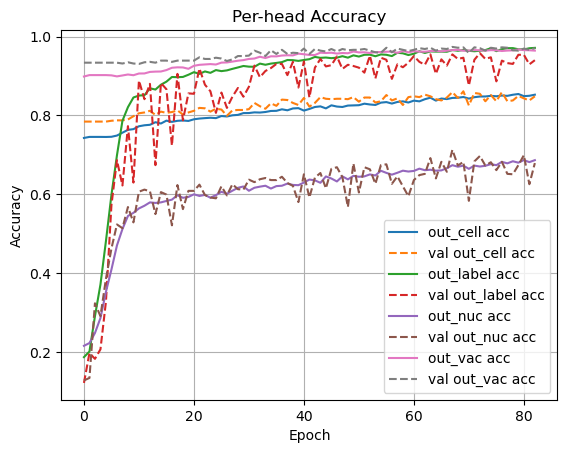

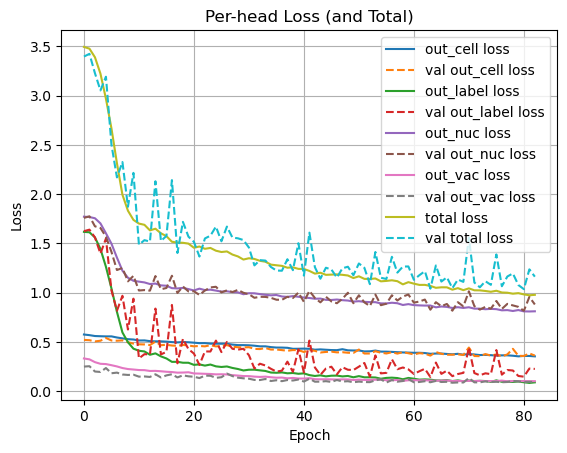

In [70]:
plot_history(final_hist)

2025-09-02 07:21:35.509973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



===== Classification report for out_cell =====
              precision    recall  f1-score   support

   irregular     0.8018    0.4341    0.5633       205
       round     0.8617    0.9705    0.9129       745

    accuracy                         0.8547       950
   macro avg     0.8318    0.7023    0.7381       950
weighted avg     0.8488    0.8547    0.8374       950



2025-09-02 07:21:36.396707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<Figure size 640x480 with 0 Axes>

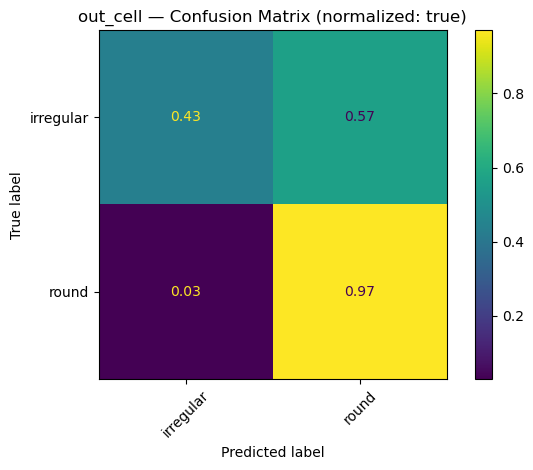


===== Classification report for out_label =====
              precision    recall  f1-score   support

    Basophil     0.9829    1.0000    0.9914       115
  Eosinophil     0.9779    0.9107    0.9431       291
  Lymphocyte     0.9537    0.9717    0.9626       106
    Monocyte     0.9675    0.9444    0.9558       126
  Neutrophil     0.9305    0.9872    0.9580       312

    accuracy                         0.9579       950
   macro avg     0.9625    0.9628    0.9622       950
weighted avg     0.9588    0.9579    0.9577       950



<Figure size 640x480 with 0 Axes>

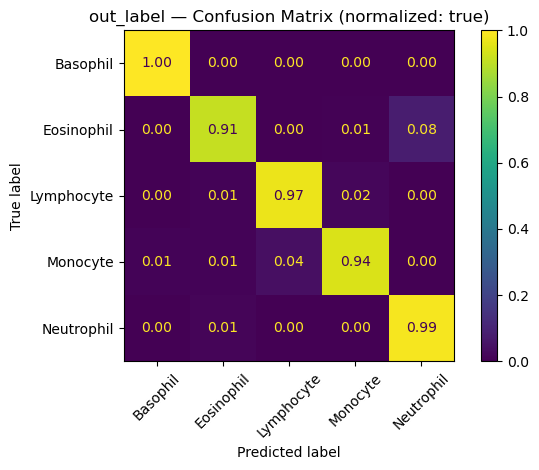


===== Classification report for out_nuc =====
                      precision    recall  f1-score   support

           irregular     0.6341    0.6842    0.6582        76
   segmented-bilobed     0.6556    0.7406    0.6955       293
segmented-multilobed     0.6410    0.2137    0.3205       117
    unsegmented-band     0.7049    0.8185    0.7575       248
unsegmented-indented     0.7706    0.6942    0.7304       121
   unsegmented-round     0.8020    0.8526    0.8265        95

            accuracy                         0.6968       950
           macro avg     0.7014    0.6673    0.6648       950
        weighted avg     0.6942    0.6968    0.6801       950



<Figure size 640x480 with 0 Axes>

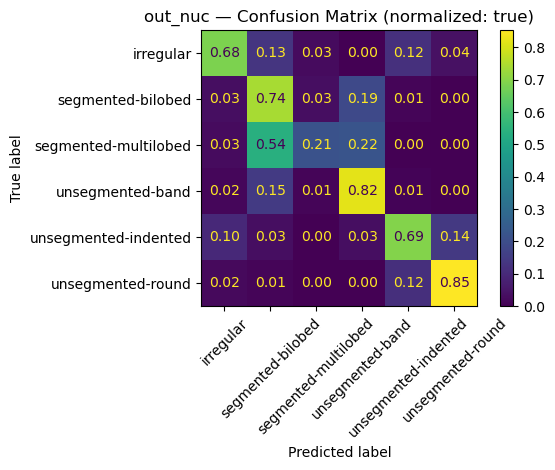


===== Classification report for out_vac =====
              precision    recall  f1-score   support

          no     0.9767    0.9921    0.9843       887
         yes     0.8571    0.6667    0.7500        63

    accuracy                         0.9705       950
   macro avg     0.9169    0.8294    0.8672       950
weighted avg     0.9688    0.9705    0.9688       950



<Figure size 640x480 with 0 Axes>

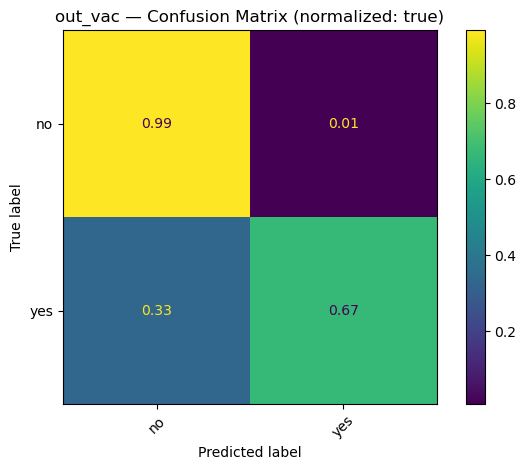

In [71]:
evaluate_heads_with_reports(
    final_model,
    blackbox_ds,                 # or test_dataset
    class_names_map=class_names_map,
    save_dir="./metrics_plots",  # optional: saves PNGs
    normalize_cm='true'          # 'true'|'pred'|'all' or False
)

In [70]:
# %load_ext tensorboard
# %tensorboard --logdir tensorboard_logs/fit

## Testing the model on Eyeball dataset

In [72]:
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

def inspect_prediction(df, index=0):
    """
    Visualize and inspect model prediction vs ground truth for a single sample from the given dataframe.

    Args:
        df (pd.DataFrame): DataFrame containing columns 'full_path', 'label', etc.
        index (int): Index of the row in df to inspect.
    """
    sample = df.iloc[index]
    img_path = sample['full_path']
    
    # Load and display the image
    img_raw = Image.open(img_path)
    plt.imshow(img_raw)
    plt.axis('off')
    plt.title(f"Ground Truth: {sample['label']}")
    plt.show()
    
    # Preprocess like the training pipeline
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, TARGET_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.expand_dims(img, axis=0)  # model expects batch dim
    
    # Predict
    pred = final_model.predict(img)

    # Decode predictions
    pred_label = label_encoder.inverse_transform([tf.argmax(pred['out_label'][0]).numpy()])[0]
    pred_cell  = cell_encoder.inverse_transform([tf.argmax(pred['out_cell'][0]).numpy()])[0]
    pred_nuc   = nuc_encoder.inverse_transform([tf.argmax(pred['out_nuc'][0]).numpy()])[0]
    pred_vac   = vac_encoder.inverse_transform([tf.argmax(pred['out_vac'][0]).numpy()])[0]
    
    print(" Predicted:")
    print(f" - Label      : {pred_label}")
    print(f" - Cell Shape : {pred_cell}")
    print(f" - Nucleus    : {pred_nuc}")
    print(f" - Vacuole    : {pred_vac}")
    
    print("\n Ground Truth:")
    print(f" - Label      : {sample['label']}")
    print(f" - Cell Shape : {sample['cell_shape']}")
    print(f" - Nucleus    : {sample['nucleus_shape']}")
    print(f" - Vacuole    : {sample['cytoplasm_vacuole']}")


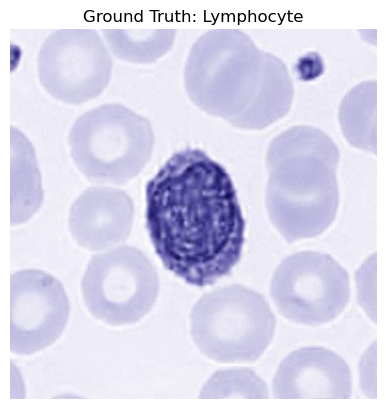

1/1 [==============================] - 0s 26ms/step
 Predicted:
 - Label      : Lymphocyte
 - Cell Shape : round
 - Nucleus    : segmented-bilobed
 - Vacuole    : no

 Ground Truth:
 - Label      : Lymphocyte
 - Cell Shape : round
 - Nucleus    : unsegmented-indented
 - Vacuole    : no


In [77]:
inspect_prediction(eyeball_df, index=22)


## Saving the model prediction

In [73]:
# import pandas as pd
# import os
# import tensorflow as tf

# # Update this with your actual folder containing test images
# IMAGE_FOLDER = "path/to/test_images"
# IMAGE_EXT = ".jpg"  # or ".png"

# # Your output CSV file
# OUT_CSV = "s4076159_predictions.csv"

# # Load your encoders and model
# # These must be defined elsewhere in your notebook or script
# # model, label_encoder, cell_encoder, nuc_encoder, vac_encoder

# def preprocess_image(path):
#     img = tf.io.read_file(path)
#     img = tf.image.decode_jpeg(img, channels=3)
#     img = tf.image.resize(img, TARGET_SIZE)  # must match your training input size
#     img = tf.cast(img, tf.float32) / 255.0
#     return tf.expand_dims(img, axis=0)

# def predict_all(df):
#     predictions = {
#         "label": [],
#         "cell_shape": [],
#         "nucleus_shape": [],
#         "cytoplasm_vacuole": []
#     }

#     for img_id in df['imageID']:
#         img_path = os.path.join(IMAGE_FOLDER, img_id + IMAGE_EXT)
#         if not os.path.exists(img_path):
#             raise FileNotFoundError(f"Image not found: {img_path}")

#         img_tensor = preprocess_image(img_path)
#         pred = model.predict(img_tensor)

#         # Decode each attribute
#         pred_label = label_encoder.inverse_transform([tf.argmax(pred['out_label'][0]).numpy()])[0]
#         pred_cell  = cell_encoder.inverse_transform([tf.argmax(pred['out_cell'][0]).numpy()])[0]
#         pred_nuc   = nuc_encoder.inverse_transform([tf.argmax(pred['out_nuc'][0]).numpy()])[0]
#         pred_vac   = vac_encoder.inverse_transform([tf.argmax(pred['out_vac'][0]).numpy()])[0]

#         # Save predictions
#         predictions["label"].append(pred_label)
#         predictions["cell_shape"].append(pred_cell)
#         predictions["nucleus_shape"].append(pred_nuc)
#         predictions["cytoplasm_vacuole"].append(pred_vac)

#     return predictions

# # Load input CSV (must contain a column 'imageID')
# input_df = pd.read_csv("test_list.csv")

# # Predict
# preds = predict_all(input_df)

# # Add predictions to DataFrame
# input_df["label"] = preds["label"]
# input_df["cell_shape"] = preds["cell_shape"]
# input_df["nucleus_shape"] = preds["nucleus_shape"]
# input_df["cytoplasm_vacuole"] = preds["cytoplasm_vacuole"]

# # Save final predictions
# input_df.to_csv(OUT_CSV, index=False)
# print(f"✅ Saved predictions to {OUT_CSV}")
